# xLSTM Networks for Top-Quark Jet Tagging

LSTM-based models and novel xLSTM architectures are implemented to identify top-quark events using simulated proton-proton collisions
generated at $\sqrt{s}$  = 13 TeV, reproducing the environment at LHC. Only low level features and up to 30 particles per jet are used in this study. Particles inside a jet are ordered according to their $p_T$.

For each particle, **15 features are used**: 
- $(p_x, p_y, p_z\$): components of the particle momentum  

- $E$: energy  

- $p_T$: transverse momentum  

- $\cos\theta$: cosine of the polar angle  

- $\eta, \phi$: pseudorapidity and azimuthal angle  
  $\eta = -\ln \tan\frac{\theta}{2}
  $

- $\Delta R$: distance from the jet axis in the $(\eta,\phi$) plane  
  \
  $\Delta R = \sqrt{(\Delta\eta)^2 + (\Delta\phi)^2}
  $

- $E_{\text{rel}}, p_{T,\text{rel}}$: ratio of the particle’s energy and transverse momentum to its jet values  

- $\eta_{\text{rel}}, \phi_{\text{rel}}$: pseudorapidity and azimuthal angle relative to the jet axis  
  
  $\eta_{\text{rel}} = \eta - \eta_\text{jet}$, $\quad$
  $\phi_{\text{rel}} = \phi - \phi_\text{jet}$

- $\eta_{\text{rot}}, \phi_{\text{rot}}$: rotated $\eta,\phi$ as described in [1]
  J. Pearkes, W. Fedorko, A. Lister, and C. Gay,  
  *Jet Constituents for Deep Neural Network Based Top Quark Tagging* (2017),  
  [arXiv:1704.02124](https://arxiv.org/abs/1704.02124)
   

# Create Dataset

We employ the HLS4ML LHC Jet Dataset, available at this link: https://zenodo.org/records/3601436

Data is divided between Training and Test samples, and is provided by .h5 files with 10000 different jet events each. In total, we have 610k jet events in the training dataset and 270k events in the test dataset. 

In [2]:
import torch
import torch.nn as nn
import numpy as np
import h5py
import json
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

In [7]:
# Create a function that generates the file name to access the data
# Should be in the format: jetImage_N_30p_START_STOP.h5
# N goes from 0 to 6, and START and STOP are the start and stop indices of the data which increment by 10000 with every file

def get_file_name(N, start, stop):
    return f"data/train/jetImage_{N}_30p_{start}_{stop}.h5"

In [ ]:
def h5_tree(val, pre='', out=""):
    length = len(val)
    for key, val in val.items():
        length -= 1
        if length == 0:  # the last item
            if type(val) == h5py._hl.group.Group:
                out += pre + '└── ' + key + "\n"
                out = h5_tree(val, pre+'    ', out)
            else:
                out += pre + '└── ' + key + f' {val.shape}\n'
        else:
            if type(val) == h5py._hl.group.Group:
                out += pre + '├── ' + key + "\n"
                out = h5_tree(val, pre+'│   ', out)
            else:
                out += pre + '├── ' + key + f' {val.shape}\n'
    return out

filename = get_file_name(0, 0, 10000)

In [ ]:
# ex: open a h5 file in this location data\train\jetImage_0_30p_0_10000.h5

with h5py.File('data/train/jetImage_0_30p_0_30000.h5', 'r') as f:
    # copy data to numpy array
    ConstituentList = np.array(f['jetConstituentList'])
    jetFeatureNames = np.array(f['jetFeatureNames'])
    #Image = np.array(f['jetImage']) # image-based representation
    #ImageECAL = np.array(f['jetImageECAL'])
    #ImageHCAL = np.array(f['jetImageHCAL'])
    jets = np.array(f['jets'])
    particleFeatureNames = np.array(f['particleFeatureNames'])


Whether or not a jet is generated by a top-quark event (label) is given by the value of the jets[-2].

In [7]:
print(jetFeatureNames[-2], "\n")
for i in range(10):
    print(jets[i][-2])

print(jetFeatureNames)

b'j_t' 

0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0


Each jet has constituents particles given by ConstituentList; the features of the particles are given by particleFeatureNames.

In [11]:
print("Constituents of the jet array shape: ", ConstituentList.shape)

print("Feature names of the constituents array shape: ", particleFeatureNames.shape)

print("Actual Feature names: ", particleFeatureNames)

Constituents of the jet array shape:  (10000, 30, 16)
Feature names of the constituents array shape:  (17,)
Actual Feature names:  [b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']


In [9]:
# some examples

print("Pt is feature number 5: ", particleFeatureNames[5])

print("Eta is feature number 7: ", particleFeatureNames[7])

print("Phi is feature number 9: ", particleFeatureNames[9])

print("Energy is feature number 3: ", particleFeatureNames[3])

print("Relative angular distance form the jet axis is feature number 15: ", particleFeatureNames[15])

print("Particle ID is feature number 16: ", particleFeatureNames[16]) # multi-class labels

Pt is feature number 5:  b'j1_pt'
Eta is feature number 7:  b'j1_eta'
Phi is feature number 9:  b'j1_etarot'
Energy is feature number 3:  b'j1_e'
Relative angular distance form the jet axis is feature number 15:  b'j1_costhetarel'
Particle ID is feature number 16:  b'j1_pdgid'


We **order the particles in a jet by descending order according to $p_t$**

In [12]:
sort_idx = np.argsort(-ConstituentList[:, :, 5], axis=1)
sorted_by_Pt_ConstituentList = np.take_along_axis(ConstituentList, sort_idx[:, :, None], axis=1)

Check

In [14]:
print(sorted_by_Pt_ConstituentList.shape)
print(sorted_by_Pt_ConstituentList[0, :, 5]) 

(10000, 30, 16)
[403.6696167  137.84762573  55.31867599  51.98291016  46.44296265
  44.40916443  35.66338348  34.52863693  26.9210701   26.68380737
  25.1668129   24.71984291  23.69188499  18.91986275  17.34101677
  16.06336594  15.03250504  13.56627464  13.05364704  12.29211807
  11.66733074  10.30390549  10.0585041    9.32068253   9.16318035
   8.45135498   7.36849403   6.6919632    6.24873447   5.24096203]


In [16]:
print(sorted_by_Pt_ConstituentList.shape)
feature_tensor = torch.from_numpy(sorted_by_Pt_ConstituentList).float()

(10000, 30, 16)


We define the labels tensor:

In [17]:
print(jets[:, -2].shape)
label_tensor = torch.from_numpy(jets[:, -2]).float()

(10000,)


In [18]:
## Convert to a pytorch dataset and save
torch.save({
    'features': feature_tensor,
    'labels': label_tensor
}, 'tt_dataset.pt')

## Load the files and create single training and test files with features and labels

In [4]:
# Open files, create features and labels for all files in the directory 

for i in [0, 1,2,3,4,5,6]:
    features_list = []
    labels_list = []
    for j in range(0,90000,10000):
        if not (i==2 and (j==30000 or j==50000)):
            filename = get_file_name(i,j, j+10000)
            with h5py.File(filename, 'r') as f:
                ConstituentList = np.array(f['jetConstituentList'])
                jet_feats = np.array(f['jets'])

            sort_idx = np.argsort(-ConstituentList[:, :, 5], axis=1)
            sorted_by_Pt_ConstituentList = np.take_along_axis(ConstituentList, sort_idx[:, :,None], axis=1)
            sorted_by_Pt_ConstituentList = sorted_by_Pt_ConstituentList[:, :30, :15]

            feature_tensor = torch.from_numpy(sorted_by_Pt_ConstituentList).float()
            label_tensor = torch.from_numpy(jet_feats[:, -2]).float()

            features_list.append(feature_tensor)
            labels_list.append(label_tensor)

    # Concatenate only once per i
    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    torch.save({'features': features, 'labels': labels}, f"tt_train_dataset_{i}.pt") # then same for _test_ files
    print(f"Saved file {i} with shape {features.shape}")


Saved file 0 with shape torch.Size([90000, 30, 15])
Saved file 1 with shape torch.Size([90000, 30, 15])
Saved file 2 with shape torch.Size([70000, 30, 15])
Saved file 3 with shape torch.Size([90000, 30, 15])
Saved file 4 with shape torch.Size([90000, 30, 15])
Saved file 5 with shape torch.Size([90000, 30, 15])
Saved file 6 with shape torch.Size([90000, 30, 15])


In [2]:
all_features = []
all_labels = []

for i in range(7):
    data = torch.load(f"tt_train_dataset_{i}.pt")
    all_features.append(data['features'])
    all_labels.append(data['labels'])
    print(f"Loaded training file {i} with shape {data['features'].shape}")

# concatenate all loaded tensors
features = torch.cat(all_features, dim=0)
labels = torch.cat(all_labels, dim=0)

# save the merged dataset
torch.save({'features': features, 'labels': labels}, "tt_train_dataset_full.pt")
print(f"Saved full dataset: {features.shape}, {labels.shape}")

Loaded training file 0 with shape torch.Size([90000, 30, 15])
Loaded training file 1 with shape torch.Size([90000, 30, 15])
Loaded training file 2 with shape torch.Size([70000, 30, 15])
Loaded training file 3 with shape torch.Size([90000, 30, 15])
Loaded training file 4 with shape torch.Size([90000, 30, 15])
Loaded training file 5 with shape torch.Size([90000, 30, 15])
Loaded training file 6 with shape torch.Size([90000, 30, 15])
Saved full dataset: torch.Size([610000, 30, 15]), torch.Size([610000])


## Features visualization

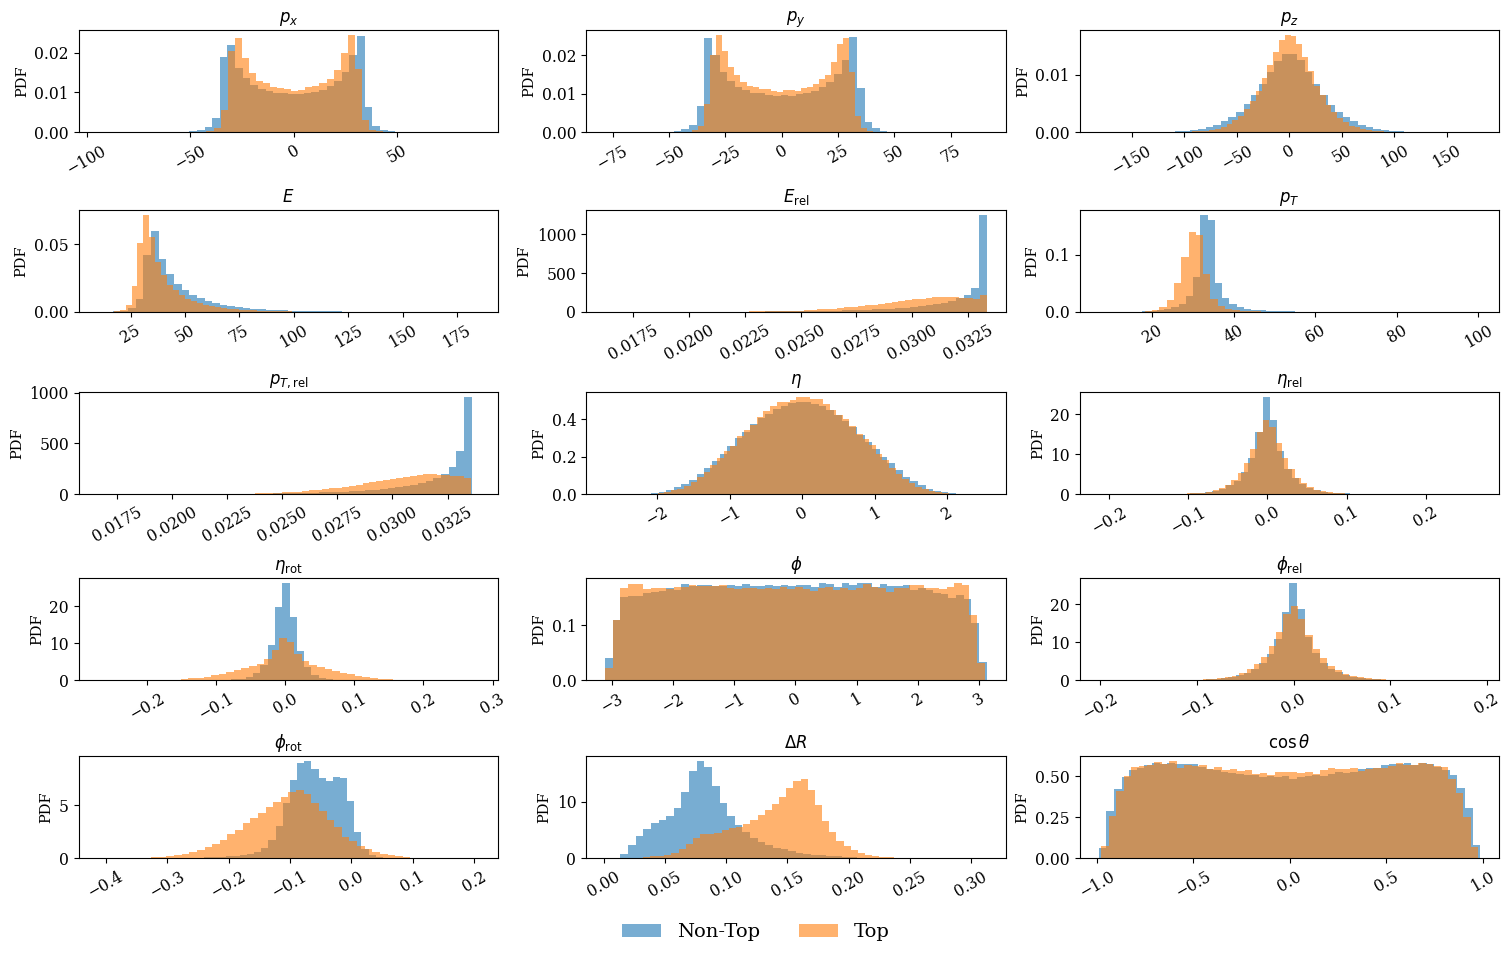

In [11]:
# using mean values of the features over the 30 particles 

data_dict = torch.load(f'tt_train_dataset_full.pt')
features= data_dict['features']  # shape: [N, 30, 15]
labels = data_dict['labels']   
features = features.mean(dim=1)  # mean of each feature over the 30 particles; now shape is [N, 15] 
features_np = features.numpy()
labels_np = labels.numpy()
particleFeatureNames = [
    r'$p_x$', r'$p_y$', r'$p_z$', r'$E$', r'$E_{\rm rel}$', 
    r'$p_T$', r'$p_{T,{\rm rel}}$', r'$\eta$', r'$\eta_{\rm rel}$', r'$\eta_{\rm rot}$',
    r'$\phi$', r'$\phi_{\rm rel}$', r'$\phi_{\rm rot}$', r'$\Delta R$', r'$\cos\theta$']
fig_height = 20*0.45  

# Font scaling factor
font_scale = 0.7

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 15*font_scale,
    "axes.titlesize": 17*font_scale,
    "axes.labelsize": 15*font_scale,
    "legend.fontsize": 14*font_scale,
    "xtick.labelsize": 16*font_scale,
    "ytick.labelsize": 16*font_scale
})

# grid of subplots
num_features = features_np.shape[1]
fig, axes = plt.subplots(5, 3, figsize=(15,fig_height), constrained_layout=True)
axes = axes.flatten()

# histograms of the features divided per label 
for i in range(num_features):
    ax = axes[i]
    ax.hist(features_np[labels_np == 0][:, i], bins=50, alpha=0.6, 
            label='Non-Top', density=True, color='C0')
    ax.hist(features_np[labels_np == 1][:, i], bins=50, alpha=0.6, 
            label='Top', density=True, color='C1')
    ax.set_title(particleFeatureNames[i])
    ax.set_ylabel('PDF')
    ax.tick_params(axis='x', rotation=30)  


for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])
    

fig.subplots_adjust(bottom=0.05, hspace=0.5)

# legend in new row
handles, labels_legend = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_legend,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.00),  # placed below all subplots
           ncol=2, frameon=False, fontsize=14)

plt.savefig("feature_histograms.pdf", dpi=400, bbox_inches="tight")
plt.show()

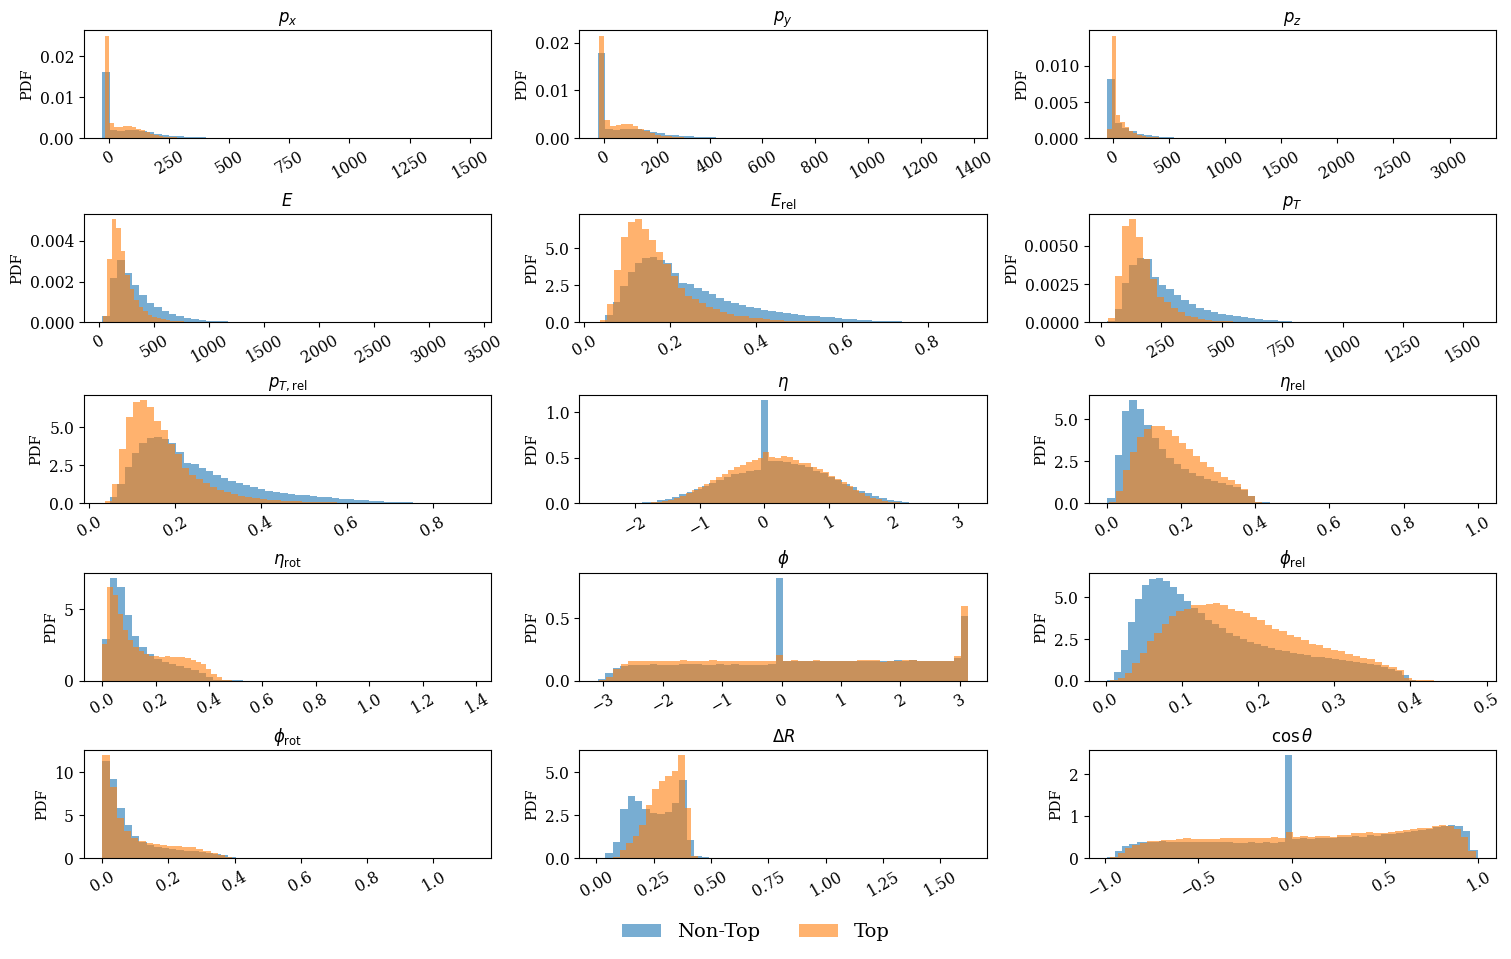

In [10]:
# using max values of the features over the 30 particles 
data_dict = torch.load(f'tt_train_dataset_full.pt')
features= data_dict['features']  # shape: [N, 30, 15]
labels = data_dict['labels']   

features = features.max(dim=1).values  # max of each feature over the 30 particles; now shape is [N, 15] 
features_np = features.numpy()
labels_np = labels.numpy()
particleFeatureNames = [
    r'$p_x$', r'$p_y$', r'$p_z$', r'$E$', r'$E_{\rm rel}$', 
    r'$p_T$', r'$p_{T,{\rm rel}}$', r'$\eta$', r'$\eta_{\rm rel}$', r'$\eta_{\rm rot}$',
    r'$\phi$', r'$\phi_{\rm rel}$', r'$\phi_{\rm rot}$', r'$\Delta R$', r'$\cos\theta$']

fig_height = 20*0.45  

# Font scaling factor
font_scale = 0.7

plt.rcParams.update({
    "font.family": "serif",
    "font.size": 15*font_scale,
    "axes.titlesize": 17*font_scale,
    "axes.labelsize": 15*font_scale,
    "legend.fontsize": 14*font_scale,
    "xtick.labelsize": 16*font_scale,
    "ytick.labelsize": 16*font_scale
})

# grid of subplots
num_features = features_np.shape[1]
fig, axes = plt.subplots(5, 3, figsize=(15,fig_height), constrained_layout=True)
axes = axes.flatten()

# histograms of the features divided per label 
for i in range(num_features):
    ax = axes[i]
    ax.hist(features_np[labels_np == 0][:, i], bins=50, alpha=0.6, 
            label='Non-Top', density=True, color='C0')
    ax.hist(features_np[labels_np == 1][:, i], bins=50, alpha=0.6, 
            label='Top', density=True, color='C1')
    ax.set_title(particleFeatureNames[i])
    ax.set_ylabel('PDF')
    ax.tick_params(axis='x', rotation=30)  


for j in range(num_features, len(axes)):
    fig.delaxes(axes[j])
    

fig.subplots_adjust(bottom=0.05, hspace=0.5)

# legend in new row
handles, labels_legend = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_legend,
           loc='upper center',
           bbox_to_anchor=(0.5, 0.00),  # placed below all subplots
           ncol=2, frameon=False, fontsize=14)

plt.savefig("feature_histograms_max.pdf", dpi=400, bbox_inches="tight")
plt.show()




## Study of the correlation between features and labels

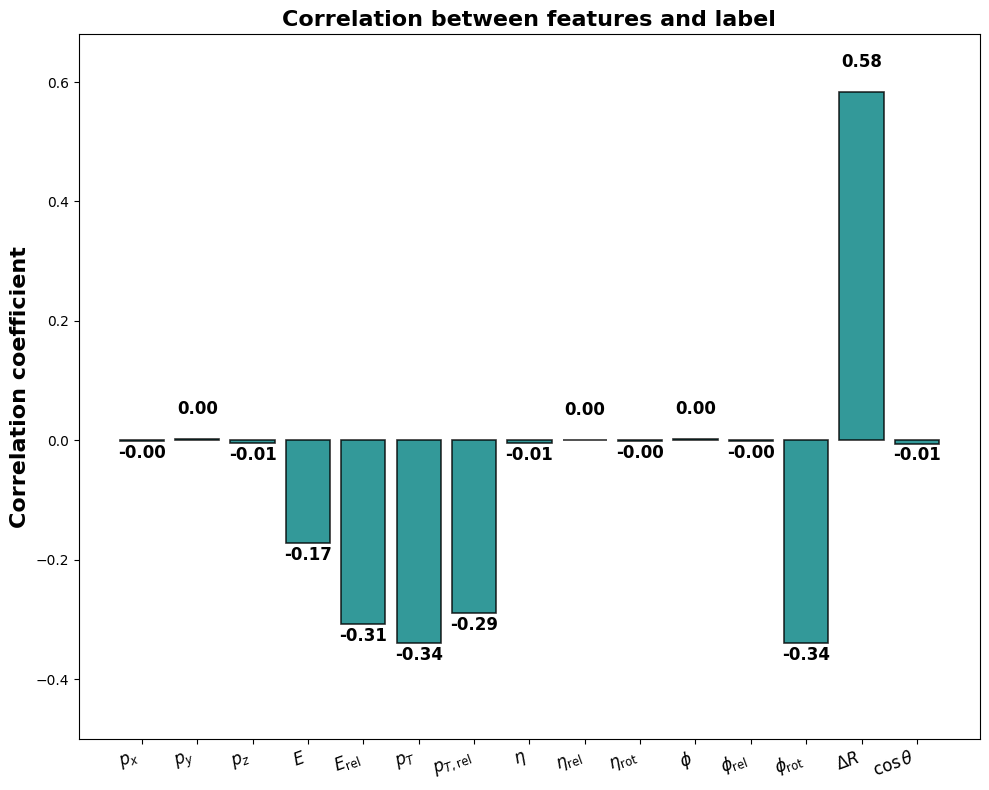

In [51]:
# we use Pearson's coefficient to analyze the correlation between the mean value over the 30 particles for each feature and the correspondent label 

features= data_dict['features']  # shape: [N, 30, 15]
features = features.mean(dim=1)
particleFeatureNames = [
    r'$p_x$', r'$p_y$', r'$p_z$', r'$E$', r'$E_{\rm rel}$', 
    r'$p_T$', r'$p_{T,{\rm rel}}$', r'$\eta$', r'$\eta_{\rm rel}$', r'$\eta_{\rm rot}$',
    r'$\phi$', r'$\phi_{\rm rel}$', r'$\phi_{\rm rot}$', r'$\Delta R$', r'$\cos\theta$']

correlations = np.zeros(num_features)  
for i in range(num_features):
    feature = features[:, i]  
    correlations[i] = np.corrcoef(feature,labels_np)[0, 1]

# bar plot to display the correlations
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.bar(particleFeatureNames[:num_features], correlations, color='teal', edgecolor='black', linewidth=1.2,alpha=0.8)

# add correlation values on top of each bar
for i, corr in enumerate(correlations):
    ax.text(i, corr + 0.035 if corr>=0 else corr-0.035, f'{corr:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_ylabel('Correlation coefficient', fontsize=16, fontweight='bold')
ax.set_ylim(-0.5,0.68)
ax.set_title('Correlation between features and label', fontsize=16, fontweight='bold')
ax.set_xticks(np.arange(len(particleFeatureNames[:num_features])))
ax.set_xticklabels(particleFeatureNames[:num_features], fontsize=12, fontweight='bold', rotation=20, ha='right')
plt.tight_layout()
plt.show()

From this analysis and the previous plots it appears that the most useful features to discriminate between the two classes are: 
$E$, $E_{rel}$, $p_t$, $p_{t,rel}$,$\phi_{rot}$ and $\Delta_R$. In this work we will adopt a more data-driven approach rather than a physics-motivated approach; coherently with what is done in similar papers [2] https://arxiv.org/pdf/2503.03103,
[3] https://arxiv.org/pdf/1704.02124, we will use all 15 features as input of the models.


## Create Dataset for the learning task

We split the training data into the actual training dataset (90\%) and the validation dataset (10\%). We create the Dataloaders for training, validation and test samples.

In [2]:
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import StandardScaler

data_dict = torch.load(f'tt_train_dataset_full.pt')
features= data_dict['features']  # shape: [N, 30, 16]
labels = data_dict['labels']
features_np = features.numpy()
labels_np = labels.numpy()
print(features.shape,labels.shape)


# temporarily flatten all particles into one list to compute mean and std per feature across all particles
num_samples, num_particles, num_features = features_np.shape
features_reshaped = features_np.reshape(-1, num_features)

# fit scaler on the training set
scaler = StandardScaler()
scaler.fit(features_reshaped)  
features_scaled = scaler.transform(features_reshaped)

# reshape back to original shape
features = features_scaled.reshape(num_samples, num_particles, num_features)
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels_np, dtype=torch.float32)

full_train_dataset = TensorDataset(features,labels) # to use in grid searches with K-fold cross validation

# for final training or for simple training-validation splitting  
train_dataset = TensorDataset(features[0:549000],labels[0:549000]) # 90% for training, 10% for validation
valid_dataset = TensorDataset(features[549000:],labels[549000:])

num_pos = (labels == 1).sum()
num_neg = (labels == 0).sum()
pos_weight_train = num_neg / num_pos # used later to define weight to penalize false negatives more
print("In the training set, class 0 is", np.array(pos_weight_train), "times more present")

# repeat for test dataset

data_dict = torch.load(f'tt_test_dataset_full.pt')
features= data_dict['features']  # shape: [N, 30, 16]
labels = data_dict['labels']
features_np = features.numpy()
labels_np = labels.numpy()
print(features.shape,labels.shape)

num_samples, num_particles, num_features = features_np.shape
features_reshaped = features_np.reshape(-1, num_features)

scaler = StandardScaler()
scaler.fit(features_reshaped)  
features_scaled = scaler.transform(features_reshaped)
features = features_scaled.reshape(num_samples, num_particles, num_features)
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels_np, dtype=torch.float32)

test_dataset = TensorDataset(features,labels) 

# create Dataloaders
batch_size= 1024
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

torch.Size([610000, 30, 15]) torch.Size([610000])
In the training set, class 0 is 3.946922 times more present
torch.Size([270000, 30, 15]) torch.Size([270000])


## LSTM: model defintion

We aim to gradually increase the complexity of our LSTM model and benchmark its performance as we introduce additional enhancements. First we define a "vanilla" LSTM, with 1 layer and a reasonable number of hidden states. The LSTM output is vectorized in a FFNN layer by considering the arithmetic mean over the sequence of 30 particles (mean pooling). Here we use standard Binary Cross Entropy loss. This is a "level 1" benckmark. \
We then introduce an attention pooling layer, which defines an importance weight for each of the jet particles, to consider a weighted average when vectorizing in the FFNN final layer. We also introduce a weight in the loss which penalizes false negatives more, considering the dataset is imbalanced with fewer class 1 samples ("level 2" benchamrking). \
We then consider a grid search to fine tune a multi-layer LSTM model with attention ("level 3" benchamrking). 

Since the plain accuracy of the predictions depends on the threshold chosen to discriminate between classes, it is not the ideal metric to use in the model optimization procedure. In a real life implementation of a tagger in an experiment, we would never use 0.5 as the classifier threshold. Instead, we typically define several working points with different thresholds, each with a given percentage for the false positive rate tolerated (we examine **TPR at 10%, 1% and 0.1% FPR**). A more significant metric for the optimization is therefore the **area under of the ROC curve** of the model (AUC in the following), which represents the probability that a randomly chosen positive sample (top event) will ouput a higher value in the model than a randomly chosen negative sample (non-top event). We also consider as metric the **rejection rate** (1/FPR) **at 30% and 50% TPR**, standard benchmarking at LHC.

## Vanilla LSTM

In [3]:

class VanillaJetTagger(nn.Module):
    def __init__(self,hidden_size,num_layers=1,input_size=15,num_classes=1):
        super(VanillaJetTagger, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,num_layers, batch_first=True)
        
        # final NN classification layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: [batch_size, 30, num_features]
        out, (hn, cn) = self.lstm(x)  # out: [batch_size, 30, hidden_size]
        nn_input = torch.mean(out, dim=1)  # mean pooling: aggregates info from all particles considering their mean...[batch,hidden_size]
        logits = self.fc(nn_input) # [batch, num_classes]
        return logits  # we then apply sigmoid to predict labels 

    def _init_weights(self, module):  # applies Xavier-Glorot weights initialization to all layers and sets biases to zero
        if isinstance(module, torch.nn.LSTM):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
                
    def predict(model, x, binary=True):
        model.eval()
        with torch.no_grad():
            logits = model(x)
            if binary:
                probs = torch.sigmoid(logits).squeeze(-1)  # [batch]
                preds = (probs > 0.5).long()
            else:
                probs = torch.softmax(logits, dim=1) # [batch, num_classes]
                preds = torch.argmax(probs, dim=1)
        return preds, probs

             

In [4]:
from torch.nn import BCEWithLogitsLoss
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score,confusion_matrix

def evaluate_network(dataloader,model,pos_weight=3.017395,data_split='Test set'):
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataloader):
            batch_x = batch_x.to(device).float()
            batch_y = batch_y.unsqueeze(1).to(device).float()

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        loss_fn = nn.BCEWithLogitsLoss(reduction='mean',pos_weight=torch.tensor(pos_weight, device=device)) 
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        loss = loss_fn(predictions, true).detach().cpu().numpy()
        predictions = torch.sigmoid(predictions).detach().cpu().numpy()
        true = true.detach().cpu().numpy()

        fpr, tpr, thresholds = roc_curve(true, predictions)
        auc = roc_auc_score(true, predictions)
        prediction_labels = predictions.round()
        precision, recall, fscore, _= precision_recall_fscore_support(true, prediction_labels, average='binary')
        accuracy = accuracy_score(true, prediction_labels)
        print(f"{data_split} Loss: {loss}, ROC AUC: {auc}")
         
        # ROC curve
        plt.figure()
        plt.plot(fpr,tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % auc)
        plt.plot([0, 1],[0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate',fontsize=13.5)
        plt.ylabel('True Positive Rate',fontsize=13.5)
        plt.title(f'{data_split} ROC curve',fontsize=14)
        plt.legend(loc="lower right",fontsize=11.5)
        plt.show()
        
        # confusion matrix with usual 0.5 threshold
        cm = confusion_matrix(true,prediction_labels)
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix: Threshold=0.5')
        plt.show()
        print(f"With threshold=0.5: {data_split} Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {fscore:.4f} \n")
        # desired FPRs to define other thresholds
        target_fprs = [0.1, 0.01, 0.001]
        target_fprs_labels = ["10%","1%","0.1%"]

        for fpr_target, label in zip(target_fprs,target_fprs_labels):
        # find threshold with closest TPR 
            idx = np.argmin(np.abs(fpr-fpr_target))
            new_threshold = thresholds[idx]
            actual_fpr = fpr[idx]
            actual_tpr = tpr[idx]
        
            # confusion matrix with new threshold
            preds_thresh = (predictions >= new_threshold).astype(int)
            cm = confusion_matrix(true, preds_thresh)
        
            plt.figure(figsize=(7, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title(f'Confusion Matrix with FPR = {label}: TPR={actual_tpr*100:.2f}%, Threshold={new_threshold:.4f}')
            plt.show()
            
            precision, recall, fscore, _= precision_recall_fscore_support(true, preds_thresh, average='binary')
            accuracy = accuracy_score(true, preds_thresh)
            print(f"With threshold={new_threshold:.4f}: {data_split} Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {fscore:.4f} \n")
        
        # Other metric: background rejection (1/FPR) at TPR = 30% and 50% (common in papers)
        target_tprs = [0.3,0.5]  
        for tpr_target in target_tprs:
            # find threshold where TPR is closest to target
            idx = np.argmin(np.abs(tpr - tpr_target))
            actual_tpr = tpr[idx]
            actual_fpr = fpr[idx]
            if actual_fpr > 0:
                rejection = 1.0/actual_fpr
            else:
                rejection = np.inf
            print(f"Background rejection at TPR={tpr_target*100:.0f}%: 1/FPR = {rejection:.4f} (FPR={actual_fpr:.4f})")


In [7]:
# Training level 1 model 
import os
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score,confusion_matrix

# we use dim=45 for for this benchmarking (same hidden size as best mLSTM block found later) 
model = VanillaJetTagger(
    hidden_size=45 ,
    num_layers=1,
    input_size=15,         
    num_classes=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

scaler = GradScaler()
opt = Adam(model.parameters(), lr=5*10**(-3))

# no weight penalization for false positives here
loss_fn = nn.BCEWithLogitsLoss(reduction='mean') # it internally applies sigmoid before computing binary cross-entropy.

# train on the entire training set 
epochs = 50
best_auc = 0

train_losses=[]
val_losses=[]

for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader) 

    epoch_train_loss = 0
    num_batches = 0

    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True)

        opt.zero_grad()
        with autocast(enabled=False):  # True for mixed precision
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        epoch_train_loss += loss.item()
        num_batches += 1
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    
    avg_train_loss = epoch_train_loss/num_batches
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader): 
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True)

            logits = model(batch_x)
            predictions.append(logits)
            true.append(batch_y)
        predictions = torch.cat(predictions, dim=0)
        true = torch.cat(true, dim=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean() # assuming 0.5 as threshold
        val_auc = roc_auc_score(true,predictions)

        val_losses.append(val_loss.item())
        print(f"Validation loss: {val_loss.item()}, AUC: {val_auc}, Accuracy: {val_acc.item()}")

        # save model if it's the best so far (gretaer val AUC)
        if val_auc > best_auc:
            os.makedirs("Vanilla_LSTM", exist_ok=True)
            torch.save(model.state_dict(), "Vanilla_LSTM/Level_1_model_final_training_15_September.pt")
            print("saved best model")
            best_auc = val_auc

with open("Vanilla_LSTM/Final_training_losses_Level_1_model_15_September.json", "w") as f:
    json.dump({"train_losses": train_losses,"val_losses": val_losses}, f)


Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.64it/s]


Validation loss: 0.21754392981529236, AUC: 0.945800632910067, Accuracy: 0.9199180603027344
saved best model
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.24it/s]


Validation loss: 0.19714219868183136, AUC: 0.9540683734955436, Accuracy: 0.9277541041374207
saved best model
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.91it/s]


Validation loss: 0.1901838481426239, AUC: 0.9584780274302467, Accuracy: 0.9290655851364136
saved best model
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.49it/s]


Validation loss: 0.18686898052692413, AUC: 0.9591394504663605, Accuracy: 0.9307705163955688
saved best model
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.20it/s]


Validation loss: 0.19062167406082153, AUC: 0.9592485026594499, Accuracy: 0.929901659488678
saved best model
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.51it/s]


Validation loss: 0.18658336997032166, AUC: 0.9588823846823229, Accuracy: 0.9306557178497314
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.78it/s]


Validation loss: 0.18247489631175995, AUC: 0.9613380454880727, Accuracy: 0.9320327639579773
saved best model
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.39it/s]


Validation loss: 0.18546175956726074, AUC: 0.9608832451669734, Accuracy: 0.9304918050765991
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.62it/s]


Validation loss: 0.18198911845684052, AUC: 0.9618155681668703, Accuracy: 0.9325901865959167
saved best model
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.04it/s]


Validation loss: 0.18126758933067322, AUC: 0.9620655589745531, Accuracy: 0.9322623014450073
saved best model
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.49it/s]


Validation loss: 0.17837843298912048, AUC: 0.963337547317997, Accuracy: 0.9335409998893738
saved best model
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 46.99it/s]


Validation loss: 0.17983974516391754, AUC: 0.9628492401615, Accuracy: 0.9325737953186035
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.46it/s]


Validation loss: 0.17922896146774292, AUC: 0.9631699358597302, Accuracy: 0.9330983757972717
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.49it/s]


Validation loss: 0.17935732007026672, AUC: 0.9631099115741967, Accuracy: 0.9337376952171326
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.94it/s]


Validation loss: 0.17678864300251007, AUC: 0.9642447954516142, Accuracy: 0.9345245957374573
saved best model
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.56it/s]


Validation loss: 0.1761915683746338, AUC: 0.9641538860772649, Accuracy: 0.9344918131828308
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.92it/s]


Validation loss: 0.1780969202518463, AUC: 0.9635556184649166, Accuracy: 0.9343934655189514
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.66it/s]


Validation loss: 0.1809864193201065, AUC: 0.9628103967630119, Accuracy: 0.9332786798477173
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.88it/s]


Validation loss: 0.17749279737472534, AUC: 0.9639227361127687, Accuracy: 0.9340819716453552
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.82it/s]


Validation loss: 0.17777961492538452, AUC: 0.9640390843232876, Accuracy: 0.9343114495277405
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.72it/s]


Validation loss: 0.1813230961561203, AUC: 0.963103214694417, Accuracy: 0.9332458972930908
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 44.97it/s]


Validation loss: 0.17776258289813995, AUC: 0.9642725178249019, Accuracy: 0.9338852167129517
saved best model
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.15it/s]


Validation loss: 0.17714384198188782, AUC: 0.964065918377369, Accuracy: 0.9338688254356384
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.54it/s]


Validation loss: 0.17681550979614258, AUC: 0.9641910833014329, Accuracy: 0.9344098567962646
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 47.05it/s]


Validation loss: 0.17842602729797363, AUC: 0.9640283156342365, Accuracy: 0.9328688383102417
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.10it/s]


Validation loss: 0.17813488841056824, AUC: 0.9640898074330709, Accuracy: 0.9336721301078796
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.76it/s]


Validation loss: 0.17960594594478607, AUC: 0.963864852435538, Accuracy: 0.9332131147384644
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.79it/s]


Validation loss: 0.18012994527816772, AUC: 0.9632898306992228, Accuracy: 0.933327853679657
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.49it/s]


Validation loss: 0.1775580495595932, AUC: 0.964004403311053, Accuracy: 0.9338032603263855
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.18it/s]


Validation loss: 0.1788158416748047, AUC: 0.9643816880173619, Accuracy: 0.9326557517051697
saved best model
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.78it/s]


Validation loss: 0.17885303497314453, AUC: 0.963441367651663, Accuracy: 0.9335737824440002
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.50it/s]


Validation loss: 0.17939072847366333, AUC: 0.9636714788893042, Accuracy: 0.9329180121421814
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.07it/s]


Validation loss: 0.1774798035621643, AUC: 0.9640444308581557, Accuracy: 0.9343278408050537
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 57.19it/s]


Validation loss: 0.17972713708877563, AUC: 0.9635228154708356, Accuracy: 0.9331311583518982
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.69it/s]


Validation loss: 0.17784970998764038, AUC: 0.9639983130477567, Accuracy: 0.9338196516036987
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 44.14it/s]


Validation loss: 0.1804419755935669, AUC: 0.9635559458716212, Accuracy: 0.9331475496292114
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 55.94it/s]


Validation loss: 0.1791861653327942, AUC: 0.9633410989328596, Accuracy: 0.9335082173347473
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.54it/s]


Validation loss: 0.17724640667438507, AUC: 0.9642683687343522, Accuracy: 0.9338196516036987
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 54.27it/s]


Validation loss: 0.17892098426818848, AUC: 0.9636884525170966, Accuracy: 0.9337868690490723
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 55.29it/s]


Validation loss: 0.1794913113117218, AUC: 0.9638992035481233, Accuracy: 0.932311475276947
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.08it/s]


Validation loss: 0.17780984938144684, AUC: 0.9642392677627827, Accuracy: 0.9339344501495361
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 54.53it/s]


Validation loss: 0.17857781052589417, AUC: 0.9638528073589274, Accuracy: 0.933327853679657
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.21it/s]


Validation loss: 0.18324962258338928, AUC: 0.9621405409267988, Accuracy: 0.9327704906463623
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.30it/s]


Validation loss: 0.18120121955871582, AUC: 0.9631906073551261, Accuracy: 0.9322295188903809
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.19it/s]


Validation loss: 0.17855523526668549, AUC: 0.9639384607753905, Accuracy: 0.9337213039398193
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.26it/s]


Validation loss: 0.18325641751289368, AUC: 0.9621628777090886, Accuracy: 0.9323934316635132
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.15it/s]


Validation loss: 0.18065153062343597, AUC: 0.9635679419203242, Accuracy: 0.9331311583518982
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.99it/s]


Validation loss: 0.178255096077919, AUC: 0.9641854459230456, Accuracy: 0.933557391166687
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.95it/s]


Validation loss: 0.1793241798877716, AUC: 0.9639054101488274, Accuracy: 0.9335246086120605
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 55.15it/s]

Validation loss: 0.1799546629190445, AUC: 0.9635197582899561, Accuracy: 0.933114767074585


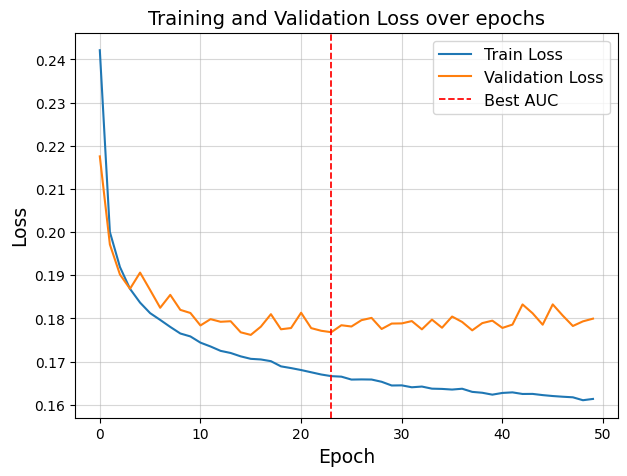

In [12]:
with open("Vanilla_LSTM/Final_training_losses_Level_1_model_15_September.json","r") as f:
    data = json.load(f)

plt.figure(figsize=(7,5))
epochs= np.arange(len(data["train_losses"]))
plt.plot(epochs,data["train_losses"], label="Train Loss")
plt.plot(epochs,data["val_losses"], label="Validation Loss")
plt.xlabel("Epoch",fontsize=13.5)
plt.ylabel("Loss",fontsize=13.5)
plt.axvline(x=23,color='red', linestyle='--', linewidth=1.25,label="Best AUC")
plt.title("Training and Validation Loss over epochs",fontsize=14)
plt.legend(fontsize=11.5)
plt.grid(True,alpha=0.5)
plt.savefig("vanilla_LSTM_level1_losses.pdf", dpi=400, bbox_inches="tight")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:06<00:00, 43.16it/s]


Test set Loss: 0.17938870191574097, ROC AUC: 0.9640503511288909


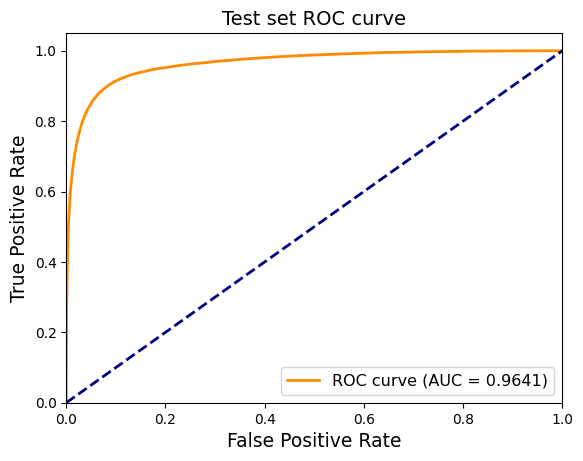

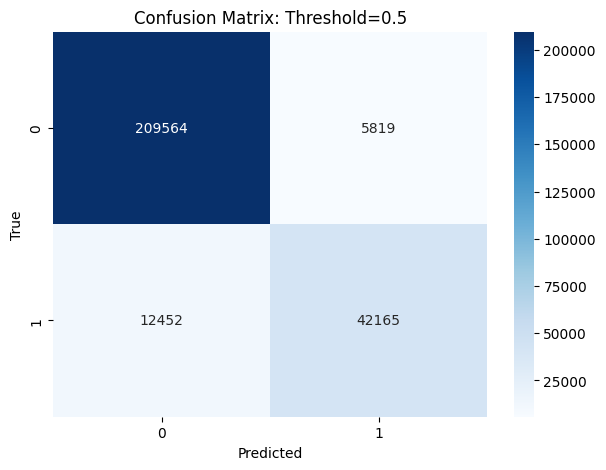

With threshold=0.5: Test set Accuracy: 0.9323, Precision: 0.8787, Recall: 0.7720, F1 score: 0.8219 



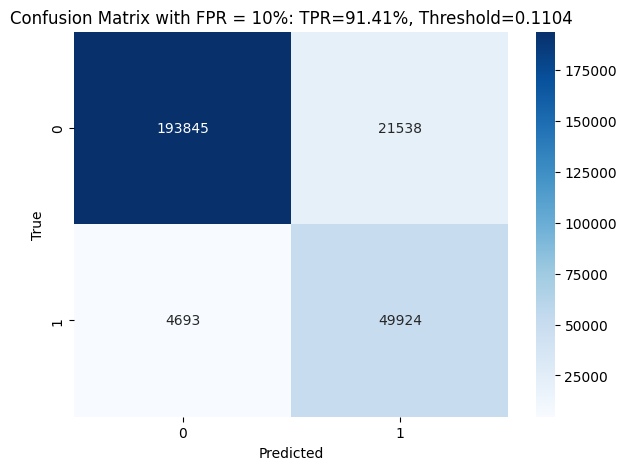

With threshold=0.1104: Test set Accuracy: 0.9028, Precision: 0.6986, Recall: 0.9141, F1 score: 0.7919 



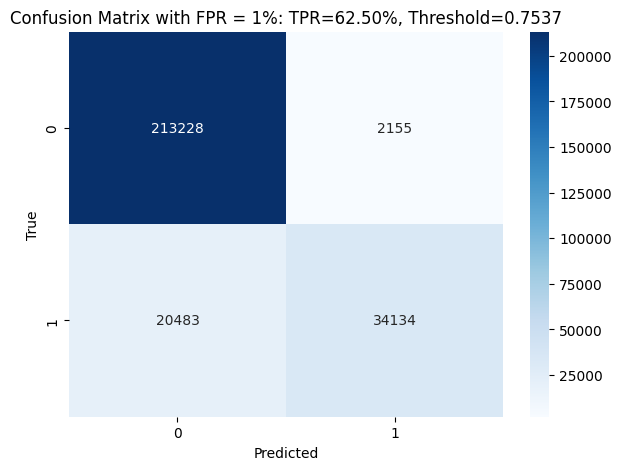

With threshold=0.7537: Test set Accuracy: 0.9162, Precision: 0.9406, Recall: 0.6250, F1 score: 0.7510 



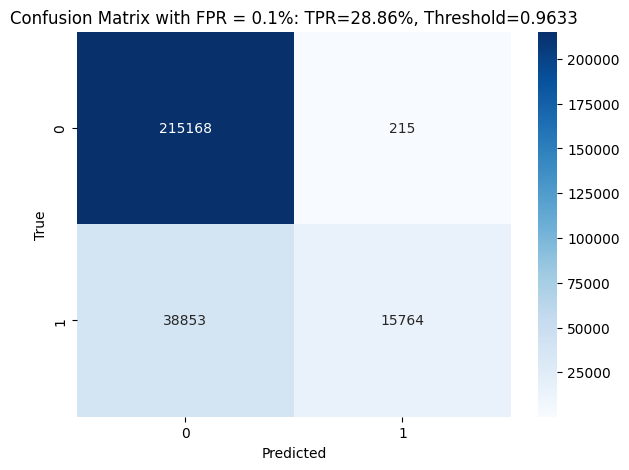

With threshold=0.9633: Test set Accuracy: 0.8553, Precision: 0.9865, Recall: 0.2886, F1 score: 0.4466 

Background rejection at TPR=30%: 1/FPR = 924.3906 (FPR=0.0011)
Background rejection at TPR=50%: 1/FPR = 233.0985 (FPR=0.0043)


In [11]:
model.load_state_dict(torch.load("Vanilla_LSTM/Level_1_model_final_training_15_September.pt", map_location=device))
evaluate_network(test_dataloader,model,1.0, "Test set")

In [6]:
model =  VanillaJetTagger(45)
print(f"Params number of the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Params number of the model: 11206


## LSTM with attention

In [7]:
import torch.nn as nn

class JetTaggerLSTM(nn.Module):
    def __init__(self,hidden_size,num_layers,input_size=15,num_classes=1):
        super(JetTaggerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
       
        # attention layer: maps [batch, seq_len=30,hidden_size] to [batch,seq_len=30, 1] (defines an importance weight to each particle of the jet)
        self.attention_layer = nn.Linear(hidden_size, 1) 
       
        # final NN classification layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: [batch_size, 30, num_features]
        out, (hn, cn) = self.lstm(x)  # out: [batch_size, 30, hidden_size]
        att_scores = self.attention_layer(out)  # [batch_size, 30, 1] 
        att_weights = torch.softmax(att_scores, dim=1)  # normalize scores over the number of particles
        nn_input = torch.sum(out*att_weights, dim=1)  # attention pooling: aggregates info from all particles giving a different weight to each particle...[batch,hidden_size]
        logits = self.fc(nn_input) # [batch, num_classes]
        return logits  # then apply sigmoid to predict labels 

    def _init_weights(self, module):  # applies Xavier-Glorot weights initialization to all layers and sets biases to zero
        if isinstance(module, torch.nn.LSTM):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
                
    def predict(model, x, binary=True):
        model.eval()
        with torch.no_grad():
            logits = model(x)
            if binary:
                probs = torch.sigmoid(logits).squeeze(-1)  # [batch]
                preds = (probs > 0.5).long()
            else:
                probs = torch.softmax(logits, dim=1) # [batch, num_classes]
                preds = torch.argmax(probs, dim=1)
        return preds, probs

             

We now introduce the attention layer and a different weight penalization for false positives in the loss. Here we use the ratio between the number of class 0 and class 1 samples as weight; leter it will be a hyper-parameter to optimize.

In [14]:
# Training level 2 model 
import os
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score,confusion_matrix

# we use again dim=45 to compare
model = JetTaggerLSTM(
    hidden_size=45 ,
    num_layers=1,
    input_size=15,         
    num_classes=1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

scaler = GradScaler()
opt = Adam(model.parameters(), lr=5e-3)

# we introduce a penalization weight for false positives
# here we use the training set ratio between the number of class 0 and class 1 samples pos_weight_train=3.947
pos_weight = torch.tensor(pos_weight_train, device=device)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight.to(device)) 

# train on the entire training set 
epochs = 50
best_auc = 0

train_losses=[]
val_losses=[]

for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader) 

    epoch_train_loss = 0
    num_batches = 0

    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True)

        opt.zero_grad()
        with autocast(enabled=False):  # True for mixed precision
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        epoch_train_loss += loss.item()
        num_batches += 1
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    
    avg_train_loss = epoch_train_loss/num_batches
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader): 
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True)

            logits = model(batch_x)
            predictions.append(logits)
            true.append(batch_y)
        predictions = torch.cat(predictions, dim=0)
        true = torch.cat(true, dim=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean() # assuming 0.5 as threshold
        val_auc = roc_auc_score(true,predictions)

        val_losses.append(val_loss.item())
        print(f"Validation loss: {val_loss.item()}, AUC: {val_auc}, Accuracy: {val_acc.item()}")

        # save model if it's the best so far (gretaer val AUC)
        if val_auc > best_auc:
            os.makedirs("Vanilla_LSTM", exist_ok=True)
            torch.save(model.state_dict(), "Vanilla_LSTM/Level_2_model_final_training_15_September.pt")
            print("saved best model")
            best_auc = val_auc

with open("Vanilla_LSTM/Final_training_losses_Level_2_model_15_September.json", "w") as f:
    json.dump({"train_losses": train_losses,"val_losses": val_losses}, f)


Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.57it/s]


Validation loss: 0.4664643406867981, AUC: 0.9476124318114044, Accuracy: 0.9131311178207397
saved best model
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.44it/s]


Validation loss: 0.4410420060157776, AUC: 0.9535987451408441, Accuracy: 0.9180983901023865
saved best model
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.85it/s]


Validation loss: 0.4088045060634613, AUC: 0.9587259549109048, Accuracy: 0.9037213325500488
saved best model
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.65it/s]


Validation loss: 0.4200480580329895, AUC: 0.9561773446712626, Accuracy: 0.9194754362106323
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.88it/s]


Validation loss: 0.39960554242134094, AUC: 0.9600376483806354, Accuracy: 0.915868878364563
saved best model
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.83it/s]


Validation loss: 0.40999308228492737, AUC: 0.960358380642051, Accuracy: 0.8916721343994141
saved best model
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.25it/s]


Validation loss: 0.39374789595603943, AUC: 0.9618134583048825, Accuracy: 0.9193114638328552
saved best model
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.71it/s]


Validation loss: 0.40103840827941895, AUC: 0.9609781091822052, Accuracy: 0.9211803078651428
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.24it/s]


Validation loss: 0.3865436911582947, AUC: 0.9626991707223604, Accuracy: 0.915065586566925
saved best model
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.94it/s]


Validation loss: 0.3882993757724762, AUC: 0.9626090831886989, Accuracy: 0.9188524484634399
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 54.89it/s]


Validation loss: 0.38671690225601196, AUC: 0.9630761089093905, Accuracy: 0.9164262413978577
saved best model
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.37it/s]


Validation loss: 0.38156434893608093, AUC: 0.9639231167022885, Accuracy: 0.9173114895820618
saved best model
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 51.95it/s]


Validation loss: 0.37992626428604126, AUC: 0.9640068696640975, Accuracy: 0.9190655946731567
saved best model
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 51.73it/s]


Validation loss: 0.38197973370552063, AUC: 0.9636565768983517, Accuracy: 0.9205737709999084
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.79it/s]


Validation loss: 0.3795178532600403, AUC: 0.9644103144985042, Accuracy: 0.9148852229118347
saved best model
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.80it/s]


Validation loss: 0.3878607153892517, AUC: 0.9636419566101223, Accuracy: 0.9020983576774597
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.09it/s]


Validation loss: 0.37874481081962585, AUC: 0.9645083104829492, Accuracy: 0.9159836173057556
saved best model
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 51.24it/s]


Validation loss: 0.3759534955024719, AUC: 0.9647291969951365, Accuracy: 0.9163934588432312
saved best model
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.50it/s]


Validation loss: 0.3783472180366516, AUC: 0.9644930029730324, Accuracy: 0.9194754362106323
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.90it/s]


Validation loss: 0.37882620096206665, AUC: 0.9643812542450273, Accuracy: 0.9208688735961914
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.17it/s]


Validation loss: 0.38339152932167053, AUC: 0.9639873607117978, Accuracy: 0.9221803545951843
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.62it/s]


Validation loss: 0.37457793951034546, AUC: 0.9653237825285292, Accuracy: 0.920540988445282
saved best model
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.58it/s]


Validation loss: 0.3783341944217682, AUC: 0.9645844541473093, Accuracy: 0.9137868881225586
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.83it/s]


Validation loss: 0.37906551361083984, AUC: 0.9643715716487758, Accuracy: 0.9183278679847717
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.01it/s]


Validation loss: 0.39033639430999756, AUC: 0.9631673373806298, Accuracy: 0.9244754314422607
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 48.43it/s]


Validation loss: 0.38053444027900696, AUC: 0.9641673886953984, Accuracy: 0.9172787070274353
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 39.93it/s]


Validation loss: 0.3788318932056427, AUC: 0.9644863036003084, Accuracy: 0.9135901927947998
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.81it/s]


Validation loss: 0.3961271643638611, AUC: 0.9621900009447263, Accuracy: 0.9233606457710266
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.38it/s]


Validation loss: 0.38149818778038025, AUC: 0.9639153968843021, Accuracy: 0.9197868704795837
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.78it/s]


Validation loss: 0.3877250552177429, AUC: 0.963516279801464, Accuracy: 0.9225409626960754
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.28it/s]


Validation loss: 0.3847595751285553, AUC: 0.9633313731255707, Accuracy: 0.9141639471054077
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 41.00it/s]


Validation loss: 0.38245654106140137, AUC: 0.9635449262261618, Accuracy: 0.9184753894805908
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 36.38it/s]


Validation loss: 0.3834705352783203, AUC: 0.9636849482681784, Accuracy: 0.9116393327713013
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 44.86it/s]


Validation loss: 0.38864389061927795, AUC: 0.9627758063277593, Accuracy: 0.9075573682785034
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 42.89it/s]


Validation loss: 0.38589340448379517, AUC: 0.9635708437076663, Accuracy: 0.9080163836479187
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.17it/s]


Validation loss: 0.3829524517059326, AUC: 0.9635252560634542, Accuracy: 0.9149343967437744
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 44.14it/s]


Validation loss: 0.38997137546539307, AUC: 0.9627964902878774, Accuracy: 0.922737717628479
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.73it/s]


Validation loss: 0.39231789112091064, AUC: 0.9621264316921818, Accuracy: 0.9112458825111389
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.92it/s]


Validation loss: 0.39538896083831787, AUC: 0.9618572427192743, Accuracy: 0.9128524661064148
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 37.89it/s]


Validation loss: 0.3908326029777527, AUC: 0.9622001879467387, Accuracy: 0.916311502456665
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 45.22it/s]


Validation loss: 0.3894144594669342, AUC: 0.962679749854098, Accuracy: 0.9216393232345581
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 43.74it/s]


Validation loss: 0.3903021812438965, AUC: 0.9625842692506051, Accuracy: 0.9186393618583679
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.28it/s]


Validation loss: 0.391726553440094, AUC: 0.9627839956502839, Accuracy: 0.9208033084869385
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 40.79it/s]


Validation loss: 0.39141687750816345, AUC: 0.9623770631865889, Accuracy: 0.9172623157501221
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.37it/s]


Validation loss: 0.3998032808303833, AUC: 0.9610415554494898, Accuracy: 0.9194754362106323
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 35.89it/s]


Validation loss: 0.3897469937801361, AUC: 0.9625955863874356, Accuracy: 0.9166557192802429
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 38.55it/s]


Validation loss: 0.40076881647109985, AUC: 0.9616226242380639, Accuracy: 0.9004917740821838
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.66it/s]


Validation loss: 0.3950064182281494, AUC: 0.9618479739518019, Accuracy: 0.9192131161689758
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 55.72it/s]


Validation loss: 0.39122650027275085, AUC: 0.9621129614823263, Accuracy: 0.9170655608177185
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 53.52it/s]

Validation loss: 0.3899700939655304, AUC: 0.9621975080314527, Accuracy: 0.913606584072113


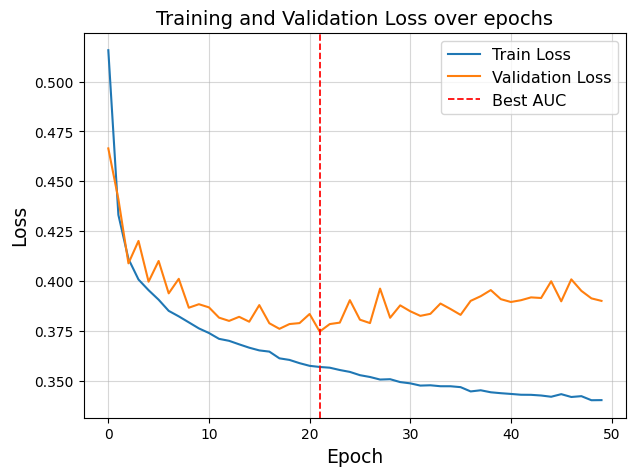

In [16]:
with open("Vanilla_LSTM/Final_training_losses_Level_2_model_15_September.json","r") as f:
    data = json.load(f)

plt.figure(figsize=(7,5))
epochs= np.arange(len(data["train_losses"]))
plt.plot(epochs,data["train_losses"], label="Train Loss")
plt.plot(epochs,data["val_losses"], label="Validation Loss")
plt.xlabel("Epoch",fontsize=13.5)
plt.ylabel("Loss",fontsize=13.5)
plt.axvline(x=21,color='red', linestyle='--', linewidth=1.25,label="Best AUC")
plt.title("Training and Validation Loss over epochs",fontsize=14)
plt.legend(fontsize=11.5)
plt.grid(True,alpha=0.5)
plt.savefig("vanilla_LSTM_attention_level2_losses.pdf", dpi=400, bbox_inches="tight")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:05<00:00, 49.96it/s]


Test set Loss: 0.21617695689201355, ROC AUC: 0.965197053720304


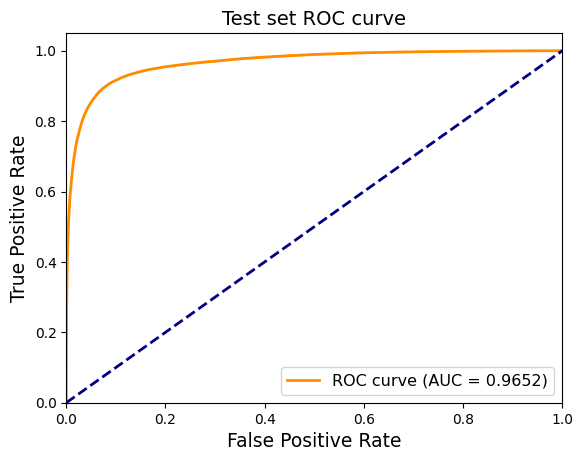

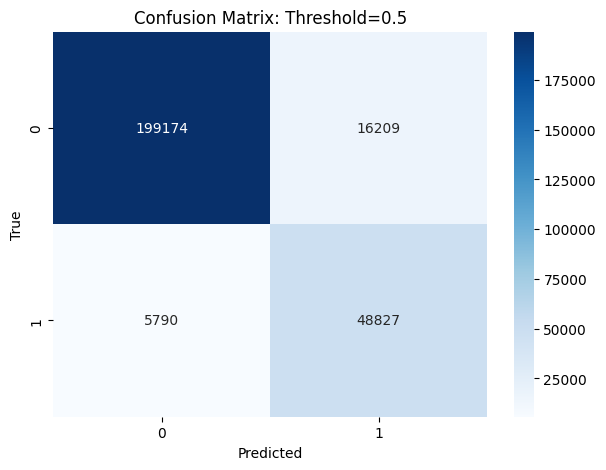

With threshold=0.5: Test set Accuracy: 0.9185, Precision: 0.7508, Recall: 0.8940, F1 score: 0.8161 



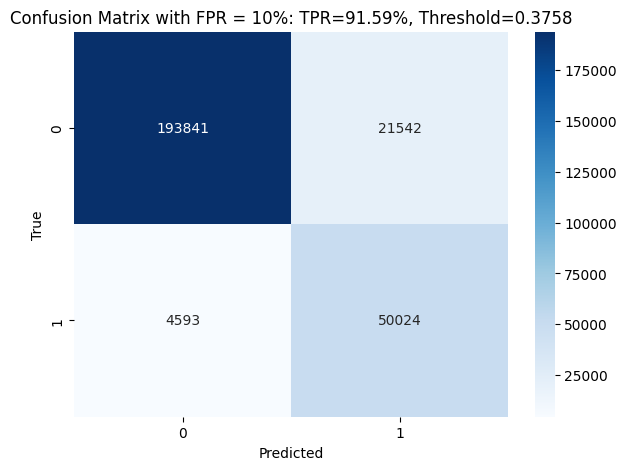

With threshold=0.3758: Test set Accuracy: 0.9032, Precision: 0.6990, Recall: 0.9159, F1 score: 0.7929 



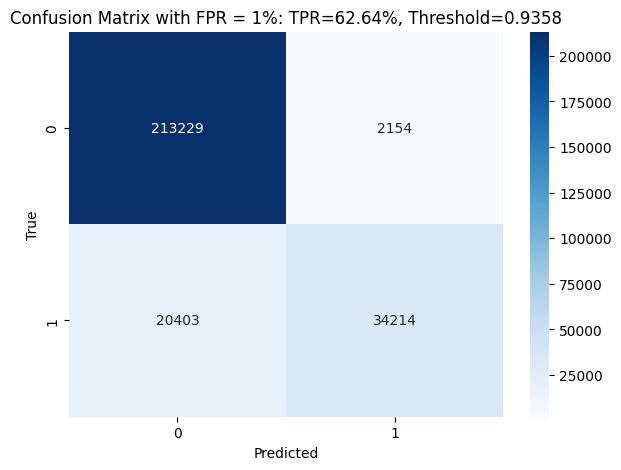

With threshold=0.9358: Test set Accuracy: 0.9165, Precision: 0.9408, Recall: 0.6264, F1 score: 0.7521 



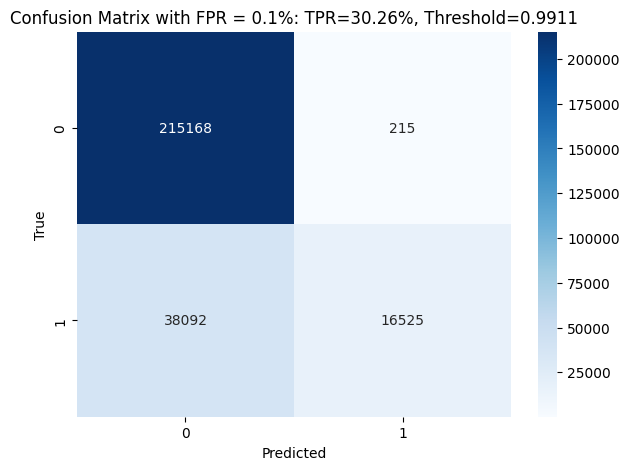

With threshold=0.9911: Test set Accuracy: 0.8581, Precision: 0.9872, Recall: 0.3026, F1 score: 0.4632 

Background rejection at TPR=30%: 1/FPR = 1025.6333 (FPR=0.0010)
Background rejection at TPR=50%: 1/FPR = 231.5946 (FPR=0.0043)


In [17]:
model.load_state_dict(torch.load("Vanilla_LSTM/Level_2_model_final_training_15_September.pt", map_location=device))
evaluate_network(test_dataloader,model,1.0, "Test set")

In [8]:
model = JetTaggerLSTM(
    hidden_size=45,
    num_layers=1,
    input_size=15,         
    num_classes=1)
print(f"Params number of the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Params number of the model: 11252


## Multi-Layer LSTM: hyper-parameter grid search with K-fold cross validation

We use Optuna to fine-tune a general multi-layer LSTM model with attention. We look for the best values for the number of layers, the hidden dimension of the layers, the penalization weight and learning rate.

In [15]:
import optuna
import os
from torch.utils.data import Subset
from sklearn.model_selection import KFold
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score,confusion_matrix

def objective(trial):
    
    # hyperparameters to optimize
    hidden_size = trial.suggest_categorical("hidden_size", [8,12,16,20,24,28,32,36,40,44,48]) 
    num_layers = trial.suggest_categorical("num_layers",[1,2,3,4]) 
    learning_rate = trial.suggest_float("lr",1e-5, 1e-2,log=True)
    pos_weight = trial.suggest_float("pos_weight",1.0,4.0)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = JetTaggerLSTM(hidden_size, num_layers).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate) # Adam alg for loss minimization

    max_epochs = 50
    patience = 10
    k=3
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)


    fold_accuracies = []
    fold_aucs = []

    for fold, (train_idx, val_idx) in tqdm(enumerate(kfold.split(features)), total=k, desc=f"Trial {trial.number}"):
        # split data into training and validation
        train_subset = Subset(full_train_dataset, train_idx)
        val_subset = Subset(full_train_dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # model
        model = JetTaggerLSTM(hidden_size, num_layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

        best_val_loss = float('inf')
        best_val_acc = 0.0
        
        no_improve = 0

        # train with early stopping
        for epoch in range(max_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.unsqueeze(1).to(device)

                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

            # validate
            model.eval()
            val_preds = []
            val_trues = []
            with torch.no_grad():
                for x_batch, y_batch in val_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.unsqueeze(1).to(device)
                    preds = model(x_batch)
                    val_preds.append(preds)
                    val_trues.append(y_batch)

            val_preds = torch.cat(val_preds)
            val_trues = torch.cat(val_trues)
            val_loss = criterion(val_preds, val_trues).item()
            val_acc = (torch.sigmoid(val_preds).round() == val_trues).float().mean().item()
            val_auc = roc_auc_score(val_trues, val_preds)

            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                best_val_acc = val_acc 
                best_val_auc = val_auc
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break  # early stopping
        print(f"Trial {trial.number} | Fold {fold+1}: Val AUC= {best_val_auc:.4f}, Val Acc= {best_val_acc:.4f}")
        
        fold_accuracies.append(best_val_acc) # store the best accuracy/auc during the training of the fold
        fold_aucs.append(best_val_auc)
        
    avg_val_acc = sum(fold_accuracies)/len(fold_accuracies)
    std_val_acc = np.std(fold_accuracies, ddof=1)
    avg_val_auc = sum(fold_aucs)/len(fold_aucs)
    std_val_auc = np.std(fold_aucs, ddof=1)
    
    print(f"Trial {trial.number} |Mean Val AUC: {avg_val_auc:.4f} +- {std_val_auc:.4f}, Mean Val Accuracy: {avg_val_acc:.4f} +- {std_val_acc:.4f} | hidden size: {hidden_size}, lr: {learning_rate:.5f}, Layers: {num_layers}, pos_weight: {pos_weight:.2f}")
    # save trial weights
    os.makedirs("optuna_LSTM_attention_grid_search_models", exist_ok=True)
    trial_model_path = f"optuna_LSTM_attention_grid_search_models/28_July_trial_{trial.number}.pt"
    torch.save(model.state_dict(), trial_model_path)
    trial.set_user_attr("model_path", trial_model_path)
    trial.set_user_attr("val_accuracy", avg_val_acc)

    return avg_val_auc  # optuna will maximize avg val AUC


In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="Jet_Tagger_LSTM_attention_grid_search_28_July",
    storage="sqlite:///optuna_jet_tagger_LSTM_attention_28_July.db",  # file to store the trials
    load_if_exists=True)
study.optimize(objective, n_trials=45)

[I 2025-07-28 20:16:13,535] A new study created in RDB with name: Jet_Tagger_LSTM_attention_grid_search_28_July
Trial 0:  33%|████████████████████████▋                                                 | 1/3 [17:27<34:55, 1047.83s/it]

Trial 0 | Fold 1: Val AUC= 0.9403, Val Acc= 0.9144


Trial 0:  67%|█████████████████████████████████████████████████▎                        | 2/3 [35:53<18:01, 1081.82s/it]

Trial 0 | Fold 2: Val AUC= 0.9418, Val Acc= 0.9141


Trial 0: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [53:39<00:00, 1073.24s/it]
[I 2025-07-28 21:09:53,316] Trial 0 finished with value: 0.9417437568870496 and parameters: {'hidden_size': 20, 'num_layers': 3, 'lr': 4.0634021398040774e-05, 'pos_weight': 1.772197408021489}. Best is trial 0 with value: 0.9417437568870496.


Trial 0 | Fold 3: Val AUC= 0.9432, Val Acc= 0.9166
Trial 0 |Mean Val AUC: 0.9417 +- 0.0015, Mean Val Accuracy: 0.915 +- 0.001 | hidden size: 20, lr: 0.00004, Layers: 3, pos_weight: 1.77


Trial 1:  33%|████████████████████████▋                                                 | 1/3 [20:33<41:07, 1233.71s/it]

Trial 1 | Fold 1: Val AUC= 0.9602, Val Acc= 0.9171


Trial 1:  67%|██████████████████████████████████████████████████                         | 2/3 [33:26<16:02, 962.73s/it]

Trial 1 | Fold 2: Val AUC= 0.9608, Val Acc= 0.9172


Trial 1: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [51:58<00:00, 1039.43s/it]
[I 2025-07-28 22:01:51,644] Trial 1 finished with value: 0.9604700391948908 and parameters: {'hidden_size': 36, 'num_layers': 3, 'lr': 0.00509771883114104, 'pos_weight': 2.561357565829987}. Best is trial 1 with value: 0.9604700391948908.


Trial 1 | Fold 3: Val AUC= 0.9604, Val Acc= 0.9228
Trial 1 |Mean Val AUC: 0.9605 +- 0.0003, Mean Val Accuracy: 0.919 +- 0.003 | hidden size: 36, lr: 0.00510, Layers: 3, pos_weight: 2.56


Trial 2:  33%|█████████████████████████                                                  | 1/3 [12:02<24:05, 722.79s/it]

Trial 2 | Fold 1: Val AUC= 0.9588, Val Acc= 0.9285


Trial 2:  67%|██████████████████████████████████████████████████                         | 2/3 [22:10<10:55, 655.25s/it]

Trial 2 | Fold 2: Val AUC= 0.9591, Val Acc= 0.9295


Trial 2: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [32:21<00:00, 647.33s/it]
[I 2025-07-28 22:34:13,667] Trial 2 finished with value: 0.9589906105579047 and parameters: {'hidden_size': 48, 'num_layers': 1, 'lr': 0.0001169988912253235, 'pos_weight': 1.180397174672706}. Best is trial 1 with value: 0.9604700391948908.


Trial 2 | Fold 3: Val AUC= 0.9591, Val Acc= 0.9298
Trial 2 |Mean Val AUC: 0.9590 +- 0.0002, Mean Val Accuracy: 0.929 +- 0.001 | hidden size: 48, lr: 0.00012, Layers: 1, pos_weight: 1.18


Trial 3:  33%|█████████████████████████                                                  | 1/3 [15:23<30:47, 923.67s/it]

Trial 3 | Fold 1: Val AUC= 0.9584, Val Acc= 0.9278


Trial 3:  67%|██████████████████████████████████████████████████                         | 2/3 [30:00<14:56, 896.11s/it]

Trial 3 | Fold 2: Val AUC= 0.9589, Val Acc= 0.9290


Trial 3: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [45:01<00:00, 900.67s/it]
[I 2025-07-28 23:19:15,708] Trial 3 finished with value: 0.9588471231176151 and parameters: {'hidden_size': 24, 'num_layers': 2, 'lr': 0.00015334166952324873, 'pos_weight': 1.2855599623811638}. Best is trial 1 with value: 0.9604700391948908.


Trial 3 | Fold 3: Val AUC= 0.9592, Val Acc= 0.9277
Trial 3 |Mean Val AUC: 0.9588 +- 0.0004, Mean Val Accuracy: 0.928 +- 0.001 | hidden size: 24, lr: 0.00015, Layers: 2, pos_weight: 1.29


Trial 4:  33%|████████████████████████▋                                                 | 1/3 [21:21<42:43, 1281.71s/it]

Trial 4 | Fold 1: Val AUC= 0.9585, Val Acc= 0.9186


Trial 4:  67%|█████████████████████████████████████████████████▎                        | 2/3 [50:28<25:55, 1555.35s/it]

Trial 4 | Fold 2: Val AUC= 0.9588, Val Acc= 0.9215


Trial 4: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [1:12:23<00:00, 1447.90s/it]
[I 2025-07-29 00:31:39,448] Trial 4 finished with value: 0.9586885645683875 and parameters: {'hidden_size': 28, 'num_layers': 4, 'lr': 0.00012080804140981281, 'pos_weight': 2.725014116573954}. Best is trial 1 with value: 0.9604700391948908.


Trial 4 | Fold 3: Val AUC= 0.9587, Val Acc= 0.9186
Trial 4 |Mean Val AUC: 0.9587 +- 0.0002, Mean Val Accuracy: 0.920 +- 0.002 | hidden size: 28, lr: 0.00012, Layers: 4, pos_weight: 2.73


Trial 5:  33%|████████████████████████▋                                                 | 1/3 [17:34<35:08, 1054.21s/it]

Trial 5 | Fold 1: Val AUC= 0.9274, Val Acc= 0.9053


Trial 5:  67%|██████████████████████████████████████████████████                         | 2/3 [33:01<16:19, 979.58s/it]

Trial 5 | Fold 2: Val AUC= 0.9307, Val Acc= 0.9068


Trial 5: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [48:18<00:00, 966.17s/it]
[I 2025-07-29 01:19:58,010] Trial 5 finished with value: 0.9294048431309809 and parameters: {'hidden_size': 8, 'num_layers': 4, 'lr': 2.253831877553478e-05, 'pos_weight': 2.1863177784312358}. Best is trial 1 with value: 0.9604700391948908.


Trial 5 | Fold 3: Val AUC= 0.9301, Val Acc= 0.9076
Trial 5 |Mean Val AUC: 0.9294 +- 0.0017, Mean Val Accuracy: 0.907 +- 0.001 | hidden size: 8, lr: 0.00002, Layers: 4, pos_weight: 2.19


Trial 6:  33%|█████████████████████████                                                  | 1/3 [06:05<12:11, 365.53s/it]

Trial 6 | Fold 1: Val AUC= 0.9354, Val Acc= 0.9095


Trial 6:  67%|██████████████████████████████████████████████████                         | 2/3 [12:34<06:19, 379.55s/it]

Trial 6 | Fold 2: Val AUC= 0.9346, Val Acc= 0.9078


Trial 6: 100%|███████████████████████████████████████████████████████████████████████████| 3/3 [19:17<00:00, 385.93s/it]
[I 2025-07-29 01:39:15,846] Trial 6 finished with value: 0.9340010490935882 and parameters: {'hidden_size': 16, 'num_layers': 1, 'lr': 2.1708275027805532e-05, 'pos_weight': 2.1262876333803074}. Best is trial 1 with value: 0.9604700391948908.


Trial 6 | Fold 3: Val AUC= 0.9320, Val Acc= 0.9078
Trial 6 |Mean Val AUC: 0.9340 +- 0.0018, Mean Val Accuracy: 0.908 +- 0.001 | hidden size: 16, lr: 0.00002, Layers: 1, pos_weight: 2.13


Trial 7:  33%|█████████████████████████                                                  | 1/3 [06:55<13:51, 415.82s/it]

Trial 7 | Fold 1: Val AUC= 0.9594, Val Acc= 0.9111


Trial 7:  67%|██████████████████████████████████████████████████                         | 2/3 [13:47<06:53, 413.26s/it]

Trial 7 | Fold 2: Val AUC= 0.9594, Val Acc= 0.9135


In [5]:
# reload study
study = optuna.create_study(
    direction="maximize",
    study_name="Jet_Tagger_LSTM_attention_grid_search_28_July",
    storage="sqlite:///optuna_jet_tagger_LSTM_attention_28_July.db",  # file to store the trials
    load_if_exists=True)
study.optimize(objective, n_trials=45)

[I 2025-07-29 07:47:08,238] Using an existing study with name 'Jet_Tagger_LSTM_attention_grid_search_28_July' instead of creating a new one.
Trial 11:  33%|████████████████████████▎                                                | 1/3 [19:20<38:40, 1160.15s/it]

Trial 11 | Fold 1: Val AUC= 0.9629, Val Acc= 0.9170


Trial 11:  67%|████████████████████████████████████████████████▋                        | 2/3 [41:45<21:09, 1269.28s/it]

Trial 11 | Fold 2: Val AUC= 0.9622, Val Acc= 0.9205


Trial 11: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:01:03<00:00, 1221.31s/it]
[I 2025-07-29 08:48:13,059] Trial 11 finished with value: 0.9625526834650628 and parameters: {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0007043788700240678, 'pos_weight': 3.3299512783358676}. Best is trial 9 with value: 0.9629696572808616.


Trial 11 | Fold 3: Val AUC= 0.9626, Val Acc= 0.9215
Trial 11 |Mean Val AUC: 0.963 +- 0.000, Mean Val Accuracy: 0.920 +- 0.002 | hidden size: 48, lr: 0.00070, Layers: 4, pos_weight: 3.33


Trial 12:  33%|████████████████████████▎                                                | 1/3 [19:34<39:09, 1174.57s/it]

Trial 12 | Fold 1: Val AUC= 0.9619, Val Acc= 0.9167


Trial 12:  67%|████████████████████████████████████████████████▋                        | 2/3 [37:06<18:22, 1102.21s/it]

Trial 12 | Fold 2: Val AUC= 0.9625, Val Acc= 0.9202


Trial 12: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [54:37<00:00, 1092.53s/it]
[I 2025-07-29 09:42:50,705] Trial 12 finished with value: 0.9625501244384532 and parameters: {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0007634659370515533, 'pos_weight': 3.30970144774736}. Best is trial 9 with value: 0.9629696572808616.


Trial 12 | Fold 3: Val AUC= 0.9633, Val Acc= 0.9188
Trial 12 |Mean Val AUC: 0.963 +- 0.001, Mean Val Accuracy: 0.919 +- 0.002 | hidden size: 48, lr: 0.00076, Layers: 4, pos_weight: 3.31


Trial 13:  33%|████████████████████████▋                                                 | 1/3 [15:17<30:35, 917.54s/it]

Trial 13 | Fold 1: Val AUC= 0.9613, Val Acc= 0.9164


Trial 13:  67%|█████████████████████████████████████████████████▎                        | 2/3 [27:01<13:11, 791.93s/it]

Trial 13 | Fold 2: Val AUC= 0.9607, Val Acc= 0.9170


Trial 13: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [42:31<00:00, 850.62s/it]
[I 2025-07-29 10:25:22,621] Trial 13 finished with value: 0.9612206436531805 and parameters: {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0022352559083197564, 'pos_weight': 3.1246208363817267}. Best is trial 9 with value: 0.9629696572808616.


Trial 13 | Fold 3: Val AUC= 0.9616, Val Acc= 0.9157
Trial 13 |Mean Val AUC: 0.961 +- 0.000, Mean Val Accuracy: 0.916 +- 0.001 | hidden size: 48, lr: 0.00224, Layers: 4, pos_weight: 3.12


Trial 14:  33%|████████████████████████▎                                                | 1/3 [25:59<51:59, 1559.52s/it]

Trial 14 | Fold 1: Val AUC= 0.9623, Val Acc= 0.9150


Trial 14:  67%|████████████████████████████████████████████████▋                        | 2/3 [51:01<25:25, 1525.67s/it]

Trial 14 | Fold 2: Val AUC= 0.9619, Val Acc= 0.9153


Trial 14: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:10:50<00:00, 1416.85s/it]
[I 2025-07-29 11:36:13,230] Trial 14 finished with value: 0.9624984336500502 and parameters: {'hidden_size': 32, 'num_layers': 4, 'lr': 0.00045270612746125275, 'pos_weight': 3.8525031695960505}. Best is trial 9 with value: 0.9629696572808616.


Trial 14 | Fold 3: Val AUC= 0.9633, Val Acc= 0.9180
Trial 14 |Mean Val AUC: 0.962 +- 0.001, Mean Val Accuracy: 0.916 +- 0.002 | hidden size: 32, lr: 0.00045, Layers: 4, pos_weight: 3.85


Trial 15:  33%|████████████████████████▋                                                 | 1/3 [07:12<14:24, 432.20s/it]

Trial 15 | Fold 1: Val AUC= 0.9610, Val Acc= 0.9170


Trial 15:  67%|█████████████████████████████████████████████████▎                        | 2/3 [14:38<07:20, 440.31s/it]

Trial 15 | Fold 2: Val AUC= 0.9621, Val Acc= 0.9204


Trial 15: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [23:52<00:00, 477.59s/it]
[I 2025-07-29 12:00:06,068] Trial 15 finished with value: 0.9616972160804652 and parameters: {'hidden_size': 40, 'num_layers': 2, 'lr': 0.0023247039315477513, 'pos_weight': 3.066902637421937}. Best is trial 9 with value: 0.9629696572808616.


Trial 15 | Fold 3: Val AUC= 0.9619, Val Acc= 0.9220
Trial 15 |Mean Val AUC: 0.962 +- 0.001, Mean Val Accuracy: 0.920 +- 0.003 | hidden size: 40, lr: 0.00232, Layers: 2, pos_weight: 3.07


Trial 16:  33%|████████████████████████▎                                                | 1/3 [20:10<40:20, 1210.12s/it]

Trial 16 | Fold 1: Val AUC= 0.9624, Val Acc= 0.9145


Trial 16:  67%|████████████████████████████████████████████████▋                        | 2/3 [42:27<21:24, 1284.95s/it]

Trial 16 | Fold 2: Val AUC= 0.9625, Val Acc= 0.9172


Trial 16: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:04:24<00:00, 1288.13s/it]
[I 2025-07-29 13:04:30,518] Trial 16 finished with value: 0.9627613124150473 and parameters: {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0002760409472907316, 'pos_weight': 3.567834441151483}. Best is trial 9 with value: 0.9629696572808616.


Trial 16 | Fold 3: Val AUC= 0.9634, Val Acc= 0.9141
Trial 16 |Mean Val AUC: 0.963 +- 0.001, Mean Val Accuracy: 0.915 +- 0.002 | hidden size: 48, lr: 0.00028, Layers: 4, pos_weight: 3.57


Trial 17:  33%|████████████████████████▎                                                | 1/3 [20:17<40:34, 1217.16s/it]

Trial 17 | Fold 1: Val AUC= 0.9626, Val Acc= 0.9203


Trial 17:  67%|████████████████████████████████████████████████▋                        | 2/3 [40:46<20:24, 1224.05s/it]

Trial 17 | Fold 2: Val AUC= 0.9622, Val Acc= 0.9242


Trial 17: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:00:38<00:00, 1212.82s/it]
[I 2025-07-29 14:05:09,030] Trial 17 finished with value: 0.9625651740819773 and parameters: {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0002620894825091021, 'pos_weight': 2.8488037764321805}. Best is trial 9 with value: 0.9629696572808616.


Trial 17 | Fold 3: Val AUC= 0.9629, Val Acc= 0.9252
Trial 17 |Mean Val AUC: 0.963 +- 0.000, Mean Val Accuracy: 0.923 +- 0.003 | hidden size: 48, lr: 0.00026, Layers: 4, pos_weight: 2.85


Trial 18:  33%|████████████████████████▎                                                | 1/3 [19:20<38:40, 1160.24s/it]

Trial 18 | Fold 1: Val AUC= 0.9359, Val Acc= 0.8927


Trial 18:  33%|███████████████████████▋                                               | 1/3 [37:45<1:15:31, 2265.72s/it]
[W 2025-07-29 14:42:54,791] Trial 18 failed with parameters: {'hidden_size': 36, 'num_layers': 4, 'lr': 1.050449315386168e-05, 'pos_weight': 3.596868876261631} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_3117600/1922285705.py", line 70, in objective
    preds = model(x_batch)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1751, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/home/ubuntu/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1762, in _call_impl
    return forward_call(*args, **kwargs)
  File "/tmp/ipykernel_3117600/3244126329.py", line 18, in forward
    att_we

KeyboardInterrupt: 

In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="Jet_Tagger_LSTM_attention_grid_search_28_July",
    storage="sqlite:///optuna_jet_tagger_LSTM_attention_28_July.db",  # file to store the trials
    load_if_exists=True)
study.optimize(objective, n_trials=45)

[I 2025-07-29 14:48:49,544] Using an existing study with name 'Jet_Tagger_LSTM_attention_grid_search_28_July' instead of creating a new one.
Trial 22:  33%|████████████████████████▋                                                 | 1/3 [15:30<31:01, 930.59s/it]

Trial 22 | Fold 1: Val AUC= 0.9609, Val Acc= 0.9082


Trial 22:  67%|█████████████████████████████████████████████████▎                        | 2/3 [28:46<14:11, 851.40s/it]

Trial 22 | Fold 2: Val AUC= 0.9610, Val Acc= 0.9168


Trial 22: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [41:22<00:00, 827.55s/it]
[I 2025-07-29 15:30:12,275] Trial 22 finished with value: 0.961026264699678 and parameters: {'hidden_size': 36, 'num_layers': 4, 'lr': 0.00201688339040791, 'pos_weight': 3.535392491725056}. Best is trial 9 with value: 0.9629696572808616.


Trial 22 | Fold 3: Val AUC= 0.9612, Val Acc= 0.9149
Trial 22 |Mean Val AUC: 0.9610 +- 0.0001, Mean Val Accuracy: 0.9133 +- 0.0045 | hidden size: 36, lr: 0.00202, Layers: 4, pos_weight: 3.54


Trial 23:  33%|████████████████████████▋                                                 | 1/3 [11:15<22:30, 675.31s/it]

Trial 23 | Fold 1: Val AUC= 0.9612, Val Acc= 0.9151


Trial 23:  67%|█████████████████████████████████████████████████▎                        | 2/3 [22:13<11:05, 665.33s/it]

Trial 23 | Fold 2: Val AUC= 0.9623, Val Acc= 0.9088


Trial 23: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [35:22<00:00, 707.51s/it]
[I 2025-07-29 16:05:34,871] Trial 23 finished with value: 0.9616652269419427 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.00027492533898188914, 'pos_weight': 3.699314297766872}. Best is trial 9 with value: 0.9629696572808616.


Trial 23 | Fold 3: Val AUC= 0.9615, Val Acc= 0.9143
Trial 23 |Mean Val AUC: 0.9617 +- 0.0006, Mean Val Accuracy: 0.9127 +- 0.0034 | hidden size: 32, lr: 0.00027, Layers: 2, pos_weight: 3.70


Trial 24:  33%|████████████████████████▋                                                 | 1/3 [14:58<29:56, 898.13s/it]

Trial 24 | Fold 1: Val AUC= 0.9434, Val Acc= 0.9153


Trial 24:  67%|█████████████████████████████████████████████████▎                        | 2/3 [30:42<15:25, 925.16s/it]

Trial 24 | Fold 2: Val AUC= 0.9456, Val Acc= 0.9116


Trial 24: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [45:44<00:00, 914.99s/it]
[I 2025-07-29 16:51:19,885] Trial 24 finished with value: 0.9469652785774002 and parameters: {'hidden_size': 16, 'num_layers': 3, 'lr': 6.650209816960944e-05, 'pos_weight': 2.2600719637797315}. Best is trial 9 with value: 0.9629696572808616.


Trial 24 | Fold 3: Val AUC= 0.9519, Val Acc= 0.9156
Trial 24 |Mean Val AUC: 0.9470 +- 0.0044, Mean Val Accuracy: 0.9142 +- 0.0022 | hidden size: 16, lr: 0.00007, Layers: 3, pos_weight: 2.26


Trial 25:  33%|████████████████████████▎                                                | 1/3 [20:20<40:40, 1220.06s/it]

Trial 25 | Fold 1: Val AUC= 0.9331, Val Acc= 0.8965


Trial 25:  67%|████████████████████████████████████████████████▋                        | 2/3 [43:56<22:15, 1335.74s/it]

Trial 25 | Fold 2: Val AUC= 0.9346, Val Acc= 0.8955


Trial 25: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:03:54<00:00, 1278.25s/it]
[I 2025-07-29 17:55:14,688] Trial 25 finished with value: 0.9334177233440041 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 1.1808202651601242e-05, 'pos_weight': 3.919042325051664}. Best is trial 9 with value: 0.9629696572808616.


Trial 25 | Fold 3: Val AUC= 0.9326, Val Acc= 0.8911
Trial 25 |Mean Val AUC: 0.9334 +- 0.0011, Mean Val Accuracy: 0.8944 +- 0.0029 | hidden size: 20, lr: 0.00001, Layers: 4, pos_weight: 3.92


Trial 26:   0%|                                                                                   | 0/3 [00:00<?, ?it/s]

In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="Jet_Tagger_LSTM_attention_grid_search_28_July",
    storage="sqlite:///optuna_jet_tagger_LSTM_attention_28_July.db",  # file to store the trials
    load_if_exists=True)
study.optimize(objective, n_trials=45)

[I 2025-07-29 18:40:53,870] Using an existing study with name 'Jet_Tagger_LSTM_attention_grid_search_28_July' instead of creating a new one.
Trial 29:  33%|███████████████████████▋                                               | 1/3 [37:02<1:14:05, 2222.79s/it]

Trial 29 | Fold 1: Val AUC= 0.9623, Val Acc= 0.9142


Trial 29:  67%|███████████████████████████████████████████████▎                       | 2/3 [1:12:48<36:17, 2177.24s/it]

Trial 29 | Fold 2: Val AUC= 0.9620, Val Acc= 0.9231


Trial 29: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:46:40<00:00, 2133.41s/it]
[I 2025-07-29 20:27:34,978] Trial 29 finished with value: 0.9625811531615204 and parameters: {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0002511159759672883, 'pos_weight': 2.91900806566107}. Best is trial 9 with value: 0.9629696572808616.


Trial 29 | Fold 3: Val AUC= 0.9635, Val Acc= 0.9229
Trial 29 |Mean Val AUC: 0.9626 +- 0.0008, Mean Val Accuracy: 0.9201 +- 0.0051 | hidden size: 48, lr: 0.00025, Layers: 4, pos_weight: 2.92


Trial 30:  33%|███████████████████████▋                                               | 1/3 [35:10<1:10:20, 2110.34s/it]

Trial 30 | Fold 1: Val AUC= 0.9622, Val Acc= 0.9162


Trial 30:  67%|███████████████████████████████████████████████▎                       | 2/3 [1:10:54<35:30, 2130.45s/it]

Trial 30 | Fold 2: Val AUC= 0.9631, Val Acc= 0.9237


Trial 30: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:47:20<00:00, 2146.83s/it]
[I 2025-07-29 22:14:55,519] Trial 30 finished with value: 0.962693935184021 and parameters: {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0003238742767198582, 'pos_weight': 2.9482511071319744}. Best is trial 9 with value: 0.9629696572808616.


Trial 30 | Fold 3: Val AUC= 0.9628, Val Acc= 0.9220
Trial 30 |Mean Val AUC: 0.9627 +- 0.0004, Mean Val Accuracy: 0.9207 +- 0.0039 | hidden size: 48, lr: 0.00032, Layers: 4, pos_weight: 2.95


Trial 31:  33%|████████████████████████▎                                                | 1/3 [28:23<56:46, 1703.26s/it]

Trial 31 | Fold 1: Val AUC= 0.9624, Val Acc= 0.9139


Trial 31:  67%|████████████████████████████████████████████████▋                        | 2/3 [57:07<28:35, 1715.40s/it]

Trial 31 | Fold 2: Val AUC= 0.9633, Val Acc= 0.9215


Trial 31: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:27:04<00:00, 1741.39s/it]
[I 2025-07-29 23:41:59,754] Trial 31 finished with value: 0.9623278587994538 and parameters: {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0013364615542951301, 'pos_weight': 3.373440749350367}. Best is trial 9 with value: 0.9629696572808616.


Trial 31 | Fold 3: Val AUC= 0.9613, Val Acc= 0.9145
Trial 31 |Mean Val AUC: 0.9623 +- 0.0010, Mean Val Accuracy: 0.9166 +- 0.0042 | hidden size: 48, lr: 0.00134, Layers: 4, pos_weight: 3.37


Trial 32:  33%|████████████████████████▎                                                | 1/3 [18:45<37:31, 1125.81s/it]

Trial 32 | Fold 1: Val AUC= 0.9595, Val Acc= 0.9196


Trial 32:  67%|████████████████████████████████████████████████▋                        | 2/3 [37:49<18:56, 1136.10s/it]

Trial 32 | Fold 2: Val AUC= 0.9598, Val Acc= 0.9249


Trial 32: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [54:52<00:00, 1097.51s/it]
[I 2025-07-30 00:36:52,345] Trial 32 finished with value: 0.9593739455933274 and parameters: {'hidden_size': 12, 'num_layers': 4, 'lr': 0.0004062865379775455, 'pos_weight': 2.4282455515620245}. Best is trial 9 with value: 0.9629696572808616.


Trial 32 | Fold 3: Val AUC= 0.9588, Val Acc= 0.9207
Trial 32 |Mean Val AUC: 0.9594 +- 0.0005, Mean Val Accuracy: 0.9217 +- 0.0028 | hidden size: 12, lr: 0.00041, Layers: 4, pos_weight: 2.43


Trial 33:  33%|████████████████████████▎                                                | 1/3 [27:06<54:12, 1626.34s/it]

Trial 33 | Fold 1: Val AUC= 0.9609, Val Acc= 0.9180


Trial 33:  67%|████████████████████████████████████████████████▋                        | 2/3 [54:15<27:08, 1628.21s/it]

Trial 33 | Fold 2: Val AUC= 0.9602, Val Acc= 0.9209


In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="Jet_Tagger_LSTM_attention_grid_search_28_July",
    storage="sqlite:///optuna_jet_tagger_LSTM_attention_28_July.db",  # file to store the trials
    load_if_exists=True)
study.optimize(objective, n_trials=45)

[I 2025-07-30 10:14:09,869] Using an existing study with name 'Jet_Tagger_LSTM_attention_grid_search_28_July' instead of creating a new one.
Trial 37:  33%|████████████████████████▋                                                 | 1/3 [12:21<24:43, 741.55s/it]

Trial 37 | Fold 1: Val AUC= 0.9624, Val Acc= 0.9303


Trial 37:  67%|█████████████████████████████████████████████████▎                        | 2/3 [25:17<12:41, 761.52s/it]

Trial 37 | Fold 2: Val AUC= 0.9623, Val Acc= 0.9306


Trial 37: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [37:20<00:00, 746.98s/it]
[I 2025-07-30 10:51:31,975] Trial 37 finished with value: 0.9625812124636539 and parameters: {'hidden_size': 40, 'num_layers': 2, 'lr': 0.0004213303188662943, 'pos_weight': 1.8626430322824143}. Best is trial 9 with value: 0.9629696572808616.


Trial 37 | Fold 3: Val AUC= 0.9631, Val Acc= 0.9299
Trial 37 |Mean Val AUC: 0.9626 +- 0.0005, Mean Val Accuracy: 0.9303 +- 0.0003 | hidden size: 40, lr: 0.00042, Layers: 2, pos_weight: 1.86


Trial 38:  33%|████████████████████████▎                                                | 1/3 [23:31<47:02, 1411.04s/it]

Trial 38 | Fold 1: Val AUC= 0.9532, Val Acc= 0.9042


Trial 38:  67%|████████████████████████████████████████████████▋                        | 2/3 [46:55<23:27, 1407.02s/it]

Trial 38 | Fold 2: Val AUC= 0.9564, Val Acc= 0.9149


Trial 38: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:08:22<00:00, 1367.41s/it]
[I 2025-07-30 11:59:54,252] Trial 38 finished with value: 0.9554396988088892 and parameters: {'hidden_size': 28, 'num_layers': 3, 'lr': 7.186740506772842e-05, 'pos_weight': 3.5111557979266665}. Best is trial 9 with value: 0.9629696572808616.


Trial 38 | Fold 3: Val AUC= 0.9567, Val Acc= 0.9116
Trial 38 |Mean Val AUC: 0.9554 +- 0.0020, Mean Val Accuracy: 0.9102 +- 0.0055 | hidden size: 28, lr: 0.00007, Layers: 3, pos_weight: 3.51


Trial 39:  33%|████████████████████████▎                                                | 1/3 [21:40<43:20, 1300.17s/it]

Trial 39 | Fold 1: Val AUC= 0.9428, Val Acc= 0.9002


Trial 39:  67%|████████████████████████████████████████████████▋                        | 2/3 [45:05<22:41, 1361.86s/it]

Trial 39 | Fold 2: Val AUC= 0.9420, Val Acc= 0.9059


Trial 39: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:05:58<00:00, 1319.65s/it]
[I 2025-07-30 13:05:53,259] Trial 39 finished with value: 0.9418254524687882 and parameters: {'hidden_size': 20, 'num_layers': 4, 'lr': 3.891008143758803e-05, 'pos_weight': 3.2667018329865067}. Best is trial 9 with value: 0.9629696572808616.


Trial 39 | Fold 3: Val AUC= 0.9407, Val Acc= 0.9068
Trial 39 |Mean Val AUC: 0.9418 +- 0.0011, Mean Val Accuracy: 0.9043 +- 0.0036 | hidden size: 20, lr: 0.00004, Layers: 4, pos_weight: 3.27


Trial 40:  33%|████████████████████████▎                                                | 1/3 [17:45<35:30, 1065.30s/it]

Trial 40 | Fold 1: Val AUC= 0.9619, Val Acc= 0.9297


Trial 40:  67%|████████████████████████████████████████████████▋                        | 2/3 [35:17<17:37, 1057.40s/it]

Trial 40 | Fold 2: Val AUC= 0.9618, Val Acc= 0.9313


Trial 40: 100%|█████████████████████████████████████████████████████████████████████████| 3/3 [54:31<00:00, 1090.63s/it]
[I 2025-07-30 14:00:25,227] Trial 40 finished with value: 0.9622359795692835 and parameters: {'hidden_size': 40, 'num_layers': 2, 'lr': 0.0005302164633444195, 'pos_weight': 1.746791120532428}. Best is trial 9 with value: 0.9629696572808616.


Trial 40 | Fold 3: Val AUC= 0.9631, Val Acc= 0.9314
Trial 40 |Mean Val AUC: 0.9622 +- 0.0007, Mean Val Accuracy: 0.9308 +- 0.0009 | hidden size: 40, lr: 0.00053, Layers: 2, pos_weight: 1.75


Trial 41:  33%|████████████████████████▎                                                | 1/3 [20:44<41:29, 1244.64s/it]

Trial 41 | Fold 1: Val AUC= 0.9625, Val Acc= 0.9271


Trial 41:  67%|████████████████████████████████████████████████▋                        | 2/3 [41:10<20:33, 1233.82s/it]

Trial 41 | Fold 2: Val AUC= 0.9623, Val Acc= 0.9263


Trial 41: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:01:41<00:00, 1233.92s/it]
[I 2025-07-30 15:02:07,054] Trial 41 finished with value: 0.9624550999837208 and parameters: {'hidden_size': 48, 'num_layers': 2, 'lr': 0.00020224460933798903, 'pos_weight': 2.0380972037219616}. Best is trial 9 with value: 0.9629696572808616.


Trial 41 | Fold 3: Val AUC= 0.9625, Val Acc= 0.9279
Trial 41 |Mean Val AUC: 0.9625 +- 0.0001, Mean Val Accuracy: 0.9271 +- 0.0008 | hidden size: 48, lr: 0.00020, Layers: 2, pos_weight: 2.04


Trial 42:  33%|████████████████████████▎                                                | 1/3 [23:02<46:05, 1382.50s/it]

Trial 42 | Fold 1: Val AUC= 0.9622, Val Acc= 0.9297


Trial 42:  67%|████████████████████████████████████████████████▋                        | 2/3 [42:31<20:57, 1257.16s/it]

Trial 42 | Fold 2: Val AUC= 0.9621, Val Acc= 0.9294


Trial 42: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:01:16<00:00, 1225.56s/it]
[I 2025-07-30 16:03:23,792] Trial 42 finished with value: 0.962667289578274 and parameters: {'hidden_size': 40, 'num_layers': 2, 'lr': 0.00032938146129776703, 'pos_weight': 1.7641584117632798}. Best is trial 9 with value: 0.9629696572808616.


Trial 42 | Fold 3: Val AUC= 0.9636, Val Acc= 0.9298
Trial 42 |Mean Val AUC: 0.9627 +- 0.0008, Mean Val Accuracy: 0.9296 +- 0.0002 | hidden size: 40, lr: 0.00033, Layers: 2, pos_weight: 1.76


Trial 43:  33%|████████████████████████▎                                                | 1/3 [20:09<40:18, 1209.30s/it]

Trial 43 | Fold 1: Val AUC= 0.9583, Val Acc= 0.9275


Trial 43:  67%|████████████████████████████████████████████████▋                        | 2/3 [40:32<20:17, 1217.64s/it]

Trial 43 | Fold 2: Val AUC= 0.9586, Val Acc= 0.9272


Trial 43: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [1:01:05<00:00, 1221.75s/it]
[I 2025-07-30 17:04:29,107] Trial 43 finished with value: 0.9587794073994932 and parameters: {'hidden_size': 40, 'num_layers': 2, 'lr': 9.542877574066007e-05, 'pos_weight': 1.5213121954415774}. Best is trial 9 with value: 0.9629696572808616.


Trial 43 | Fold 3: Val AUC= 0.9594, Val Acc= 0.9274
Trial 43 |Mean Val AUC: 0.9588 +- 0.0005, Mean Val Accuracy: 0.9273 +- 0.0001 | hidden size: 40, lr: 0.00010, Layers: 2, pos_weight: 1.52


Trial 44:  33%|████████████████████████▋                                                 | 1/3 [11:31<23:02, 691.11s/it]

Trial 44 | Fold 1: Val AUC= 0.9609, Val Acc= 0.9219


Trial 44:  67%|█████████████████████████████████████████████████▎                        | 2/3 [23:10<11:36, 696.02s/it]

Trial 44 | Fold 2: Val AUC= 0.9613, Val Acc= 0.9261


Trial 44: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [35:23<00:00, 707.83s/it]
[I 2025-07-30 17:39:52,658] Trial 44 finished with value: 0.9608441751067089 and parameters: {'hidden_size': 36, 'num_layers': 2, 'lr': 0.00017557205321066795, 'pos_weight': 2.468206198295911}. Best is trial 9 with value: 0.9629696572808616.


Trial 44 | Fold 3: Val AUC= 0.9603, Val Acc= 0.9242
Trial 44 |Mean Val AUC: 0.9608 +- 0.0005, Mean Val Accuracy: 0.9241 +- 0.0021 | hidden size: 36, lr: 0.00018, Layers: 2, pos_weight: 2.47


Trial 45:  33%|████████████████████████▎                                                | 1/3 [18:01<36:03, 1081.59s/it]

Trial 45 | Fold 1: Val AUC= 0.9624, Val Acc= 0.9222


In [7]:
best_trial = study.best_trial
best_model_path = best_trial.user_attrs["model_path"]
params = best_trial.params
os.rename(best_model_path, "best_LSTM_attention_model_grid_search_28_July.pt") 
print(f"Best trial #{best_trial.number} best_LSTM_attention_model_grid_search_28_July.pt")
print("Best hyper-parameters", params)

Best trial #9 best_LSTM_attention_model_grid_search_28_July.pt
Best hyper-parameters {'hidden_size': 48, 'num_layers': 4, 'lr': 0.0003479899705442438, 'pos_weight': 3.0173954931292917}


## Final training on the whole training set of the best LSTM model found 

In [11]:
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score,confusion_matrix

# get best hyperparameters from previous grid search 
hidden_size = params["hidden_size"]
num_layers = params["num_layers"]
learning_rate = params["lr"]
pos_weight = params["pos_weight"]

model = JetTaggerLSTM(
    hidden_size=hidden_size,
    num_layers=num_layers,
    input_size=15,         
    num_classes=1         
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


scaler = GradScaler()
opt = Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean',pos_weight=pos_weight.to(device)) 

# train on entire training set 
epochs = 70
best_auc = 0

train_losses=[]
val_losses=[]

for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader) 

    epoch_train_loss = 0
    num_batches = 0

    for batch_x, batch_y in iterator:
   
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True)

        opt.zero_grad()
        with autocast(enabled=False):  # True for mixed precision
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        epoch_train_loss += loss.item()
        num_batches += 1
        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")
    
    avg_train_loss = epoch_train_loss/num_batches
    train_losses.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader): 
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True)

            logits = model(batch_x)
            predictions.append(logits)
            true.append(batch_y)
        predictions = torch.cat(predictions, dim=0)
        true = torch.cat(true, dim=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean() # assuming 0.5 as threshold
        val_auc = roc_auc_score(true,predictions)

        val_losses.append(val_loss.item())
        print(f"Validation loss: {val_loss.item()}, AUC: {val_auc}, Accuracy: {val_acc.item()}")

        # save model if it's the best so far
        if val_auc > best_auc:
            torch.save(model.state_dict(), "best_LSTM_attention_model_final_training_28_July.pt")
            print("saved best model")
            best_auc = val_auc

with open("final_training_losses_28_July.json", "w") as f:
    json.dump({"train_losses": train_losses,"val_losses": val_losses}, f)

Epoch: 1


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 192.81it/s]


Validation loss: 0.460970401763916, AUC: 0.9480381062314897, Accuracy: 0.8920164108276367
saved best model
Epoch: 2


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 207.40it/s]


Validation loss: 0.4266652464866638, AUC: 0.9551932440460792, Accuracy: 0.9129835963249207
saved best model
Epoch: 3


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 183.54it/s]


Validation loss: 0.4069439768791199, AUC: 0.9587083181598886, Accuracy: 0.913672149181366
saved best model
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 202.10it/s]


Validation loss: 0.4002060890197754, AUC: 0.9601047193891535, Accuracy: 0.9112786650657654
saved best model
Epoch: 5


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 226.37it/s]


Validation loss: 0.4095461368560791, AUC: 0.9604693191631092, Accuracy: 0.923245906829834
saved best model
Epoch: 6


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 204.68it/s]


Validation loss: 0.39919814467430115, AUC: 0.96044808592423, Accuracy: 0.9161147475242615
Epoch: 7


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 199.27it/s]


Validation loss: 0.39696329832077026, AUC: 0.9605133753084462, Accuracy: 0.9146393537521362
saved best model
Epoch: 8


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 171.16it/s]


Validation loss: 0.3886999785900116, AUC: 0.9630951101320034, Accuracy: 0.9210655689239502
saved best model
Epoch: 9


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 213.91it/s]


Validation loss: 0.39023643732070923, AUC: 0.9628826938140826, Accuracy: 0.9040491580963135
Epoch: 10


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 165.67it/s]


Validation loss: 0.38823840022087097, AUC: 0.9639415029986032, Accuracy: 0.9264426231384277
saved best model
Epoch: 11


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 169.10it/s]


Validation loss: 0.38062584400177, AUC: 0.9646754266762514, Accuracy: 0.9233114719390869
saved best model
Epoch: 12


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 212.09it/s]


Validation loss: 0.37497803568840027, AUC: 0.9653833879993949, Accuracy: 0.9115409851074219
saved best model
Epoch: 13


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 207.04it/s]


Validation loss: 0.3856132924556732, AUC: 0.9637603216127029, Accuracy: 0.9226557612419128
Epoch: 14


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 191.82it/s]


Validation loss: 0.37540939450263977, AUC: 0.9652265851172905, Accuracy: 0.9148688316345215
Epoch: 15


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 180.70it/s]


Validation loss: 0.3777843117713928, AUC: 0.9646022479538262, Accuracy: 0.9181803464889526
Epoch: 16


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 173.92it/s]


Validation loss: 0.3701598346233368, AUC: 0.9660676871247815, Accuracy: 0.9181803464889526
saved best model
Epoch: 17


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 198.83it/s]


Validation loss: 0.37838301062583923, AUC: 0.9646568941271954, Accuracy: 0.9221475124359131
Epoch: 18


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 237.53it/s]


Validation loss: 0.37517431378364563, AUC: 0.9656323143197967, Accuracy: 0.9085573554039001
Epoch: 19


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 200.61it/s]


Validation loss: 0.3703083395957947, AUC: 0.9661361591680816, Accuracy: 0.9168033003807068
saved best model
Epoch: 20


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 227.22it/s]


Validation loss: 0.37119269371032715, AUC: 0.966026915018269, Accuracy: 0.9223278760910034
Epoch: 21


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:06<00:00, 154.77it/s]


Validation loss: 0.36973515152931213, AUC: 0.9664187768017702, Accuracy: 0.9200491905212402
saved best model
Epoch: 22


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 199.00it/s]


Validation loss: 0.36750784516334534, AUC: 0.9664952154645574, Accuracy: 0.9161803126335144
saved best model
Epoch: 23


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 223.36it/s]


Validation loss: 0.3764455318450928, AUC: 0.9661781835636902, Accuracy: 0.9196885228157043
Epoch: 24


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 173.93it/s]


Validation loss: 0.36654481291770935, AUC: 0.9668623339433912, Accuracy: 0.9231639504432678
saved best model
Epoch: 25


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 206.41it/s]


Validation loss: 0.37230974435806274, AUC: 0.9666300812664657, Accuracy: 0.9250327944755554
Epoch: 26


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 220.11it/s]


Validation loss: 0.39657309651374817, AUC: 0.9638772656369459, Accuracy: 0.8910819888114929
Epoch: 27


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 171.76it/s]


Validation loss: 0.3726103901863098, AUC: 0.9659792349626805, Accuracy: 0.910229504108429
Epoch: 28


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 206.82it/s]


Validation loss: 0.3740474581718445, AUC: 0.9661524646867604, Accuracy: 0.920245885848999
Epoch: 29


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 222.55it/s]


Validation loss: 0.39214715361595154, AUC: 0.9634998031005992, Accuracy: 0.9012295007705688
Epoch: 30


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 227.68it/s]


Validation loss: 0.3728877305984497, AUC: 0.9659251588426092, Accuracy: 0.918049156665802
Epoch: 31


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 201.49it/s]


Validation loss: 0.3792669177055359, AUC: 0.9656369977314406, Accuracy: 0.923458993434906
Epoch: 32


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 198.60it/s]


Validation loss: 0.37789276242256165, AUC: 0.9655958043173157, Accuracy: 0.9234753847122192
Epoch: 33


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 207.97it/s]


Validation loss: 0.3762606978416443, AUC: 0.96535318099147, Accuracy: 0.9079999923706055
Epoch: 34


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 195.39it/s]


Validation loss: 0.37729325890541077, AUC: 0.9651032167751947, Accuracy: 0.9184098243713379
Epoch: 35


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 219.08it/s]


Validation loss: 0.38153785467147827, AUC: 0.9649481049404101, Accuracy: 0.9072130918502808
Epoch: 36


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 175.58it/s]


Validation loss: 0.38150838017463684, AUC: 0.9645517899271363, Accuracy: 0.9221967458724976
Epoch: 37


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 187.69it/s]


Validation loss: 0.3793845474720001, AUC: 0.9647903929645624, Accuracy: 0.9203934669494629
Epoch: 38


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 216.87it/s]


Validation loss: 0.3836447298526764, AUC: 0.9640922222652635, Accuracy: 0.9190492033958435
Epoch: 39


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 232.20it/s]


Validation loss: 0.38269755244255066, AUC: 0.9642255923005005, Accuracy: 0.920475423336029
Epoch: 40


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 216.07it/s]


Validation loss: 0.4011748731136322, AUC: 0.962177757263541, Accuracy: 0.9153770208358765
Epoch: 41


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 190.90it/s]


Validation loss: 0.39268603920936584, AUC: 0.9633642409362073, Accuracy: 0.9219835996627808
Epoch: 42


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 207.15it/s]


Validation loss: 0.38716667890548706, AUC: 0.9639137972449453, Accuracy: 0.9174590110778809
Epoch: 43


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:06<00:00, 150.77it/s]


Validation loss: 0.3939656615257263, AUC: 0.9628707343285651, Accuracy: 0.918049156665802
Epoch: 44


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 177.21it/s]


Validation loss: 0.40033257007598877, AUC: 0.9621030212818147, Accuracy: 0.9117704629898071
Epoch: 45


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 183.14it/s]


Validation loss: 0.39893820881843567, AUC: 0.9620333542871409, Accuracy: 0.9192786812782288
Epoch: 46


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 208.38it/s]


Validation loss: 0.4038752019405365, AUC: 0.9625369872351474, Accuracy: 0.9201311469078064
Epoch: 47


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:06<00:00, 151.93it/s]


Validation loss: 0.40515968203544617, AUC: 0.9614696737861194, Accuracy: 0.9154918193817139
Epoch: 48


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 174.08it/s]


Validation loss: 0.4183441698551178, AUC: 0.9600211816515485, Accuracy: 0.9183278679847717
Epoch: 49


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 234.34it/s]


Validation loss: 0.4084970951080322, AUC: 0.9613103322555814, Accuracy: 0.9084426164627075
Epoch: 50


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 176.50it/s]


Validation loss: 0.41173169016838074, AUC: 0.9615588223107043, Accuracy: 0.9202294945716858
Epoch: 51


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 223.69it/s]


Validation loss: 0.4203948378562927, AUC: 0.960939947188534, Accuracy: 0.9160655736923218
Epoch: 52


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 190.97it/s]


Validation loss: 0.41140642762184143, AUC: 0.961820435225422, Accuracy: 0.9097049236297607
Epoch: 53


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 215.65it/s]


Validation loss: 0.4227246940135956, AUC: 0.9611863971841136, Accuracy: 0.9175081849098206
Epoch: 54


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 194.89it/s]


Validation loss: 0.42403921484947205, AUC: 0.9600814909637312, Accuracy: 0.9159672260284424
Epoch: 55


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 224.81it/s]


Validation loss: 0.42713454365730286, AUC: 0.96057969926461, Accuracy: 0.9180983901023865
Epoch: 56


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 219.40it/s]


Validation loss: 0.4290288984775543, AUC: 0.9597820068988615, Accuracy: 0.9183114767074585
Epoch: 57


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 176.56it/s]


Validation loss: 0.42771729826927185, AUC: 0.9592287759900011, Accuracy: 0.9096229672431946
Epoch: 58


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 230.15it/s]


Validation loss: 0.4340338110923767, AUC: 0.9596673547215513, Accuracy: 0.9171147346496582
Epoch: 59


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 189.20it/s]


Validation loss: 0.42953768372535706, AUC: 0.9595023417423851, Accuracy: 0.9111967086791992
Epoch: 60


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 231.30it/s]


Validation loss: 0.4425530433654785, AUC: 0.9595299943132282, Accuracy: 0.9155246019363403
Epoch: 61


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 194.75it/s]


Validation loss: 0.45573103427886963, AUC: 0.9578096548959822, Accuracy: 0.9180819392204285
Epoch: 62


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 233.13it/s]


Validation loss: 0.4524460434913635, AUC: 0.958594539344118, Accuracy: 0.9171802997589111
Epoch: 63


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 196.36it/s]


Validation loss: 0.4499920606613159, AUC: 0.958648783322449, Accuracy: 0.9183114767074585
Epoch: 64


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 219.43it/s]


Validation loss: 0.45209747552871704, AUC: 0.9585162093674734, Accuracy: 0.9147868752479553
Epoch: 65


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 187.42it/s]


Validation loss: 0.4439574182033539, AUC: 0.9585361171908856, Accuracy: 0.9063770771026611
Epoch: 66


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:05<00:00, 187.88it/s]


Validation loss: 0.4725981056690216, AUC: 0.9559540690873087, Accuracy: 0.9123770594596863
Epoch: 67


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 222.13it/s]


Validation loss: 0.46422725915908813, AUC: 0.9572967440397072, Accuracy: 0.9125573635101318
Epoch: 68


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 193.48it/s]


Validation loss: 0.4566892385482788, AUC: 0.9565505218360961, Accuracy: 0.9065737724304199
Epoch: 69


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 198.52it/s]


Validation loss: 0.46457454562187195, AUC: 0.9566170352560381, Accuracy: 0.9123278856277466
Epoch: 70


100%|████████████████████████████████████████████████████████████████████████████████| 954/954 [00:04<00:00, 208.42it/s]

Validation loss: 0.46840208768844604, AUC: 0.9571365632178703, Accuracy: 0.9138032793998718


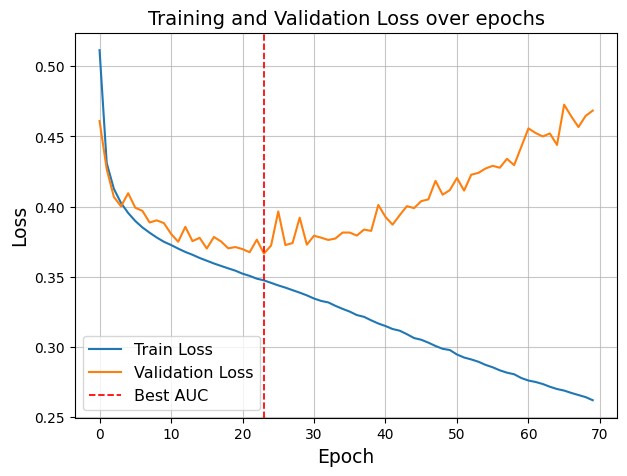

In [9]:
with open("final_training_losses_28_July.json","r") as f:
    data = json.load(f)

plt.figure(figsize=(7,5))
epochs= np.arange(len(data["train_losses"]))
plt.plot(epochs,data["train_losses"], label="Train Loss")
plt.plot(epochs,data["val_losses"], label="Validation Loss")
plt.axvline(x=23,color='red', linestyle='--', linewidth=1.25,label="Best AUC")
plt.xlabel("Epoch",fontsize=13.5)
plt.ylabel("Loss",fontsize=13.5)
plt.title("Training and Validation Loss over epochs",fontsize=14)
plt.legend(fontsize=11.5)
plt.grid(True,alpha=0.7)
plt.savefig("best_LSTM_attention_model_gridsearch_losses.pdf", dpi=400, bbox_inches="tight")
plt.show()

## Model evaluation on the test set 

100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:12<00:00, 21.50it/s]


Test set Loss: 0.3222685158252716, ROC AUC: 0.965976877737843


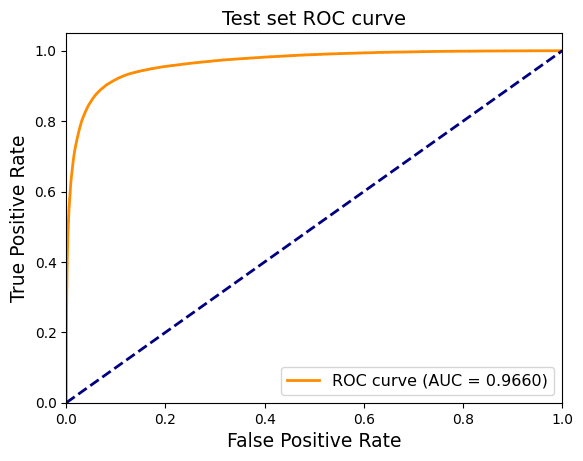

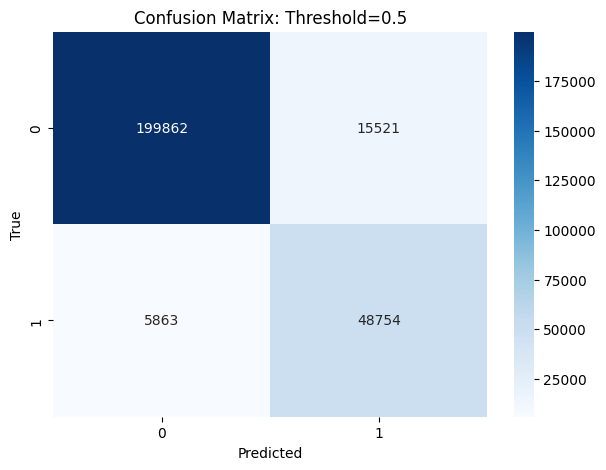

With threshold=0.5: Test set Accuracy: 0.9208, Precision: 0.7585, Recall: 0.8927, F1 score: 0.8201 



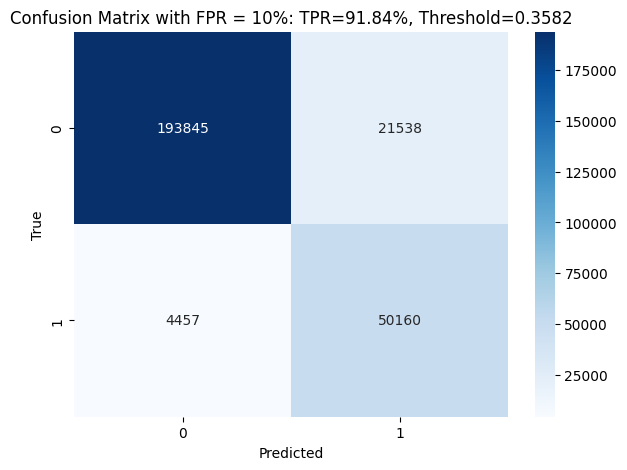

With threshold=0.3582: Test set Accuracy: 0.9037, Precision: 0.6996, Recall: 0.9184, F1 score: 0.7942 



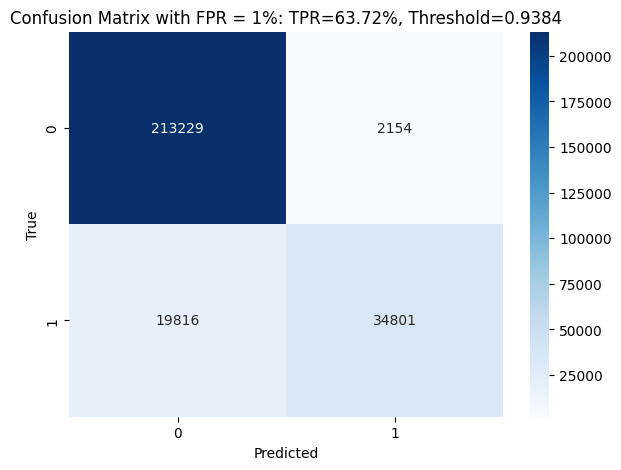

With threshold=0.9384: Test set Accuracy: 0.9186, Precision: 0.9417, Recall: 0.6372, F1 score: 0.7601 



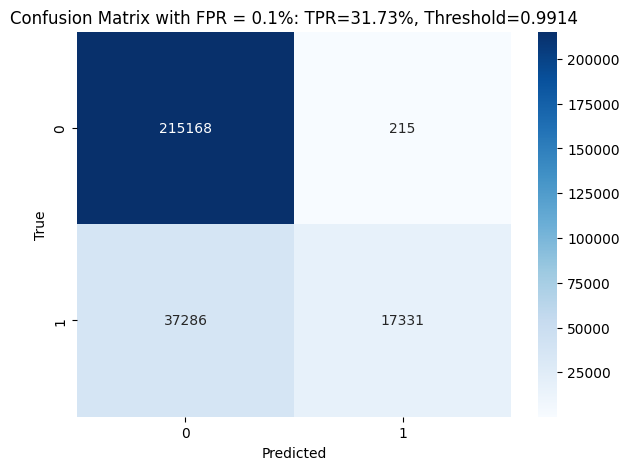

With threshold=0.9914: Test set Accuracy: 0.8611, Precision: 0.9877, Recall: 0.3173, F1 score: 0.4803 

Background rejection at TPR=30%: 1/FPR = 1170.5598 (FPR=0.0009)
Background rejection at TPR=50%: 1/FPR = 253.6902 (FPR=0.0039)


In [31]:
device='cpu'
model = JetTaggerLSTM(
    hidden_size=48,
    num_layers=4,
    input_size=15,    
    num_classes=1)

model.load_state_dict(torch.load("best_LSTM_attention_model_final_training_28_July.pt", map_location=device))
model.to(device)
evaluate_network(test_dataloader, model, data_split='Test set')

In [9]:
model = JetTaggerLSTM(
    hidden_size=48,
    num_layers=4,
    input_size=15,         
    num_classes=1)
print(f"Params number of the model:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Params number of the model: 69026


# XLSTM model

## Implementation from scratch of the mLSTM and sLSTM blocks

In [5]:
# mLSTM block definition

import math
import torch
import torch.nn as nn
import torch.nn.functional as F

class mLSTMBlock(nn.Module):
    def __init__(self,hidden_dim,input_dim=15,head_num=1,eps=1.0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.head_num = head_num
        self.head_size = hidden_dim//head_num
        self.eps = eps  # minimum denominator for normalization

        # projections and spliiting into heads 
        self.Wq = nn.Linear(input_dim, hidden_dim) # projects into query space (defines what information to retrieve from memory matrix at time t)
        self.Wk = nn.Linear(input_dim, hidden_dim) # projects into keys space (representation of a sort of address to define where to store the value v in the memory matrix)
        self.Wv = nn.Linear(input_dim, hidden_dim) # projects into values space (representation of "the content to store" at that address)

        # forget and input gates i,f (log-parameterized) and output gate 
        self.Wi = nn.Linear(input_dim, hidden_dim)
        self.Wf = nn.Linear(input_dim, hidden_dim)
        self.Wo = nn.Linear(input_dim, hidden_dim)

        # layerNorm before K/V as in paper
        self.ln_kv = nn.LayerNorm(input_dim) # to stabilize training by preventing exploding/vanishing activations

        # initialization
        for layer in [self.Wq, self.Wk, self.Wv, self.Wi, self.Wf, self.Wo]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        # forget gate bias init (stabilizes early training)
        nn.init.constant_(self.Wf.bias, 1.0)

    def forward(self, x, hidden=None):
        """
        x: (B, seq_len, input_dim)
        hidden: tuple of (C0, n0, m0)
            C0: (B, head_num, head_size, head_size)
            n0: (B, head_num, head_size)
            m0: (B, head_num, head_size)
        Returns:
            h_seq: (B, seq_len, hidden_dim)
            final_states: (C_T, n_T, m_T) """
        B,seq_len, _ = x.size()

        # initialize hidden states if not provided
        if hidden is None:
            C_t = torch.zeros(B, self.head_num, self.head_size, self.head_size, device=x.device) # matrix memory (richer memory than standard LSTM)
            n_t = torch.zeros(B, self.head_num, self.head_size, device=x.device) # normalizer state
            m_t = torch.zeros(B, self.head_num, self.head_size, device=x.device) # stabilizer state (prevents i and f from exploding or vanishing with exp gating)
        else:
            C_t, n_t, m_t = hidden

        # project inputs
        q = self.Wq(x).view(B, seq_len, self.head_num, self.head_size)

        # layerNorm before projecting to keys and values (we follow paper assumption); then scale keys
        x_kv = self.ln_kv(x)
        k = (self.Wk(x_kv) / math.sqrt(self.head_size)).view(B, seq_len, self.head_num, self.head_size)
        v = self.Wv(x_kv).view(B, seq_len, self.head_num, self.head_size)

        # log of inuput and forget gates (no exp yet)
        log_i = self.Wi(x).view(B, seq_len, self.head_num, self.head_size)
        log_f = self.Wf(x).view(B, seq_len, self.head_num, self.head_size)
        o_t   = torch.sigmoid(self.Wo(x)).view(B, seq_len, self.head_num, self.head_size)

        h_seq = []
        for t in range(seq_len):
            q_t = q[:, t, :, :]    # (B, head_num, head_size)
            k_t = k[:, t, :, :]
            v_t = v[:, t, :, :]
            log_i_t = log_i[:, t, :, :]
            log_f_t = log_f[:, t, :, :]
            o = o_t[:, t, :, :]

            # stabilizer update
            m_new = torch.maximum(log_f_t+m_t,log_i_t)

            # stabilized gates
            i = torch.exp(log_i_t - m_new)        # i'_t
            f = torch.exp(log_f_t + m_t - m_new)  # f'_t

            # outer product update of memory: c_t= f_t⋅*C_t−1 + i_t*⋅(v_t⊗ k^T_t)  (B, head_num, head_size, head_size)
            i_v_kT = i.unsqueeze(-1) * (v_t.unsqueeze(-1) @ k_t.unsqueeze(-2))
            C_t = f.unsqueeze(-1) * C_t + i_v_kT

            # update normalizer state n_t
            n_t = f*n_t + i*k_t

            # hidden state definition
            norm = torch.clamp(torch.sum(n_t*q_t, dim=-1, keepdim=True), min=self.eps)
            h_tilde = (C_t @ q_t.unsqueeze(-1)).squeeze(-1)/norm # retrieve the information relevant to the current query q_t
            h_t = o*h_tilde
            h_seq.append(h_t.reshape(B, -1))

            # update stabilizer
            m_t = m_new

        h_seq = torch.stack(h_seq, dim=1)  # (B, seq_len, hidden_dim)
        return h_seq, (C_t, n_t, m_t)

    def init_hidden(self, batch_size, device=None):
        device = device or next(self.parameters()).device
        C0 = torch.zeros(batch_size, self.head_num, self.head_size, self.head_size, device=device)
        n0 = torch.zeros(batch_size, self.head_num, self.head_size, device=device)
        m0 = torch.zeros(batch_size, self.head_num, self.head_size, device=device)
        
        return C0, n0, m0


In [6]:
# sLSTM block definition

class sLSTMBlock(nn.Module):
    def __init__(self,hidden_dim,input_dim=15):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Linear layers for gates: input, forget, output, candidate
        self.Wi = nn.Linear(input_dim+hidden_dim, hidden_dim) 
        self.Wf = nn.Linear(input_dim+hidden_dim, hidden_dim)
        self.Wo = nn.Linear(input_dim+hidden_dim, hidden_dim)
        self.Wg = nn.Linear(input_dim+hidden_dim, hidden_dim)

    def forward(self, x, h0=None, c0=None, m0=None,n0=None):
        """
        x: [batch_size, seq_len, input_dim]
        h0, c0, m0: optional initial states [batch_size, hidden_dim]
        Returns:
            h_seq: [batch_size, seq_len, hidden_dim]  (all hidden states)
            (h_t, c_t, m_t): last timestep states
        """
        B, seq_len, _ = x.size()
        device = x.device

        # initialize hidden, cell, stabilizer states
        h_t = torch.zeros(B, self.hidden_dim, device=device) if h0 is None else h0
        c_t = torch.zeros(B, self.hidden_dim, device=device) if c0 is None else c0
        n_t = torch.zeros(B, self.hidden_dim, device=device) if n0 is None else n0
        m_t = torch.zeros(B, self.hidden_dim, device=device) if m0 is None else m0

        h_seq = []

        for t in range(seq_len):
            xt = x[:, t, :]  # [B, input_dim]
            combined = torch.cat([xt, h_t], dim=-1)

            # raw gates
            i = torch.sigmoid(self.Wi(combined)) # W[xt,h_(t−1)]=Wx*xt+R*h_(t−1); we implicity implement recurrent connections R into a single weight matrix 
            f = torch.sigmoid(self.Wf(combined))
            o = torch.sigmoid(self.Wo(combined))
            g = torch.tanh(self.Wg(combined))

            # stabilizer state
            log_f = torch.log(f+1e-8)
            log_i = torch.log(i+1e-8)
            m_new = torch.max(log_f+m_t, log_i)

            # stabilized gates
            i_stab = torch.exp(log_i-m_new)
            f_stab = torch.exp(log_f+m_t-m_new)

            # update states
            c_t = f_stab*c_t+i_stab*g
            n_t = f_stab*n_t+i_stab       # normalizer state
            h_t = o*(c_t/(n_t+1e-8))      # hidden state normalized

            h_seq.append(h_t.unsqueeze(1))

        h_seq = torch.cat(h_seq, dim=1)  # [B, seq_len, hidden_dim]
        return h_seq, (h_t,c_t,n_t,m_t)

## Single mLSTM block model

In [7]:
""" Here we implement a single MLSTM block to start, with an attention layer and a final linear layer to perform classification """

class JetTagger_vanilla_xLSTM(nn.Module):
    def __init__(self,hidden_dim,input_dim=15,head_num=1,eps=1.0,output_dim=1):
        super().__init__()
        self.mLSTM =  mLSTMBlock(hidden_dim, input_dim, head_num, eps)
         
        # attention layer: computes importance score per each particle
        self.attention_layer = nn.Linear(hidden_dim, 1)

        # final classifier
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
       
        h_seq, _ = self.mLSTM(x)  # [batch_size,seq_len,hidden_dim]

        # compute attention scores
        att_scores = self.attention_layer(h_seq)       # [batch_size,seq_len,1]
        att_weights = torch.softmax(att_scores, dim=1)
        # weighted sum (attention pooling)
        pooled = torch.sum(h_seq*att_weights, dim=1) # [batch_size, hidden_dim]

        # classification
        out = self.fc(pooled)  # [batch_size,output_dim]
        return out

In [7]:
# preliminary trials 

from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score,confusion_matrix

def train_vanilla_xlstm(hidden_dim,head_num=1,epochs=50):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    scaler = GradScaler()
    model = JetTagger_vanilla_xLSTM(hidden_dim=hidden_dim)
    opt = Adam(model.parameters(), lr=5e-3)

    # Binary Cross Entropy with logits: penalizes wrong predictions and also how confident the model is (wheter predicted label probabilities are close to 0/1 or not) 
    # We give more weight to false negtaives in the loss due to class imbalance in the trining set
    pos_weight = torch.tensor([3.0173954931292917], device=device)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight.to(device))  

    model.to(device)
    best_val = -np.inf

    for epoch in range(epochs):
        model.train()
        print(f"Epoch: {epoch+1}")
        iterator = tqdm(train_dataloader)
        for batch_x, batch_y in iterator:
            opt.zero_grad(set_to_none=True) 
            batch_x = batch_x.to(device, non_blocking=True).float()
            batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()

            opt.zero_grad()
            with autocast(device_type=device, enabled=False):
                y_pred = model(batch_x)
                loss = loss_fn(y_pred, batch_y)

            scaler.scale(loss).backward()

            # Unscale the gradients first, then clip
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # use gradient clipper to avoid explosion of some of the gradients

            scaler.step(opt)
            scaler.update()

            iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

        model.eval()
        with torch.no_grad():
            predictions = []
            true = []
            for batch_x, batch_y in tqdm(valid_dataloader):
                batch_x = batch_x.to(device, non_blocking=True).float()
                batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()

                logits = model(batch_x)
                predictions.append(logits)
                true.append(batch_y)
            predictions = torch.cat(predictions, dim=0)
            true = torch.cat(true, dim=0)
            val_loss = loss_fn(predictions, true)
            val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
            val_auc = roc_auc_score(true, predictions)

            print(f"Validation loss: {val_loss}, AUC: {val_auc}, Val Accuracy: {val_acc.item()}")

        if val_auc > best_val:
            print("Saved Model")
            torch.save(model.state_dict(), f"trialmodelVanillaXLSTM_{hidden_dim}_head_{head_num}.pt")
            best_val = val_auc

In [7]:
# preliminary trial 

train_vanilla_xlstm(hidden_dim=48)

Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.75it/s]


Validation loss: 0.4887259304523468, AUC: 0.9416315447910554, Val Accuracy: 0.8978360891342163
Saved Model
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.64it/s]


Validation loss: 0.4595005214214325, AUC: 0.9485286827984194, Val Accuracy: 0.899114727973938
Saved Model
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.88it/s]


Validation loss: 0.4573829472064972, AUC: 0.9498293599466167, Val Accuracy: 0.8943278789520264
Saved Model
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.83it/s]


Validation loss: 0.4375210702419281, AUC: 0.9523371340941724, Val Accuracy: 0.9107213020324707
Saved Model
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.36it/s]


Validation loss: 0.4615092873573303, AUC: 0.9509674738490626, Val Accuracy: 0.8769999742507935
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.80it/s]


Validation loss: 0.44057127833366394, AUC: 0.952788808262929, Val Accuracy: 0.9171311259269714
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.24it/s]


Validation loss: 0.431902676820755, AUC: 0.954181432681349, Val Accuracy: 0.9090163707733154
Saved Model
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.87it/s]


Validation loss: 0.4281337857246399, AUC: 0.954973236712302, Val Accuracy: 0.9169672131538391
Saved Model
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.56it/s]


Validation loss: 0.4285714626312256, AUC: 0.9546671504995419, Val Accuracy: 0.9160491824150085
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.31it/s]


Validation loss: 0.4241756498813629, AUC: 0.9551023355027113, Val Accuracy: 0.9124590158462524
Saved Model
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.21it/s]


Validation loss: 0.41575729846954346, AUC: 0.9568758253266548, Val Accuracy: 0.912360668182373
Saved Model
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.92it/s]


Validation loss: 0.4192793369293213, AUC: 0.9562503073385018, Val Accuracy: 0.9123770594596863
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.35it/s]


Validation loss: 0.4164218008518219, AUC: 0.9569896656350552, Val Accuracy: 0.9129508137702942
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.28it/s]


Validation loss: 0.4181082844734192, AUC: 0.9565350921719009, Val Accuracy: 0.9116393327713013
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.92it/s]


Validation loss: 0.41506993770599365, AUC: 0.957239275022237, Val Accuracy: 0.9140492081642151
Saved Model
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.83it/s]


Validation loss: 0.41593584418296814, AUC: 0.9573493277170331, Val Accuracy: 0.913606584072113
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.96it/s]


Validation loss: 0.41583505272865295, AUC: 0.9571246510982973, Val Accuracy: 0.9158032536506653
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.67it/s]


Validation loss: 0.41522353887557983, AUC: 0.9569746323490281, Val Accuracy: 0.9107049107551575
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.12it/s]


Validation loss: 0.41452670097351074, AUC: 0.957274973155808, Val Accuracy: 0.9141311645507812
Saved Model
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.47it/s]


Validation loss: 0.41259798407554626, AUC: 0.9576165530806939, Val Accuracy: 0.909721314907074
Saved Model
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.51it/s]


Validation loss: 0.4120311737060547, AUC: 0.9579855902957743, Val Accuracy: 0.9144425988197327
Saved Model
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.32it/s]


Validation loss: 0.41085201501846313, AUC: 0.9579656841343251, Val Accuracy: 0.9159180521965027
Saved Model
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.44it/s]


Validation loss: 0.4101751148700714, AUC: 0.9582429153460349, Val Accuracy: 0.9109180569648743
Saved Model
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.45it/s]


Validation loss: 0.4132636487483978, AUC: 0.9577334223166034, Val Accuracy: 0.9155901670455933
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.73it/s]


Validation loss: 0.4107103645801544, AUC: 0.9579600068688265, Val Accuracy: 0.9127869009971619
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.09it/s]


Validation loss: 0.41492390632629395, AUC: 0.9572886660687012, Val Accuracy: 0.9149180054664612
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.70it/s]


Validation loss: 0.4132809340953827, AUC: 0.9581573234222017, Val Accuracy: 0.9039508104324341
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.97it/s]


Validation loss: 0.4115104377269745, AUC: 0.9581150164928883, Val Accuracy: 0.9147704839706421
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.68it/s]


Validation loss: 0.41394710540771484, AUC: 0.9580534548916095, Val Accuracy: 0.9178196787834167
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.88it/s]


Validation loss: 0.4114033281803131, AUC: 0.9581605767147117, Val Accuracy: 0.908918023109436
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.17it/s]


Validation loss: 0.4110378324985504, AUC: 0.9579300267188469, Val Accuracy: 0.9122130870819092
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.20it/s]


Validation loss: 0.4100790023803711, AUC: 0.957972908687347, Val Accuracy: 0.9140655994415283
Saved Model
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.57it/s]


Validation loss: 0.4145500659942627, AUC: 0.9577349330409413, Val Accuracy: 0.9180655479431152
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.09it/s]


Validation loss: 0.41347551345825195, AUC: 0.95761561573358, Val Accuracy: 0.9132623076438904
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.53it/s]


Validation loss: 0.4085143506526947, AUC: 0.9584352609681729, Val Accuracy: 0.9141311645507812
Saved Model
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.68it/s]


Validation loss: 0.4139023423194885, AUC: 0.9579050515703451, Val Accuracy: 0.920245885848999
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.11it/s]


Validation loss: 0.419273316860199, AUC: 0.9574069670857076, Val Accuracy: 0.9005410075187683
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.99it/s]


Validation loss: 0.4100053906440735, AUC: 0.9583143498383252, Val Accuracy: 0.9100164175033569
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.10it/s]


Validation loss: 0.40850594639778137, AUC: 0.9588573123089879, Val Accuracy: 0.907672107219696
Saved Model
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.62it/s]


Validation loss: 0.411191463470459, AUC: 0.9580969725609448, Val Accuracy: 0.9170491695404053
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.72it/s]


Validation loss: 0.4113897979259491, AUC: 0.9582122263688494, Val Accuracy: 0.9070491790771484
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.10it/s]


Validation loss: 0.409208208322525, AUC: 0.9585411986426603, Val Accuracy: 0.9162786602973938
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.84it/s]


Validation loss: 0.4124373197555542, AUC: 0.9578134998473088, Val Accuracy: 0.9094098210334778
Epoch: 44


Train loss: 0.3599976599216461:  41%|███████████████████▉                             | 218/537 [01:19<01:56,  2.73it/s]


KeyboardInterrupt: 

In [9]:
# preliminary trial to explore high hidden dim (no improvement)

train_vanilla_xlstm(hidden_dim=100)

Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:42<00:00,  1.41it/s]


Validation loss: 0.4843028485774994, AUC: 0.9422697128103393, Val Accuracy: 0.9027705192565918
Saved Model
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:40<00:00,  1.48it/s]


Validation loss: 0.4643585681915283, AUC: 0.9466734692694504, Val Accuracy: 0.9052295088768005
Saved Model
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.08it/s]


Validation loss: 0.45587193965911865, AUC: 0.9501079223906638, Val Accuracy: 0.9061803221702576
Saved Model
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:45<00:00,  1.33it/s]


Validation loss: 0.44397541880607605, AUC: 0.9512603283436528, Val Accuracy: 0.9071311354637146
Saved Model
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:43<00:00,  1.37it/s]


Validation loss: 0.4521244168281555, AUC: 0.9513609493986057, Val Accuracy: 0.9166065454483032
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:42<00:00,  1.40it/s]


Validation loss: 0.43415337800979614, AUC: 0.9540601949757782, Val Accuracy: 0.918278694152832
Saved Model
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:40<00:00,  1.49it/s]


Validation loss: 0.4460691511631012, AUC: 0.9511774711798835, Val Accuracy: 0.8951311707496643
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:25<00:00,  2.31it/s]


Validation loss: 0.42685002088546753, AUC: 0.9549375643391569, Val Accuracy: 0.9099507927894592
Saved Model
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:26<00:00,  2.30it/s]


Validation loss: 0.4255900979042053, AUC: 0.9550808413356463, Val Accuracy: 0.9103934168815613
Saved Model
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:43<00:00,  1.39it/s]


Validation loss: 0.42973220348358154, AUC: 0.95477050714554, Val Accuracy: 0.9175081849098206
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:44<00:00,  1.34it/s]


Validation loss: 0.42485034465789795, AUC: 0.9554269359829348, Val Accuracy: 0.9134590029716492
Saved Model
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:44<00:00,  1.35it/s]


Validation loss: 0.4215891361236572, AUC: 0.9559003112331458, Val Accuracy: 0.9127377271652222
Saved Model
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:38<00:00,  1.57it/s]


Validation loss: 0.42333412170410156, AUC: 0.9558190744832703, Val Accuracy: 0.9133934378623962
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:43<00:00,  1.37it/s]


Validation loss: 0.4361097514629364, AUC: 0.9549792696378757, Val Accuracy: 0.8918524384498596
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:46<00:00,  1.28it/s]


Validation loss: 0.42347559332847595, AUC: 0.9562450671692637, Val Accuracy: 0.9203278422355652
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:41<00:00,  1.44it/s]


Validation loss: 0.42542293667793274, AUC: 0.95534138228425, Val Accuracy: 0.9159344434738159
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:44<00:00,  1.36it/s]


Validation loss: 0.4154181182384491, AUC: 0.9573287368268412, Val Accuracy: 0.9101967215538025
Saved Model
Epoch: 18


Train loss: 0.4209979176521301:  53%|██████████████████████████                       | 285/537 [09:37<08:30,  2.03s/it]


KeyboardInterrupt: 

In [14]:
## preliminary trial to test more than 1 head (no improvement)

train_vanilla_xlstm(hidden_dim=45,head_num=3)

Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.17it/s]


Validation loss: 0.45008939504623413, AUC: 0.9358755870078133, Val Accuracy: 0.9115901589393616
Saved Model
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.12it/s]


Validation loss: 0.42985108494758606, AUC: 0.9420454724568827, Val Accuracy: 0.9134753942489624
Saved Model
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.78it/s]


Validation loss: 0.40873610973358154, AUC: 0.9472208600404413, Val Accuracy: 0.9211803078651428
Saved Model
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.88it/s]


Validation loss: 0.3880199193954468, AUC: 0.9505534905074758, Val Accuracy: 0.9213770627975464
Saved Model
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.46it/s]


Validation loss: 0.3795158863067627, AUC: 0.9523794136010967, Val Accuracy: 0.9167705178260803
Saved Model
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.76it/s]


Validation loss: 0.37508660554885864, AUC: 0.9532812304397347, Val Accuracy: 0.9194262027740479
Saved Model
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.70it/s]


Validation loss: 0.3785513639450073, AUC: 0.9530879316818345, Val Accuracy: 0.9226229786872864
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.37it/s]


Validation loss: 0.3652721643447876, AUC: 0.9555163620553353, Val Accuracy: 0.9169180393218994
Saved Model
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.85it/s]


Validation loss: 0.3635648190975189, AUC: 0.9558529336548174, Val Accuracy: 0.9208524823188782
Saved Model
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.46it/s]


Validation loss: 0.36635610461235046, AUC: 0.9556743382832951, Val Accuracy: 0.9223114848136902
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.13it/s]


Validation loss: 0.364315390586853, AUC: 0.9557106654698493, Val Accuracy: 0.9173770546913147
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.34it/s]


Validation loss: 0.3658057153224945, AUC: 0.9555129849465842, Val Accuracy: 0.91534423828125
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.90it/s]


Validation loss: 0.35986611247062683, AUC: 0.9575259287329936, Val Accuracy: 0.9224753975868225
Saved Model
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.03it/s]


Validation loss: 0.3587460219860077, AUC: 0.9578093540806851, Val Accuracy: 0.923180341720581
Saved Model
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.99it/s]


Validation loss: 0.36335188150405884, AUC: 0.9572465552510182, Val Accuracy: 0.9219016432762146
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.30it/s]


Validation loss: 0.36515894532203674, AUC: 0.9563530365934796, Val Accuracy: 0.9124590158462524
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.61it/s]


Validation loss: 0.36270344257354736, AUC: 0.9572231381927991, Val Accuracy: 0.9148524403572083
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.53it/s]


Validation loss: 0.36119329929351807, AUC: 0.9573393891784846, Val Accuracy: 0.9131147265434265
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.37it/s]


Validation loss: 0.35451698303222656, AUC: 0.9582369721664612, Val Accuracy: 0.921196699142456
Saved Model
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.45it/s]


Validation loss: 0.36321067810058594, AUC: 0.9565930622712062, Val Accuracy: 0.9220163822174072
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.98it/s]


Validation loss: 0.35280483961105347, AUC: 0.9587533523704321, Val Accuracy: 0.9206393361091614
Saved Model
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.22it/s]


Validation loss: 0.35381269454956055, AUC: 0.9583346939270165, Val Accuracy: 0.9198196530342102
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.80it/s]


Validation loss: 0.3587387800216675, AUC: 0.9574563124281902, Val Accuracy: 0.9162458777427673
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.61it/s]


Validation loss: 0.35578393936157227, AUC: 0.9582706028181002, Val Accuracy: 0.9149672389030457
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.94it/s]


Validation loss: 0.3541671931743622, AUC: 0.9583328599508812, Val Accuracy: 0.9182459115982056
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.59it/s]


Validation loss: 0.35277554392814636, AUC: 0.958638421814325, Val Accuracy: 0.9189016222953796
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.11it/s]


Validation loss: 0.35136306285858154, AUC: 0.9588269066964882, Val Accuracy: 0.9213934540748596
Saved Model
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.83it/s]


Validation loss: 0.3506723940372467, AUC: 0.959251303067051, Val Accuracy: 0.9193114638328552
Saved Model
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.18it/s]


Validation loss: 0.35733428597450256, AUC: 0.9581949062217784, Val Accuracy: 0.9139835834503174
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.99it/s]


Validation loss: 0.35063493251800537, AUC: 0.9590185850404944, Val Accuracy: 0.9212951064109802
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.72it/s]


Validation loss: 0.35164105892181396, AUC: 0.9590169529928599, Val Accuracy: 0.9190000295639038
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.76it/s]


Validation loss: 0.3501816689968109, AUC: 0.9591132795355034, Val Accuracy: 0.9206229448318481
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.17it/s]


Validation loss: 0.3525656461715698, AUC: 0.9589655459853154, Val Accuracy: 0.9204918146133423
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.26it/s]


Validation loss: 0.352468341588974, AUC: 0.9587174539703235, Val Accuracy: 0.9223442673683167
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.07it/s]


Validation loss: 0.35097187757492065, AUC: 0.9591551285940189, Val Accuracy: 0.9218196868896484
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.64it/s]


Validation loss: 0.3586670756340027, AUC: 0.9579644085777472, Val Accuracy: 0.9223442673683167
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.55it/s]


Validation loss: 0.3493269085884094, AUC: 0.9594301286204443, Val Accuracy: 0.9219508171081543
Saved Model
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.36it/s]


Validation loss: 0.3494369685649872, AUC: 0.9601127682758073, Val Accuracy: 0.924934446811676
Saved Model
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.77it/s]


Validation loss: 0.34670236706733704, AUC: 0.9603283979991268, Val Accuracy: 0.9200000166893005
Saved Model
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.96it/s]


Validation loss: 0.34953323006629944, AUC: 0.9597999760424714, Val Accuracy: 0.9180655479431152
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.58it/s]


Validation loss: 0.3540819585323334, AUC: 0.9591914607664623, Val Accuracy: 0.9120491743087769
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.45it/s]


Validation loss: 0.3494409918785095, AUC: 0.9594380836061905, Val Accuracy: 0.924196720123291
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.36it/s]


Validation loss: 0.34995579719543457, AUC: 0.9593914447704012, Val Accuracy: 0.9183278679847717
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.40it/s]


Validation loss: 0.34935590624809265, AUC: 0.959951712430468, Val Accuracy: 0.9245082139968872
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.55it/s]


Validation loss: 0.35713934898376465, AUC: 0.9594211930765467, Val Accuracy: 0.9093114733695984
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.92it/s]


Validation loss: 0.3499840497970581, AUC: 0.9595199934510682, Val Accuracy: 0.9239180088043213
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.37it/s]


Validation loss: 0.3473917543888092, AUC: 0.9596212950798565, Val Accuracy: 0.9220327734947205
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.20it/s]


Validation loss: 0.34737730026245117, AUC: 0.959894506834128, Val Accuracy: 0.9206065535545349
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.68it/s]


Validation loss: 0.3517553508281708, AUC: 0.9592862366976567, Val Accuracy: 0.9169672131538391
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.21it/s]

Validation loss: 0.3512846529483795, AUC: 0.9594096640394378, Val Accuracy: 0.9243934154510498


In [ ]:
## preliminary trial to test lower batch of size B=256, lr=2e-3

train_vanilla_xlstm(hidden_dim=45,head_num=3,epochs=80)

Epoch: 1


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 41.00it/s]


Validation loss: 0.4359835982322693, AUC: 0.9376981030773497, Val Accuracy: 0.9050655961036682
Saved Model
Epoch: 2


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 39.24it/s]


Validation loss: 0.4249124228954315, AUC: 0.9454881456469357, Val Accuracy: 0.8887212872505188
Saved Model
Epoch: 3


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 34.19it/s]


Validation loss: 0.3902774155139923, AUC: 0.9502902513619936, Val Accuracy: 0.9172623157501221
Saved Model
Epoch: 4


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 39.34it/s]


Validation loss: 0.38167911767959595, AUC: 0.952525889045318, Val Accuracy: 0.9191639423370361
Saved Model
Epoch: 5


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 35.71it/s]


Validation loss: 0.3811531662940979, AUC: 0.952114908039833, Val Accuracy: 0.9189835786819458
Epoch: 6


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:07<00:00, 32.14it/s]


Validation loss: 0.3716707229614258, AUC: 0.9547146951051487, Val Accuracy: 0.915639340877533
Saved Model
Epoch: 7


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 38.87it/s]


Validation loss: 0.36874160170555115, AUC: 0.9552466562119446, Val Accuracy: 0.9178032875061035
Saved Model
Epoch: 8


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 36.50it/s]


Validation loss: 0.36502039432525635, AUC: 0.9561211420695738, Val Accuracy: 0.9194918274879456
Saved Model
Epoch: 9


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:07<00:00, 32.08it/s]


Validation loss: 0.3652167022228241, AUC: 0.9566407057636098, Val Accuracy: 0.914836049079895
Saved Model
Epoch: 10


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:08<00:00, 28.65it/s]


Validation loss: 0.3612220883369446, AUC: 0.9572132304005655, Val Accuracy: 0.9155901670455933
Saved Model
Epoch: 11


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:07<00:00, 31.71it/s]


Validation loss: 0.36286622285842896, AUC: 0.956716533655006, Val Accuracy: 0.9137541055679321
Epoch: 12


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 37.56it/s]


Validation loss: 0.3646710515022278, AUC: 0.9560706607754025, Val Accuracy: 0.9219180345535278
Epoch: 13


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 36.73it/s]


Validation loss: 0.36717918515205383, AUC: 0.9562307360625907, Val Accuracy: 0.9178852438926697
Epoch: 14


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 36.68it/s]


Validation loss: 0.3573475778102875, AUC: 0.9577878540967498, Val Accuracy: 0.9185081720352173
Saved Model
Epoch: 15


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 37.66it/s]


Validation loss: 0.35909563302993774, AUC: 0.9569705297934417, Val Accuracy: 0.9210163950920105
Epoch: 16


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 38.32it/s]


Validation loss: 0.35649755597114563, AUC: 0.9579505245391127, Val Accuracy: 0.9216393232345581
Saved Model
Epoch: 17


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 37.74it/s]


Validation loss: 0.35984060168266296, AUC: 0.9569713607749257, Val Accuracy: 0.9166721105575562
Epoch: 18


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 35.85it/s]


Validation loss: 0.3560485541820526, AUC: 0.9576772271937481, Val Accuracy: 0.921786904335022
Epoch: 19


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 39.73it/s]


Validation loss: 0.36055508255958557, AUC: 0.9573843203473242, Val Accuracy: 0.9215901494026184
Epoch: 20


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 36.21it/s]


Validation loss: 0.3569645881652832, AUC: 0.9579664644259386, Val Accuracy: 0.9150000214576721
Saved Model
Epoch: 21


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 35.09it/s]


Validation loss: 0.35520094633102417, AUC: 0.9583243507004852, Val Accuracy: 0.9194590449333191
Saved Model
Epoch: 22


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 37.00it/s]


Validation loss: 0.35351571440696716, AUC: 0.9582704615512478, Val Accuracy: 0.919295072555542
Epoch: 23


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 39.09it/s]


Validation loss: 0.35192424058914185, AUC: 0.9588107432756431, Val Accuracy: 0.9220327734947205
Saved Model
Epoch: 24


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 41.00it/s]


Validation loss: 0.353394478559494, AUC: 0.9584503449440703, Val Accuracy: 0.9222459197044373
Epoch: 25


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 38.30it/s]


Validation loss: 0.35395270586013794, AUC: 0.9585355728980135, Val Accuracy: 0.9175573587417603
Epoch: 26


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 35.49it/s]


Validation loss: 0.35794806480407715, AUC: 0.9577004257038367, Val Accuracy: 0.9144918322563171
Epoch: 27


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 39.92it/s]


Validation loss: 0.3519831895828247, AUC: 0.9586886106030138, Val Accuracy: 0.9221311211585999
Epoch: 28


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 40.53it/s]


Validation loss: 0.3531661629676819, AUC: 0.9584440386255882, Val Accuracy: 0.9218688607215881
Epoch: 29


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 39.44it/s]


Validation loss: 0.3515147268772125, AUC: 0.9588197934949853, Val Accuracy: 0.919295072555542
Saved Model
Epoch: 30


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 39.96it/s]


Validation loss: 0.35989847779273987, AUC: 0.9580088843687339, Val Accuracy: 0.9093770384788513
Epoch: 31


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 39.05it/s]


Validation loss: 0.35169148445129395, AUC: 0.9588595667617538, Val Accuracy: 0.9222459197044373
Saved Model
Epoch: 32


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 42.04it/s]


Validation loss: 0.35286086797714233, AUC: 0.9588789186585531, Val Accuracy: 0.9150819778442383
Saved Model
Epoch: 33


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 36.52it/s]


Validation loss: 0.352233350276947, AUC: 0.9586701437014951, Val Accuracy: 0.9227868914604187
Epoch: 34


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 40.72it/s]


Validation loss: 0.35776492953300476, AUC: 0.9579090510842277, Val Accuracy: 0.9255573749542236
Epoch: 35


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:05<00:00, 41.89it/s]


Validation loss: 0.3531531095504761, AUC: 0.959197107285646, Val Accuracy: 0.9255901575088501
Saved Model
Epoch: 36


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 37.69it/s]


Validation loss: 0.35508018732070923, AUC: 0.958295870472084, Val Accuracy: 0.9240164160728455
Epoch: 37


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:06<00:00, 38.52it/s]


Validation loss: 0.355743408203125, AUC: 0.9585606344685895, Val Accuracy: 0.9159180521965027
Epoch: 38


100%|█████████████████████████████████████████████████████████████████████████████████| 239/239 [00:07<00:00, 34.11it/s]


Validation loss: 0.3535144031047821, AUC: 0.9589770725294798, Val Accuracy: 0.9244426488876343
Epoch: 39


Train loss: 0.2831553816795349:  36%|█████████████████▏                              | 766/2145 [01:50<03:17,  6.97it/s]

Let's implement a simple "grid search" to find the best value for the hidden dimension of the matrix memory. Training is computationally heavy and takes a lot of time with the available resources. For this reason it will not be possible to explore many configurations, especially with higher hidden dimensions, also because the idea is to explore models with more than a block, where training is even more time consuming. Fortunately, from the previous trial with hidden dim = 100, increasing hidden dimensions to high values does not seem to be any useful. \
We use as penalization weight for the loss the best value found in the grid search of the multi-layer LSTM model.  

In [ ]:
import os
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score


def run_hidden_dim_grid_search(epochs=50):
   
    os.makedirs("Vanilla_XLSTM_hidden_dim_grid_search", exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    scaler = GradScaler()

    pos_weight = torch.tensor([3.0173954931292917], device=device)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight.to(device)) 

    results_file = "Vanilla_XLSTM_hidden_dim_grid_search/results.txt"
    best_overall_file = "Vanilla_XLSTM_hidden_dim_grid_search/best_overall_model.pt"

    completed_dims = {}
    if os.path.exists(results_file):
        with open(results_file, "r") as f:
            for line in f:
                try:
                    dim, val_loss, auc, acc = line.strip().split(",")
                    completed_dims[int(dim)] = {
                        "val_loss": float(val_loss),
                        "val_auc": float(auc),
                        "val_acc": float(acc),}
                except:
                    continue

    dim_choices = [10,15,20,25,30,35,40,45,50]

    best_global_val = -np.inf
    best_global_dim = None

    for dim in dim_choices:
        if dim in completed_dims:
            print(f"Skipping hidden_dim={dim}, already completed with best val AUC={completed_dims[dim]['val_auc']}")
            if completed_dims[dim]["val_auc"]>best_global_val:
                best_global_val = completed_dims[dim]["val_auc"]
                best_global_dim = dim
            continue

        try:
            print(f"\n Training hidden_dim={dim}")

            model = JetTagger_vanilla_xLSTM(hidden_dim=dim).to(device)
            opt = Adam(model.parameters(), lr=5e-3)

            best_val = -np.inf

            for epoch in range(epochs):
                model.train()
                print(f"Epoch: {epoch+1}")
                iterator = tqdm(train_dataloader)

                for batch_x, batch_y in iterator:
    
                    batch_x = batch_x.to(device, non_blocking=True).float()
                    batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()

                    opt.zero_grad()
                    with autocast(device_type=device, enabled=False):
                        y_pred = model(batch_x)
                        loss = loss_fn(y_pred, batch_y)

                    scaler.scale(loss).backward()
                    scaler.unscale_(opt)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(opt)
                    scaler.update()

                    iterator.set_description(f"Train loss: {loss.detach().cpu().numpy():.4f}")
                
                model.eval()
                with torch.no_grad():
                    predictions, true = [], []
                    for batch_x, batch_y in tqdm(valid_dataloader):
                        batch_x = batch_x.to(device, non_blocking=True).float()
                        batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()
                        logits = model(batch_x)
                        predictions.append(logits)
                        true.append(batch_y)

                    predictions = torch.cat(predictions, dim=0)
                    true = torch.cat(true, dim=0)

                    val_loss = loss_fn(predictions, true).item()
                    val_acc = (torch.sigmoid(predictions).round() == true).float().mean().item()
                    val_auc = roc_auc_score(true.cpu().numpy(), predictions.cpu().numpy())

                print(f"Hidden dim={dim}, Val loss={val_loss:.4f}, AUC={val_auc:.4f}, Acc={val_acc:.4f}")

                if val_auc>best_val:
                    torch.save(
                        model.state_dict(),
                        f"Vanilla_XLSTM_hidden_dim_grid_search/Vanilla_XLSTM_hidden_dim_{dim}.pt")
                    best_val = val_auc
                    print(f"\n Best model for hidden dimension {dim} saved" )

            with open(results_file, "a") as f:
                f.write(f"{dim},{val_loss},{best_val},{val_acc}\n")

            completed_dims[dim] = {"val_loss": val_loss, "val_auc": best_val, "val_acc": val_acc}

            if best_val > best_global_val:
                best_global_val = best_val
                best_global_dim = dim
                torch.save(model.state_dict(), best_overall_file)
                
        except KeyboardInterrupt:
            print("\n Training interrupted by user. Exiting...")
            break
        except Exception as e:
            print(f"\n Stopping hidden_dim={dim} due to error: {e}")
            break

    print("\n Grid Search Finished")
    if best_global_dim is not None:
        print(f"Best hidden_dim={best_global_dim} with val_auc={best_global_val:.4f}")
    else:
        print("No completed runs found")
        
run_hidden_dim_grid_search()


 Training hidden_dim=10
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.38it/s]


Hidden dim=10, Val loss=0.4583, AUC=0.9323, Acc=0.9066

 Best model for hidden dimension 10 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.63it/s]


Hidden dim=10, Val loss=0.4384, AUC=0.9381, Acc=0.9131

 Best model for hidden dimension 10 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.45it/s]


Hidden dim=10, Val loss=0.4162, AUC=0.9431, Acc=0.9115

 Best model for hidden dimension 10 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.16it/s]


Hidden dim=10, Val loss=0.4011, AUC=0.9471, Acc=0.9137

 Best model for hidden dimension 10 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.32it/s]


Hidden dim=10, Val loss=0.3964, AUC=0.9479, Acc=0.9160

 Best model for hidden dimension 10 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.66it/s]


Hidden dim=10, Val loss=0.3935, AUC=0.9494, Acc=0.9079

 Best model for hidden dimension 10 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.29it/s]


Hidden dim=10, Val loss=0.3867, AUC=0.9503, Acc=0.9143

 Best model for hidden dimension 10 saved
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 30.98it/s]


Hidden dim=10, Val loss=0.3820, AUC=0.9516, Acc=0.9154

 Best model for hidden dimension 10 saved
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 29.09it/s]


Hidden dim=10, Val loss=0.3864, AUC=0.9520, Acc=0.9083

 Best model for hidden dimension 10 saved
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.00it/s]


Hidden dim=10, Val loss=0.3787, AUC=0.9523, Acc=0.9178

 Best model for hidden dimension 10 saved
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.59it/s]


Hidden dim=10, Val loss=0.3790, AUC=0.9527, Acc=0.9193

 Best model for hidden dimension 10 saved
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.84it/s]


Hidden dim=10, Val loss=0.3733, AUC=0.9538, Acc=0.9141

 Best model for hidden dimension 10 saved
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.71it/s]


Hidden dim=10, Val loss=0.3790, AUC=0.9535, Acc=0.9069
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.34it/s]


Hidden dim=10, Val loss=0.3722, AUC=0.9538, Acc=0.9180
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.35it/s]


Hidden dim=10, Val loss=0.3724, AUC=0.9539, Acc=0.9173

 Best model for hidden dimension 10 saved
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.21it/s]


Hidden dim=10, Val loss=0.3722, AUC=0.9540, Acc=0.9213

 Best model for hidden dimension 10 saved
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.02it/s]


Hidden dim=10, Val loss=0.3683, AUC=0.9551, Acc=0.9180

 Best model for hidden dimension 10 saved
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.20it/s]


Hidden dim=10, Val loss=0.3727, AUC=0.9543, Acc=0.9140
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.67it/s]


Hidden dim=10, Val loss=0.3682, AUC=0.9548, Acc=0.9196
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.03it/s]


Hidden dim=10, Val loss=0.3692, AUC=0.9548, Acc=0.9225
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.63it/s]


Hidden dim=10, Val loss=0.3679, AUC=0.9552, Acc=0.9191

 Best model for hidden dimension 10 saved
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.08it/s]


Hidden dim=10, Val loss=0.3663, AUC=0.9554, Acc=0.9204

 Best model for hidden dimension 10 saved
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.98it/s]


Hidden dim=10, Val loss=0.3653, AUC=0.9557, Acc=0.9205

 Best model for hidden dimension 10 saved
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.09it/s]


Hidden dim=10, Val loss=0.3649, AUC=0.9558, Acc=0.9187

 Best model for hidden dimension 10 saved
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.44it/s]


Hidden dim=10, Val loss=0.3658, AUC=0.9555, Acc=0.9207
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.11it/s]


Hidden dim=10, Val loss=0.3666, AUC=0.9555, Acc=0.9199
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.43it/s]


Hidden dim=10, Val loss=0.3660, AUC=0.9561, Acc=0.9156

 Best model for hidden dimension 10 saved
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.44it/s]


Hidden dim=10, Val loss=0.3642, AUC=0.9559, Acc=0.9189
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.98it/s]


Hidden dim=10, Val loss=0.3636, AUC=0.9561, Acc=0.9199

 Best model for hidden dimension 10 saved
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.11it/s]


Hidden dim=10, Val loss=0.3648, AUC=0.9559, Acc=0.9165
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.38it/s]


Hidden dim=10, Val loss=0.3635, AUC=0.9565, Acc=0.9176

 Best model for hidden dimension 10 saved
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.51it/s]


Hidden dim=10, Val loss=0.3650, AUC=0.9562, Acc=0.9220
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.15it/s]


Hidden dim=10, Val loss=0.3634, AUC=0.9565, Acc=0.9148
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.32it/s]


Hidden dim=10, Val loss=0.3632, AUC=0.9563, Acc=0.9190
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 29.36it/s]


Hidden dim=10, Val loss=0.3617, AUC=0.9565, Acc=0.9190
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.81it/s]


Hidden dim=10, Val loss=0.3621, AUC=0.9566, Acc=0.9222

 Best model for hidden dimension 10 saved
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 29.23it/s]


Hidden dim=10, Val loss=0.3630, AUC=0.9565, Acc=0.9177
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.09it/s]


Hidden dim=10, Val loss=0.3629, AUC=0.9560, Acc=0.9189
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.62it/s]


Hidden dim=10, Val loss=0.3636, AUC=0.9566, Acc=0.9166

 Best model for hidden dimension 10 saved
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.93it/s]


Hidden dim=10, Val loss=0.3641, AUC=0.9559, Acc=0.9207
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.97it/s]


Hidden dim=10, Val loss=0.3621, AUC=0.9566, Acc=0.9222
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.20it/s]


Hidden dim=10, Val loss=0.3657, AUC=0.9561, Acc=0.9218
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.48it/s]


Hidden dim=10, Val loss=0.3640, AUC=0.9562, Acc=0.9229
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.41it/s]


Hidden dim=10, Val loss=0.3621, AUC=0.9565, Acc=0.9165
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.10it/s]


Hidden dim=10, Val loss=0.3645, AUC=0.9557, Acc=0.9157
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.25it/s]


Hidden dim=10, Val loss=0.3635, AUC=0.9564, Acc=0.9224
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 28.57it/s]


Hidden dim=10, Val loss=0.3634, AUC=0.9564, Acc=0.9230
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.83it/s]


Hidden dim=10, Val loss=0.3618, AUC=0.9564, Acc=0.9187
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.42it/s]


Hidden dim=10, Val loss=0.3642, AUC=0.9562, Acc=0.9170
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 27.76it/s]


Hidden dim=10, Val loss=0.3636, AUC=0.9565, Acc=0.9162

 Training hidden_dim=15
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.02it/s]


Hidden dim=15, Val loss=0.4529, AUC=0.9349, Acc=0.9058

 Best model for hidden dimension 15 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.65it/s]


Hidden dim=15, Val loss=0.4295, AUC=0.9396, Acc=0.9068

 Best model for hidden dimension 15 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.27it/s]


Hidden dim=15, Val loss=0.4170, AUC=0.9432, Acc=0.9132

 Best model for hidden dimension 15 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.11it/s]


Hidden dim=15, Val loss=0.4030, AUC=0.9468, Acc=0.9170

 Best model for hidden dimension 15 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.41it/s]


Hidden dim=15, Val loss=0.4025, AUC=0.9482, Acc=0.9140

 Best model for hidden dimension 15 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.51it/s]


Hidden dim=15, Val loss=0.3911, AUC=0.9494, Acc=0.9129

 Best model for hidden dimension 15 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.04it/s]


Hidden dim=15, Val loss=0.3871, AUC=0.9506, Acc=0.9177

 Best model for hidden dimension 15 saved
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.61it/s]


Hidden dim=15, Val loss=0.3845, AUC=0.9514, Acc=0.9200

 Best model for hidden dimension 15 saved
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.45it/s]


Hidden dim=15, Val loss=0.3802, AUC=0.9518, Acc=0.9175

 Best model for hidden dimension 15 saved
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.05it/s]


Hidden dim=15, Val loss=0.3772, AUC=0.9528, Acc=0.9171

 Best model for hidden dimension 15 saved
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.91it/s]


Hidden dim=15, Val loss=0.3780, AUC=0.9527, Acc=0.9185
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.42it/s]


Hidden dim=15, Val loss=0.3777, AUC=0.9528, Acc=0.9208
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.06it/s]


Hidden dim=15, Val loss=0.3840, AUC=0.9519, Acc=0.9206
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.32it/s]


Hidden dim=15, Val loss=0.3753, AUC=0.9527, Acc=0.9192
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.87it/s]


Hidden dim=15, Val loss=0.3752, AUC=0.9533, Acc=0.9144

 Best model for hidden dimension 15 saved
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.93it/s]


Hidden dim=15, Val loss=0.3708, AUC=0.9539, Acc=0.9179

 Best model for hidden dimension 15 saved
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.81it/s]


Hidden dim=15, Val loss=0.3708, AUC=0.9538, Acc=0.9182
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.40it/s]


Hidden dim=15, Val loss=0.3711, AUC=0.9538, Acc=0.9153
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.26it/s]


Hidden dim=15, Val loss=0.3679, AUC=0.9545, Acc=0.9190

 Best model for hidden dimension 15 saved
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.33it/s]


Hidden dim=15, Val loss=0.3678, AUC=0.9546, Acc=0.9193

 Best model for hidden dimension 15 saved
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.09it/s]


Hidden dim=15, Val loss=0.3683, AUC=0.9546, Acc=0.9206

 Best model for hidden dimension 15 saved
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.76it/s]


Hidden dim=15, Val loss=0.3719, AUC=0.9542, Acc=0.9180
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.48it/s]


Hidden dim=15, Val loss=0.3688, AUC=0.9547, Acc=0.9210

 Best model for hidden dimension 15 saved
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.15it/s]


Hidden dim=15, Val loss=0.3730, AUC=0.9539, Acc=0.9189
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.32it/s]


Hidden dim=15, Val loss=0.3671, AUC=0.9549, Acc=0.9207

 Best model for hidden dimension 15 saved
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.66it/s]


Hidden dim=15, Val loss=0.3648, AUC=0.9553, Acc=0.9192

 Best model for hidden dimension 15 saved
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.80it/s]


Hidden dim=15, Val loss=0.3691, AUC=0.9552, Acc=0.9240
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.75it/s]


Hidden dim=15, Val loss=0.3642, AUC=0.9554, Acc=0.9215

 Best model for hidden dimension 15 saved
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.43it/s]


Hidden dim=15, Val loss=0.3628, AUC=0.9558, Acc=0.9212

 Best model for hidden dimension 15 saved
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.27it/s]


Hidden dim=15, Val loss=0.3716, AUC=0.9557, Acc=0.9256
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.72it/s]


Hidden dim=15, Val loss=0.3619, AUC=0.9561, Acc=0.9188

 Best model for hidden dimension 15 saved
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.64it/s]


Hidden dim=15, Val loss=0.3639, AUC=0.9554, Acc=0.9220
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.16it/s]


Hidden dim=15, Val loss=0.3652, AUC=0.9556, Acc=0.9227
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.37it/s]


Hidden dim=15, Val loss=0.3598, AUC=0.9566, Acc=0.9214

 Best model for hidden dimension 15 saved
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.69it/s]


Hidden dim=15, Val loss=0.3610, AUC=0.9565, Acc=0.9175
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.17it/s]


Hidden dim=15, Val loss=0.3625, AUC=0.9560, Acc=0.9227
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.91it/s]


Hidden dim=15, Val loss=0.3616, AUC=0.9563, Acc=0.9236
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.33it/s]


Hidden dim=15, Val loss=0.3641, AUC=0.9556, Acc=0.9194
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.27it/s]


Hidden dim=15, Val loss=0.3654, AUC=0.9561, Acc=0.9247
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.35it/s]


Hidden dim=15, Val loss=0.3618, AUC=0.9565, Acc=0.9175
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.39it/s]


Hidden dim=15, Val loss=0.3592, AUC=0.9568, Acc=0.9208

 Best model for hidden dimension 15 saved
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.35it/s]


Hidden dim=15, Val loss=0.3628, AUC=0.9565, Acc=0.9248
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.95it/s]


Hidden dim=15, Val loss=0.3623, AUC=0.9565, Acc=0.9208
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.06it/s]


Hidden dim=15, Val loss=0.3605, AUC=0.9569, Acc=0.9194

 Best model for hidden dimension 15 saved
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.75it/s]


Hidden dim=15, Val loss=0.3576, AUC=0.9570, Acc=0.9207

 Best model for hidden dimension 15 saved
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.52it/s]


Hidden dim=15, Val loss=0.3571, AUC=0.9573, Acc=0.9216

 Best model for hidden dimension 15 saved
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.75it/s]


Hidden dim=15, Val loss=0.3614, AUC=0.9567, Acc=0.9238
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.92it/s]


Hidden dim=15, Val loss=0.3593, AUC=0.9568, Acc=0.9215
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.34it/s]


Hidden dim=15, Val loss=0.3561, AUC=0.9577, Acc=0.9224

 Best model for hidden dimension 15 saved
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.76it/s]


Hidden dim=15, Val loss=0.3571, AUC=0.9577, Acc=0.9241

 Training hidden_dim=20
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.83it/s]


Hidden dim=20, Val loss=0.4419, AUC=0.9371, Acc=0.9039

 Best model for hidden dimension 20 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.03it/s]


Hidden dim=20, Val loss=0.4294, AUC=0.9415, Acc=0.9146

 Best model for hidden dimension 20 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.06it/s]


Hidden dim=20, Val loss=0.4101, AUC=0.9457, Acc=0.9144

 Best model for hidden dimension 20 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.99it/s]


Hidden dim=20, Val loss=0.3908, AUC=0.9498, Acc=0.9154

 Best model for hidden dimension 20 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.96it/s]


Hidden dim=20, Val loss=0.3868, AUC=0.9509, Acc=0.9135

 Best model for hidden dimension 20 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.79it/s]


Hidden dim=20, Val loss=0.3830, AUC=0.9514, Acc=0.9142

 Best model for hidden dimension 20 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.22it/s]


Hidden dim=20, Val loss=0.3948, AUC=0.9511, Acc=0.9219
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.70it/s]


Hidden dim=20, Val loss=0.3822, AUC=0.9524, Acc=0.9095

 Best model for hidden dimension 20 saved
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.58it/s]


Hidden dim=20, Val loss=0.3764, AUC=0.9533, Acc=0.9203

 Best model for hidden dimension 20 saved
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.31it/s]


Hidden dim=20, Val loss=0.3738, AUC=0.9535, Acc=0.9177

 Best model for hidden dimension 20 saved
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.34it/s]


Hidden dim=20, Val loss=0.3703, AUC=0.9544, Acc=0.9186

 Best model for hidden dimension 20 saved
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.41it/s]


Hidden dim=20, Val loss=0.3777, AUC=0.9536, Acc=0.9234
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.19it/s]


Hidden dim=20, Val loss=0.3726, AUC=0.9537, Acc=0.9178
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.55it/s]


Hidden dim=20, Val loss=0.3706, AUC=0.9547, Acc=0.9161

 Best model for hidden dimension 20 saved
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.03it/s]


Hidden dim=20, Val loss=0.3708, AUC=0.9548, Acc=0.9200

 Best model for hidden dimension 20 saved
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.82it/s]


Hidden dim=20, Val loss=0.3704, AUC=0.9545, Acc=0.9187
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.13it/s]


Hidden dim=20, Val loss=0.3794, AUC=0.9539, Acc=0.9009
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.95it/s]


Hidden dim=20, Val loss=0.3696, AUC=0.9548, Acc=0.9206
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.53it/s]


Hidden dim=20, Val loss=0.3725, AUC=0.9543, Acc=0.9218
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.88it/s]


Hidden dim=20, Val loss=0.3679, AUC=0.9557, Acc=0.9129

 Best model for hidden dimension 20 saved
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.11it/s]


Hidden dim=20, Val loss=0.3644, AUC=0.9558, Acc=0.9191

 Best model for hidden dimension 20 saved
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.69it/s]


Hidden dim=20, Val loss=0.3663, AUC=0.9558, Acc=0.9206

 Best model for hidden dimension 20 saved
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.64it/s]


Hidden dim=20, Val loss=0.3654, AUC=0.9560, Acc=0.9188

 Best model for hidden dimension 20 saved
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.59it/s]


Hidden dim=20, Val loss=0.3643, AUC=0.9558, Acc=0.9159
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 25.12it/s]


Hidden dim=20, Val loss=0.3707, AUC=0.9550, Acc=0.9076
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.25it/s]


Hidden dim=20, Val loss=0.3700, AUC=0.9551, Acc=0.9230
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.65it/s]


Hidden dim=20, Val loss=0.3660, AUC=0.9558, Acc=0.9109
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.33it/s]


Hidden dim=20, Val loss=0.3651, AUC=0.9557, Acc=0.9149
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.26it/s]


Hidden dim=20, Val loss=0.3739, AUC=0.9545, Acc=0.9075
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.32it/s]


Hidden dim=20, Val loss=0.3619, AUC=0.9564, Acc=0.9162

 Best model for hidden dimension 20 saved
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.57it/s]


Hidden dim=20, Val loss=0.3618, AUC=0.9562, Acc=0.9175
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.48it/s]


Hidden dim=20, Val loss=0.3634, AUC=0.9564, Acc=0.9202

 Best model for hidden dimension 20 saved
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.20it/s]


Hidden dim=20, Val loss=0.3626, AUC=0.9563, Acc=0.9216
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.20it/s]


Hidden dim=20, Val loss=0.3633, AUC=0.9564, Acc=0.9134

 Best model for hidden dimension 20 saved
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.62it/s]


Hidden dim=20, Val loss=0.3693, AUC=0.9557, Acc=0.9110
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.80it/s]


Hidden dim=20, Val loss=0.3693, AUC=0.9552, Acc=0.9098
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.83it/s]


Hidden dim=20, Val loss=0.3644, AUC=0.9560, Acc=0.9227
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.27it/s]


Hidden dim=20, Val loss=0.3636, AUC=0.9559, Acc=0.9185
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.43it/s]


Hidden dim=20, Val loss=0.3621, AUC=0.9560, Acc=0.9187
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.22it/s]


Hidden dim=20, Val loss=0.3658, AUC=0.9563, Acc=0.9192
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.04it/s]


Hidden dim=20, Val loss=0.3677, AUC=0.9562, Acc=0.9229
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.49it/s]


Hidden dim=20, Val loss=0.3649, AUC=0.9559, Acc=0.9156
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 24.62it/s]


Hidden dim=20, Val loss=0.3606, AUC=0.9568, Acc=0.9211

 Best model for hidden dimension 20 saved
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.85it/s]


Hidden dim=20, Val loss=0.3624, AUC=0.9563, Acc=0.9185
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.23it/s]


Hidden dim=20, Val loss=0.3650, AUC=0.9563, Acc=0.9115
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.49it/s]


Hidden dim=20, Val loss=0.3592, AUC=0.9569, Acc=0.9185

 Best model for hidden dimension 20 saved
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.03it/s]


Hidden dim=20, Val loss=0.3609, AUC=0.9567, Acc=0.9193
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.12it/s]


Hidden dim=20, Val loss=0.3618, AUC=0.9563, Acc=0.9167
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 26.28it/s]


Hidden dim=20, Val loss=0.3612, AUC=0.9567, Acc=0.9158
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.32it/s]


Hidden dim=20, Val loss=0.3591, AUC=0.9571, Acc=0.9186

 Best model for hidden dimension 20 saved

 Training hidden_dim=25
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.59it/s]


Hidden dim=25, Val loss=0.4416, AUC=0.9377, Acc=0.9075

 Best model for hidden dimension 25 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.50it/s]


Hidden dim=25, Val loss=0.4245, AUC=0.9414, Acc=0.9110

 Best model for hidden dimension 25 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.84it/s]


Hidden dim=25, Val loss=0.4034, AUC=0.9469, Acc=0.9160

 Best model for hidden dimension 25 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.16it/s]


Hidden dim=25, Val loss=0.3963, AUC=0.9488, Acc=0.9164

 Best model for hidden dimension 25 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.53it/s]


Hidden dim=25, Val loss=0.3943, AUC=0.9498, Acc=0.9187

 Best model for hidden dimension 25 saved
Epoch: 6


Train loss: 0.3599:  89%|██████████████████████████████████████████████████████▏      | 477/537 [01:49<00:14,  4.24it/s]

In [ ]:
run_hidden_dim_grid_search()

Skipping hidden_dim=10, already completed with best val AUC=0.9566010081161564 
Skipping hidden_dim=15, already completed with best val AUC=0.9577022222858051 
Skipping hidden_dim=20, already completed with best val AUC=0.9570758774710756 

 Training hidden_dim=25
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.02it/s]


Hidden dim=25, Val loss=0.4321, AUC=0.9393, Acc=0.9071

 Best model for hidden dimension 25 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.22it/s]


Hidden dim=25, Val loss=0.4065, AUC=0.9459, Acc=0.9120

 Best model for hidden dimension 25 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.95it/s]


Hidden dim=25, Val loss=0.3960, AUC=0.9485, Acc=0.9133

 Best model for hidden dimension 25 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.85it/s]


Hidden dim=25, Val loss=0.3867, AUC=0.9506, Acc=0.9185

 Best model for hidden dimension 25 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.16it/s]


Hidden dim=25, Val loss=0.3826, AUC=0.9516, Acc=0.9150

 Best model for hidden dimension 25 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.60it/s]


Hidden dim=25, Val loss=0.3812, AUC=0.9525, Acc=0.9212

 Best model for hidden dimension 25 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.10it/s]


Hidden dim=25, Val loss=0.3771, AUC=0.9530, Acc=0.9189

 Best model for hidden dimension 25 saved
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.02it/s]


Hidden dim=25, Val loss=0.3746, AUC=0.9539, Acc=0.9167

 Best model for hidden dimension 25 saved
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.26it/s]


Hidden dim=25, Val loss=0.3691, AUC=0.9549, Acc=0.9200

 Best model for hidden dimension 25 saved
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.17it/s]


Hidden dim=25, Val loss=0.3716, AUC=0.9545, Acc=0.9202
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.27it/s]


Hidden dim=25, Val loss=0.3712, AUC=0.9544, Acc=0.9163
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.06it/s]


Hidden dim=25, Val loss=0.3721, AUC=0.9555, Acc=0.9247

 Best model for hidden dimension 25 saved
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.22it/s]


Hidden dim=25, Val loss=0.3652, AUC=0.9558, Acc=0.9168

 Best model for hidden dimension 25 saved
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.88it/s]


Hidden dim=25, Val loss=0.3672, AUC=0.9561, Acc=0.9234

 Best model for hidden dimension 25 saved
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.57it/s]


Hidden dim=25, Val loss=0.3677, AUC=0.9556, Acc=0.9164
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.14it/s]


Hidden dim=25, Val loss=0.3650, AUC=0.9557, Acc=0.9195
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.63it/s]


Hidden dim=25, Val loss=0.3664, AUC=0.9556, Acc=0.9189
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.78it/s]


Hidden dim=25, Val loss=0.3703, AUC=0.9553, Acc=0.9222
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.88it/s]


Hidden dim=25, Val loss=0.3618, AUC=0.9565, Acc=0.9213

 Best model for hidden dimension 25 saved
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.27it/s]


Hidden dim=25, Val loss=0.3627, AUC=0.9566, Acc=0.9231

 Best model for hidden dimension 25 saved
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.08it/s]


Hidden dim=25, Val loss=0.3600, AUC=0.9573, Acc=0.9233

 Best model for hidden dimension 25 saved
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.05it/s]


Hidden dim=25, Val loss=0.3624, AUC=0.9569, Acc=0.9164
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.50it/s]


Hidden dim=25, Val loss=0.3625, AUC=0.9567, Acc=0.9202
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.76it/s]


Hidden dim=25, Val loss=0.3621, AUC=0.9568, Acc=0.9206
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.97it/s]


Hidden dim=25, Val loss=0.3603, AUC=0.9570, Acc=0.9234
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.56it/s]


Hidden dim=25, Val loss=0.3596, AUC=0.9574, Acc=0.9256

 Best model for hidden dimension 25 saved
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.32it/s]


Hidden dim=25, Val loss=0.3610, AUC=0.9571, Acc=0.9164
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.23it/s]


Hidden dim=25, Val loss=0.3603, AUC=0.9572, Acc=0.9190
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.16it/s]


Hidden dim=25, Val loss=0.3641, AUC=0.9573, Acc=0.9251
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.23it/s]


Hidden dim=25, Val loss=0.3585, AUC=0.9574, Acc=0.9220
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.91it/s]


Hidden dim=25, Val loss=0.3609, AUC=0.9574, Acc=0.9224
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.71it/s]


Hidden dim=25, Val loss=0.3586, AUC=0.9575, Acc=0.9211

 Best model for hidden dimension 25 saved
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.65it/s]


Hidden dim=25, Val loss=0.3584, AUC=0.9574, Acc=0.9204
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.49it/s]


Hidden dim=25, Val loss=0.3569, AUC=0.9579, Acc=0.9224

 Best model for hidden dimension 25 saved
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.32it/s]


Hidden dim=25, Val loss=0.3603, AUC=0.9575, Acc=0.9161
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.20it/s]


Hidden dim=25, Val loss=0.3601, AUC=0.9577, Acc=0.9255
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.85it/s]


Hidden dim=25, Val loss=0.3587, AUC=0.9578, Acc=0.9235
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.56it/s]


Hidden dim=25, Val loss=0.3570, AUC=0.9577, Acc=0.9184
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.72it/s]


Hidden dim=25, Val loss=0.3567, AUC=0.9580, Acc=0.9224

 Best model for hidden dimension 25 saved
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.09it/s]


Hidden dim=25, Val loss=0.3557, AUC=0.9580, Acc=0.9210

 Best model for hidden dimension 25 saved
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.03it/s]


Hidden dim=25, Val loss=0.3558, AUC=0.9582, Acc=0.9233

 Best model for hidden dimension 25 saved
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.50it/s]


Hidden dim=25, Val loss=0.3589, AUC=0.9572, Acc=0.9196
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.12it/s]


Hidden dim=25, Val loss=0.3591, AUC=0.9574, Acc=0.9197
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.42it/s]


Hidden dim=25, Val loss=0.3607, AUC=0.9582, Acc=0.9245

 Best model for hidden dimension 25 saved
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.69it/s]


Hidden dim=25, Val loss=0.3572, AUC=0.9581, Acc=0.9243
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.61it/s]


Hidden dim=25, Val loss=0.3567, AUC=0.9582, Acc=0.9191
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.48it/s]


Hidden dim=25, Val loss=0.3599, AUC=0.9576, Acc=0.9146
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.64it/s]


Hidden dim=25, Val loss=0.3569, AUC=0.9579, Acc=0.9231
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.41it/s]


Hidden dim=25, Val loss=0.3584, AUC=0.9577, Acc=0.9220
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.71it/s]


Hidden dim=25, Val loss=0.3563, AUC=0.9579, Acc=0.9196

 Training hidden_dim=30
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.01it/s]


Hidden dim=30, Val loss=0.4476, AUC=0.9356, Acc=0.9037

 Best model for hidden dimension 30 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.44it/s]


Hidden dim=30, Val loss=0.4185, AUC=0.9426, Acc=0.9072

 Best model for hidden dimension 30 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.48it/s]


Hidden dim=30, Val loss=0.4024, AUC=0.9467, Acc=0.9134

 Best model for hidden dimension 30 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.77it/s]


Hidden dim=30, Val loss=0.4074, AUC=0.9478, Acc=0.9198

 Best model for hidden dimension 30 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.71it/s]


Hidden dim=30, Val loss=0.3871, AUC=0.9509, Acc=0.9152

 Best model for hidden dimension 30 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.56it/s]


Hidden dim=30, Val loss=0.3772, AUC=0.9532, Acc=0.9171

 Best model for hidden dimension 30 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.04it/s]


Hidden dim=30, Val loss=0.3739, AUC=0.9540, Acc=0.9207

 Best model for hidden dimension 30 saved
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.63it/s]


Hidden dim=30, Val loss=0.3716, AUC=0.9546, Acc=0.9164

 Best model for hidden dimension 30 saved
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.64it/s]


Hidden dim=30, Val loss=0.3807, AUC=0.9540, Acc=0.9232
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.22it/s]


Hidden dim=30, Val loss=0.3710, AUC=0.9550, Acc=0.9153

 Best model for hidden dimension 30 saved
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.63it/s]


Hidden dim=30, Val loss=0.3863, AUC=0.9541, Acc=0.9254
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.61it/s]


Hidden dim=30, Val loss=0.3668, AUC=0.9553, Acc=0.9203

 Best model for hidden dimension 30 saved
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.31it/s]


Hidden dim=30, Val loss=0.3635, AUC=0.9561, Acc=0.9225

 Best model for hidden dimension 30 saved
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.92it/s]


Hidden dim=30, Val loss=0.3622, AUC=0.9568, Acc=0.9226

 Best model for hidden dimension 30 saved
Epoch: 15


Train loss: 0.3760:  71%|███████████████████████████████████████████▍                 | 382/537 [01:44<00:41,  3.69it/s]

In [ ]:
run_hidden_dim_grid_search()

Skipping hidden_dim=10, already completed with best val AUC=0.9566010081161564
Skipping hidden_dim=15, already completed with best val AUC=0.9577022222858051
Skipping hidden_dim=20, already completed with best val AUC=0.9570758774710756
Skipping hidden_dim=25, already completed with best val AUC=0.9582406608932689

 Training hidden_dim=30
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.70it/s]


Hidden dim=30, Val loss=0.4323, AUC=0.9401, Acc=0.8968

 Best model for hidden dimension 30 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.09it/s]


Hidden dim=30, Val loss=0.4193, AUC=0.9424, Acc=0.9019

 Best model for hidden dimension 30 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.76it/s]


Hidden dim=30, Val loss=0.3944, AUC=0.9488, Acc=0.9155

 Best model for hidden dimension 30 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.60it/s]


Hidden dim=30, Val loss=0.3890, AUC=0.9497, Acc=0.9173

 Best model for hidden dimension 30 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.93it/s]


Hidden dim=30, Val loss=0.3861, AUC=0.9509, Acc=0.9163

 Best model for hidden dimension 30 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.93it/s]


Hidden dim=30, Val loss=0.3834, AUC=0.9523, Acc=0.9099

 Best model for hidden dimension 30 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.54it/s]


Hidden dim=30, Val loss=0.3741, AUC=0.9536, Acc=0.9154

 Best model for hidden dimension 30 saved
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.90it/s]


Hidden dim=30, Val loss=0.3765, AUC=0.9531, Acc=0.9134
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.54it/s]


Hidden dim=30, Val loss=0.3732, AUC=0.9541, Acc=0.9104

 Best model for hidden dimension 30 saved
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.15it/s]


Hidden dim=30, Val loss=0.3762, AUC=0.9550, Acc=0.9242

 Best model for hidden dimension 30 saved
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.07it/s]


Hidden dim=30, Val loss=0.3673, AUC=0.9553, Acc=0.9225

 Best model for hidden dimension 30 saved
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.16it/s]


Hidden dim=30, Val loss=0.3672, AUC=0.9552, Acc=0.9199
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.41it/s]


Hidden dim=30, Val loss=0.3702, AUC=0.9555, Acc=0.9230

 Best model for hidden dimension 30 saved
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.01it/s]


Hidden dim=30, Val loss=0.3648, AUC=0.9561, Acc=0.9221

 Best model for hidden dimension 30 saved
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.56it/s]


Hidden dim=30, Val loss=0.3648, AUC=0.9560, Acc=0.9235
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.74it/s]


Hidden dim=30, Val loss=0.3604, AUC=0.9567, Acc=0.9159

 Best model for hidden dimension 30 saved
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.25it/s]


Hidden dim=30, Val loss=0.3636, AUC=0.9559, Acc=0.9169
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.75it/s]


Hidden dim=30, Val loss=0.3638, AUC=0.9566, Acc=0.9120
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.50it/s]


Hidden dim=30, Val loss=0.3589, AUC=0.9566, Acc=0.9188
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.92it/s]


Hidden dim=30, Val loss=0.3762, AUC=0.9554, Acc=0.9000
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.46it/s]


Hidden dim=30, Val loss=0.3634, AUC=0.9567, Acc=0.9230
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.36it/s]


Hidden dim=30, Val loss=0.3575, AUC=0.9575, Acc=0.9213

 Best model for hidden dimension 30 saved
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.35it/s]


Hidden dim=30, Val loss=0.3604, AUC=0.9568, Acc=0.9180
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.24it/s]


Hidden dim=30, Val loss=0.3590, AUC=0.9572, Acc=0.9153
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.87it/s]


Hidden dim=30, Val loss=0.3572, AUC=0.9577, Acc=0.9190

 Best model for hidden dimension 30 saved
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.32it/s]


Hidden dim=30, Val loss=0.3608, AUC=0.9573, Acc=0.9225
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.10it/s]


Hidden dim=30, Val loss=0.3595, AUC=0.9570, Acc=0.9159
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.84it/s]


Hidden dim=30, Val loss=0.3590, AUC=0.9576, Acc=0.9186
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.11it/s]


Hidden dim=30, Val loss=0.3585, AUC=0.9573, Acc=0.9211
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.08it/s]


Hidden dim=30, Val loss=0.3550, AUC=0.9579, Acc=0.9195

 Best model for hidden dimension 30 saved
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.84it/s]


Hidden dim=30, Val loss=0.3563, AUC=0.9580, Acc=0.9207

 Best model for hidden dimension 30 saved
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.11it/s]


Hidden dim=30, Val loss=0.3637, AUC=0.9572, Acc=0.9247
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.32it/s]


Hidden dim=30, Val loss=0.3561, AUC=0.9581, Acc=0.9217

 Best model for hidden dimension 30 saved
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.76it/s]


Hidden dim=30, Val loss=0.3631, AUC=0.9576, Acc=0.9243
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.12it/s]


Hidden dim=30, Val loss=0.3540, AUC=0.9585, Acc=0.9225

 Best model for hidden dimension 30 saved
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.80it/s]


Hidden dim=30, Val loss=0.3578, AUC=0.9578, Acc=0.9161
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.35it/s]


Hidden dim=30, Val loss=0.3584, AUC=0.9573, Acc=0.9170
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.55it/s]


Hidden dim=30, Val loss=0.3590, AUC=0.9583, Acc=0.9238
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.08it/s]


Hidden dim=30, Val loss=0.3530, AUC=0.9586, Acc=0.9187

 Best model for hidden dimension 30 saved
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.98it/s]


Hidden dim=30, Val loss=0.3546, AUC=0.9582, Acc=0.9176
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.24it/s]


Hidden dim=30, Val loss=0.3556, AUC=0.9580, Acc=0.9219
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.16it/s]


Hidden dim=30, Val loss=0.3566, AUC=0.9583, Acc=0.9179
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.21it/s]


Hidden dim=30, Val loss=0.3577, AUC=0.9582, Acc=0.9235
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.45it/s]


Hidden dim=30, Val loss=0.3552, AUC=0.9582, Acc=0.9204
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.32it/s]


Hidden dim=30, Val loss=0.3588, AUC=0.9579, Acc=0.9243
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.14it/s]


Hidden dim=30, Val loss=0.3591, AUC=0.9580, Acc=0.9241
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.83it/s]


Hidden dim=30, Val loss=0.3531, AUC=0.9587, Acc=0.9220

 Best model for hidden dimension 30 saved
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.57it/s]


Hidden dim=30, Val loss=0.3517, AUC=0.9588, Acc=0.9200

 Best model for hidden dimension 30 saved
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.46it/s]


Hidden dim=30, Val loss=0.3537, AUC=0.9586, Acc=0.9152
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.94it/s]


Hidden dim=30, Val loss=0.3608, AUC=0.9583, Acc=0.9082

 Training hidden_dim=35
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.99it/s]


Hidden dim=35, Val loss=0.4419, AUC=0.9371, Acc=0.8990

 Best model for hidden dimension 35 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.31it/s]


Hidden dim=35, Val loss=0.4274, AUC=0.9418, Acc=0.9129

 Best model for hidden dimension 35 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.87it/s]


Hidden dim=35, Val loss=0.3948, AUC=0.9486, Acc=0.9089

 Best model for hidden dimension 35 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.97it/s]


Hidden dim=35, Val loss=0.3870, AUC=0.9503, Acc=0.9173

 Best model for hidden dimension 35 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.59it/s]


Hidden dim=35, Val loss=0.3852, AUC=0.9513, Acc=0.9211

 Best model for hidden dimension 35 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.71it/s]


Hidden dim=35, Val loss=0.3819, AUC=0.9514, Acc=0.9195

 Best model for hidden dimension 35 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.08it/s]


Hidden dim=35, Val loss=0.3747, AUC=0.9530, Acc=0.9160

 Best model for hidden dimension 35 saved
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.71it/s]


Hidden dim=35, Val loss=0.3706, AUC=0.9541, Acc=0.9209

 Best model for hidden dimension 35 saved
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.84it/s]


Hidden dim=35, Val loss=0.3708, AUC=0.9537, Acc=0.9198
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.76it/s]


Hidden dim=35, Val loss=0.3707, AUC=0.9546, Acc=0.9171

 Best model for hidden dimension 35 saved
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.89it/s]


Hidden dim=35, Val loss=0.3645, AUC=0.9555, Acc=0.9196

 Best model for hidden dimension 35 saved
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.09it/s]


Hidden dim=35, Val loss=0.3658, AUC=0.9556, Acc=0.9148

 Best model for hidden dimension 35 saved
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.47it/s]


Hidden dim=35, Val loss=0.3617, AUC=0.9562, Acc=0.9193

 Best model for hidden dimension 35 saved
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.53it/s]


Hidden dim=35, Val loss=0.3610, AUC=0.9564, Acc=0.9183

 Best model for hidden dimension 35 saved
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.54it/s]


Hidden dim=35, Val loss=0.3586, AUC=0.9573, Acc=0.9148

 Best model for hidden dimension 35 saved
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.23it/s]


Hidden dim=35, Val loss=0.3620, AUC=0.9565, Acc=0.9238
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.13it/s]


Hidden dim=35, Val loss=0.3625, AUC=0.9568, Acc=0.9231
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.24it/s]


Hidden dim=35, Val loss=0.3603, AUC=0.9567, Acc=0.9154
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.77it/s]


Hidden dim=35, Val loss=0.3558, AUC=0.9577, Acc=0.9209

 Best model for hidden dimension 35 saved
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.16it/s]


Hidden dim=35, Val loss=0.3556, AUC=0.9576, Acc=0.9185
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.92it/s]


Hidden dim=35, Val loss=0.3578, AUC=0.9570, Acc=0.9212
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.83it/s]


Hidden dim=35, Val loss=0.3578, AUC=0.9577, Acc=0.9238

 Best model for hidden dimension 35 saved
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.32it/s]


Hidden dim=35, Val loss=0.3578, AUC=0.9573, Acc=0.9225
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.28it/s]


Hidden dim=35, Val loss=0.3537, AUC=0.9583, Acc=0.9232

 Best model for hidden dimension 35 saved
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.74it/s]


Hidden dim=35, Val loss=0.3562, AUC=0.9577, Acc=0.9174
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.16it/s]


Hidden dim=35, Val loss=0.3537, AUC=0.9582, Acc=0.9179
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.81it/s]


Hidden dim=35, Val loss=0.3565, AUC=0.9574, Acc=0.9172
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.53it/s]


Hidden dim=35, Val loss=0.3529, AUC=0.9585, Acc=0.9231

 Best model for hidden dimension 35 saved
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.39it/s]


Hidden dim=35, Val loss=0.3600, AUC=0.9577, Acc=0.9248
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.34it/s]


Hidden dim=35, Val loss=0.3540, AUC=0.9586, Acc=0.9208

 Best model for hidden dimension 35 saved
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.55it/s]


Hidden dim=35, Val loss=0.3551, AUC=0.9583, Acc=0.9217
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.54it/s]


Hidden dim=35, Val loss=0.3541, AUC=0.9587, Acc=0.9155

 Best model for hidden dimension 35 saved
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.37it/s]


Hidden dim=35, Val loss=0.3526, AUC=0.9588, Acc=0.9231

 Best model for hidden dimension 35 saved
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.99it/s]


Hidden dim=35, Val loss=0.3568, AUC=0.9581, Acc=0.9229
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.29it/s]


Hidden dim=35, Val loss=0.3505, AUC=0.9591, Acc=0.9201

 Best model for hidden dimension 35 saved
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.36it/s]


Hidden dim=35, Val loss=0.3517, AUC=0.9588, Acc=0.9173
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.46it/s]


Hidden dim=35, Val loss=0.3547, AUC=0.9586, Acc=0.9134
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.15it/s]


Hidden dim=35, Val loss=0.3476, AUC=0.9599, Acc=0.9248

 Best model for hidden dimension 35 saved
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.37it/s]


Hidden dim=35, Val loss=0.3511, AUC=0.9587, Acc=0.9206
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.77it/s]


Hidden dim=35, Val loss=0.3527, AUC=0.9589, Acc=0.9224
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.23it/s]


Hidden dim=35, Val loss=0.3518, AUC=0.9594, Acc=0.9254
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.72it/s]


Hidden dim=35, Val loss=0.3517, AUC=0.9593, Acc=0.9237
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.67it/s]


Hidden dim=35, Val loss=0.3487, AUC=0.9594, Acc=0.9197
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.40it/s]


Hidden dim=35, Val loss=0.3529, AUC=0.9594, Acc=0.9129
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.30it/s]


Hidden dim=35, Val loss=0.3518, AUC=0.9594, Acc=0.9143
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.49it/s]


Hidden dim=35, Val loss=0.3489, AUC=0.9597, Acc=0.9163
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.52it/s]


Hidden dim=35, Val loss=0.3453, AUC=0.9603, Acc=0.9218

 Best model for hidden dimension 35 saved
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.01it/s]


Hidden dim=35, Val loss=0.3475, AUC=0.9597, Acc=0.9214
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 21.57it/s]


Hidden dim=35, Val loss=0.3498, AUC=0.9595, Acc=0.9213
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.84it/s]


Hidden dim=35, Val loss=0.3438, AUC=0.9606, Acc=0.9202

 Best model for hidden dimension 35 saved

 Training hidden_dim=40
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.30it/s]


Hidden dim=40, Val loss=0.4443, AUC=0.9353, Acc=0.9004

 Best model for hidden dimension 40 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.18it/s]


Hidden dim=40, Val loss=0.4174, AUC=0.9423, Acc=0.9075

 Best model for hidden dimension 40 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.23it/s]


Hidden dim=40, Val loss=0.3954, AUC=0.9480, Acc=0.9116

 Best model for hidden dimension 40 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.31it/s]


Hidden dim=40, Val loss=0.3854, AUC=0.9509, Acc=0.9142

 Best model for hidden dimension 40 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.47it/s]


Hidden dim=40, Val loss=0.3902, AUC=0.9494, Acc=0.9083
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.56it/s]


Hidden dim=40, Val loss=0.3752, AUC=0.9532, Acc=0.9193

 Best model for hidden dimension 40 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.89it/s]


Hidden dim=40, Val loss=0.3768, AUC=0.9527, Acc=0.9215
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.76it/s]


Hidden dim=40, Val loss=0.3707, AUC=0.9544, Acc=0.9123

 Best model for hidden dimension 40 saved
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.37it/s]


Hidden dim=40, Val loss=0.3645, AUC=0.9553, Acc=0.9189

 Best model for hidden dimension 40 saved
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.39it/s]


Hidden dim=40, Val loss=0.3650, AUC=0.9554, Acc=0.9185

 Best model for hidden dimension 40 saved
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.24it/s]


Hidden dim=40, Val loss=0.3722, AUC=0.9552, Acc=0.9079
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.43it/s]


Hidden dim=40, Val loss=0.3630, AUC=0.9557, Acc=0.9204

 Best model for hidden dimension 40 saved
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.30it/s]


Hidden dim=40, Val loss=0.3603, AUC=0.9565, Acc=0.9166

 Best model for hidden dimension 40 saved
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.66it/s]


Hidden dim=40, Val loss=0.3608, AUC=0.9568, Acc=0.9214

 Best model for hidden dimension 40 saved
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.11it/s]


Hidden dim=40, Val loss=0.3568, AUC=0.9572, Acc=0.9192

 Best model for hidden dimension 40 saved
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.61it/s]


Hidden dim=40, Val loss=0.3588, AUC=0.9572, Acc=0.9160

 Best model for hidden dimension 40 saved
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.02it/s]


Hidden dim=40, Val loss=0.3593, AUC=0.9568, Acc=0.9194
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.54it/s]


Hidden dim=40, Val loss=0.3577, AUC=0.9577, Acc=0.9228

 Best model for hidden dimension 40 saved
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.14it/s]


Hidden dim=40, Val loss=0.3555, AUC=0.9575, Acc=0.9209
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.32it/s]


Hidden dim=40, Val loss=0.3596, AUC=0.9570, Acc=0.9244
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.32it/s]


Hidden dim=40, Val loss=0.3567, AUC=0.9579, Acc=0.9227

 Best model for hidden dimension 40 saved
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.77it/s]


Hidden dim=40, Val loss=0.3574, AUC=0.9576, Acc=0.9152
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.77it/s]


Hidden dim=40, Val loss=0.3552, AUC=0.9583, Acc=0.9181

 Best model for hidden dimension 40 saved
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.10it/s]


Hidden dim=40, Val loss=0.3549, AUC=0.9578, Acc=0.9229
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.27it/s]


Hidden dim=40, Val loss=0.3569, AUC=0.9583, Acc=0.9124
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.68it/s]


Hidden dim=40, Val loss=0.3552, AUC=0.9579, Acc=0.9171
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.84it/s]


Hidden dim=40, Val loss=0.3567, AUC=0.9584, Acc=0.9244

 Best model for hidden dimension 40 saved
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.29it/s]


Hidden dim=40, Val loss=0.3548, AUC=0.9587, Acc=0.9123

 Best model for hidden dimension 40 saved
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.95it/s]


Hidden dim=40, Val loss=0.3492, AUC=0.9592, Acc=0.9206

 Best model for hidden dimension 40 saved
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.28it/s]


Hidden dim=40, Val loss=0.3518, AUC=0.9590, Acc=0.9242
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.46it/s]


Hidden dim=40, Val loss=0.3497, AUC=0.9592, Acc=0.9189

 Best model for hidden dimension 40 saved
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 20.19it/s]


Hidden dim=40, Val loss=0.3528, AUC=0.9586, Acc=0.9143
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 19.01it/s]


Hidden dim=40, Val loss=0.3484, AUC=0.9598, Acc=0.9235

 Best model for hidden dimension 40 saved
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.66it/s]


Hidden dim=40, Val loss=0.3507, AUC=0.9590, Acc=0.9226
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.79it/s]


Hidden dim=40, Val loss=0.3599, AUC=0.9581, Acc=0.9257
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.84it/s]


Hidden dim=40, Val loss=0.3509, AUC=0.9590, Acc=0.9233
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.11it/s]


Hidden dim=40, Val loss=0.3503, AUC=0.9590, Acc=0.9248
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.13it/s]


Hidden dim=40, Val loss=0.3484, AUC=0.9594, Acc=0.9179
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.89it/s]


Hidden dim=40, Val loss=0.3545, AUC=0.9584, Acc=0.9256
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.55it/s]


Hidden dim=40, Val loss=0.3550, AUC=0.9585, Acc=0.9242
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.81it/s]


Hidden dim=40, Val loss=0.3506, AUC=0.9595, Acc=0.9237
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.00it/s]


Hidden dim=40, Val loss=0.3530, AUC=0.9582, Acc=0.9213
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.19it/s]


Hidden dim=40, Val loss=0.3521, AUC=0.9586, Acc=0.9232
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.56it/s]


Hidden dim=40, Val loss=0.3488, AUC=0.9594, Acc=0.9207
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.27it/s]


Hidden dim=40, Val loss=0.3482, AUC=0.9596, Acc=0.9200
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.61it/s]


Hidden dim=40, Val loss=0.3503, AUC=0.9594, Acc=0.9250
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.88it/s]


Hidden dim=40, Val loss=0.3457, AUC=0.9601, Acc=0.9210

 Best model for hidden dimension 40 saved
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.85it/s]


Hidden dim=40, Val loss=0.3587, AUC=0.9589, Acc=0.9272
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.03it/s]


Hidden dim=40, Val loss=0.3570, AUC=0.9588, Acc=0.9079
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.75it/s]


Hidden dim=40, Val loss=0.3476, AUC=0.9597, Acc=0.9207

 Training hidden_dim=45
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.10it/s]


Hidden dim=45, Val loss=0.4552, AUC=0.9357, Acc=0.9103

 Best model for hidden dimension 45 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 18.20it/s]


Hidden dim=45, Val loss=0.4125, AUC=0.9442, Acc=0.9074

 Best model for hidden dimension 45 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.72it/s]


Hidden dim=45, Val loss=0.3928, AUC=0.9489, Acc=0.9105

 Best model for hidden dimension 45 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.89it/s]


Hidden dim=45, Val loss=0.3824, AUC=0.9516, Acc=0.9114

 Best model for hidden dimension 45 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.09it/s]


Hidden dim=45, Val loss=0.3815, AUC=0.9519, Acc=0.9104

 Best model for hidden dimension 45 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.28it/s]


Hidden dim=45, Val loss=0.3790, AUC=0.9526, Acc=0.9120

 Best model for hidden dimension 45 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.08it/s]


Hidden dim=45, Val loss=0.3728, AUC=0.9541, Acc=0.9102

 Best model for hidden dimension 45 saved
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.22it/s]


Hidden dim=45, Val loss=0.3683, AUC=0.9546, Acc=0.9182

 Best model for hidden dimension 45 saved
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.38it/s]


Hidden dim=45, Val loss=0.3642, AUC=0.9556, Acc=0.9193

 Best model for hidden dimension 45 saved
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.46it/s]


Hidden dim=45, Val loss=0.3753, AUC=0.9547, Acc=0.9210
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.17it/s]


Hidden dim=45, Val loss=0.3627, AUC=0.9562, Acc=0.9169

 Best model for hidden dimension 45 saved
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.25it/s]


Hidden dim=45, Val loss=0.3609, AUC=0.9565, Acc=0.9181

 Best model for hidden dimension 45 saved
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.11it/s]


Hidden dim=45, Val loss=0.3579, AUC=0.9573, Acc=0.9197

 Best model for hidden dimension 45 saved
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.34it/s]


Hidden dim=45, Val loss=0.3589, AUC=0.9570, Acc=0.9165
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.10it/s]


Hidden dim=45, Val loss=0.3615, AUC=0.9570, Acc=0.9106
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.14it/s]


Hidden dim=45, Val loss=0.3604, AUC=0.9573, Acc=0.9247

 Best model for hidden dimension 45 saved
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.30it/s]


Hidden dim=45, Val loss=0.3548, AUC=0.9582, Acc=0.9172

 Best model for hidden dimension 45 saved
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.41it/s]


Hidden dim=45, Val loss=0.3565, AUC=0.9577, Acc=0.9195
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.46it/s]


Hidden dim=45, Val loss=0.3533, AUC=0.9584, Acc=0.9226

 Best model for hidden dimension 45 saved
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.47it/s]


Hidden dim=45, Val loss=0.3574, AUC=0.9586, Acc=0.9258

 Best model for hidden dimension 45 saved
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.18it/s]


Hidden dim=45, Val loss=0.3537, AUC=0.9584, Acc=0.9169
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.96it/s]


Hidden dim=45, Val loss=0.3491, AUC=0.9596, Acc=0.9224

 Best model for hidden dimension 45 saved
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.94it/s]


Hidden dim=45, Val loss=0.3528, AUC=0.9587, Acc=0.9203
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.87it/s]


Hidden dim=45, Val loss=0.3491, AUC=0.9596, Acc=0.9203
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.61it/s]


Hidden dim=45, Val loss=0.3484, AUC=0.9598, Acc=0.9231

 Best model for hidden dimension 45 saved
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.75it/s]


Hidden dim=45, Val loss=0.3556, AUC=0.9587, Acc=0.9137
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.02it/s]


Hidden dim=45, Val loss=0.3533, AUC=0.9590, Acc=0.9227
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.76it/s]


Hidden dim=45, Val loss=0.3513, AUC=0.9592, Acc=0.9178
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.74it/s]


Hidden dim=45, Val loss=0.3473, AUC=0.9598, Acc=0.9206
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.28it/s]


Hidden dim=45, Val loss=0.3497, AUC=0.9595, Acc=0.9170
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.83it/s]


Hidden dim=45, Val loss=0.3494, AUC=0.9598, Acc=0.9251
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.26it/s]


Hidden dim=45, Val loss=0.3465, AUC=0.9602, Acc=0.9187

 Best model for hidden dimension 45 saved
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.03it/s]


Hidden dim=45, Val loss=0.3502, AUC=0.9599, Acc=0.9233
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.07it/s]


Hidden dim=45, Val loss=0.3507, AUC=0.9593, Acc=0.9226
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.93it/s]


Hidden dim=45, Val loss=0.3518, AUC=0.9596, Acc=0.9255
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.49it/s]


Hidden dim=45, Val loss=0.3591, AUC=0.9581, Acc=0.9091
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.73it/s]


Hidden dim=45, Val loss=0.3471, AUC=0.9598, Acc=0.9201
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.12it/s]


Hidden dim=45, Val loss=0.3522, AUC=0.9595, Acc=0.9249
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.09it/s]


Hidden dim=45, Val loss=0.3477, AUC=0.9600, Acc=0.9248
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.51it/s]


Hidden dim=45, Val loss=0.3479, AUC=0.9602, Acc=0.9209
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.26it/s]


Hidden dim=45, Val loss=0.3544, AUC=0.9592, Acc=0.9259
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.66it/s]


Hidden dim=45, Val loss=0.3586, AUC=0.9592, Acc=0.9255
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.78it/s]


Hidden dim=45, Val loss=0.3493, AUC=0.9596, Acc=0.9156
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.12it/s]


Hidden dim=45, Val loss=0.3486, AUC=0.9599, Acc=0.9242
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.51it/s]


Hidden dim=45, Val loss=0.3490, AUC=0.9599, Acc=0.9255
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.60it/s]


Hidden dim=45, Val loss=0.3463, AUC=0.9603, Acc=0.9233

 Best model for hidden dimension 45 saved
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.55it/s]


Hidden dim=45, Val loss=0.3467, AUC=0.9600, Acc=0.9182
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.65it/s]


Hidden dim=45, Val loss=0.3439, AUC=0.9607, Acc=0.9192

 Best model for hidden dimension 45 saved
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.93it/s]


Hidden dim=45, Val loss=0.3527, AUC=0.9595, Acc=0.9263
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.14it/s]


Hidden dim=45, Val loss=0.3525, AUC=0.9590, Acc=0.9240

 Training hidden_dim=50
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.44it/s]


Hidden dim=50, Val loss=0.4311, AUC=0.9391, Acc=0.9083

 Best model for hidden dimension 50 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.62it/s]


Hidden dim=50, Val loss=0.4110, AUC=0.9447, Acc=0.9127

 Best model for hidden dimension 50 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.42it/s]


Hidden dim=50, Val loss=0.3983, AUC=0.9476, Acc=0.9155

 Best model for hidden dimension 50 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.37it/s]


Hidden dim=50, Val loss=0.3887, AUC=0.9502, Acc=0.9119

 Best model for hidden dimension 50 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.79it/s]


Hidden dim=50, Val loss=0.3875, AUC=0.9503, Acc=0.9196

 Best model for hidden dimension 50 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.93it/s]


Hidden dim=50, Val loss=0.3799, AUC=0.9525, Acc=0.9185

 Best model for hidden dimension 50 saved
Epoch: 7


Train loss: 0.4238:  36%|█████████████████████▋                                       | 191/537 [01:18<02:22,  2.42it/s]

In [8]:
run_hidden_dim_grid_search()

Skipping hidden_dim=10, already completed with best val AUC=0.9566010081161564
Skipping hidden_dim=15, already completed with best val AUC=0.9577022222858051
Skipping hidden_dim=20, already completed with best val AUC=0.9570758774710756
Skipping hidden_dim=25, already completed with best val AUC=0.9582406608932689
Skipping hidden_dim=30, already completed with best val AUC=0.9588129121373162
Skipping hidden_dim=35, already completed with best val AUC=0.9606026044382349
Skipping hidden_dim=40, already completed with best val AUC=0.9601088618318512
Skipping hidden_dim=45, already completed with best val AUC=0.9606957067727205

 Training hidden_dim=50
Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.33it/s]


Hidden dim=50, Val loss=0.4425, AUC=0.9367, Acc=0.9101

 Best model for hidden dimension 50 saved
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.64it/s]


Hidden dim=50, Val loss=0.4056, AUC=0.9449, Acc=0.9142

 Best model for hidden dimension 50 saved
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.26it/s]


Hidden dim=50, Val loss=0.3950, AUC=0.9480, Acc=0.9188

 Best model for hidden dimension 50 saved
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.19it/s]


Hidden dim=50, Val loss=0.3868, AUC=0.9501, Acc=0.9177

 Best model for hidden dimension 50 saved
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.06it/s]


Hidden dim=50, Val loss=0.3758, AUC=0.9529, Acc=0.9156

 Best model for hidden dimension 50 saved
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.83it/s]


Hidden dim=50, Val loss=0.3749, AUC=0.9537, Acc=0.9115

 Best model for hidden dimension 50 saved
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.16it/s]


Hidden dim=50, Val loss=0.3695, AUC=0.9546, Acc=0.9112

 Best model for hidden dimension 50 saved
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.64it/s]


Hidden dim=50, Val loss=0.3684, AUC=0.9544, Acc=0.9174
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.36it/s]


Hidden dim=50, Val loss=0.3684, AUC=0.9548, Acc=0.9210

 Best model for hidden dimension 50 saved
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.76it/s]


Hidden dim=50, Val loss=0.3617, AUC=0.9563, Acc=0.9189

 Best model for hidden dimension 50 saved
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.99it/s]


Hidden dim=50, Val loss=0.3612, AUC=0.9566, Acc=0.9154

 Best model for hidden dimension 50 saved
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.19it/s]


Hidden dim=50, Val loss=0.3584, AUC=0.9574, Acc=0.9161

 Best model for hidden dimension 50 saved
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.56it/s]


Hidden dim=50, Val loss=0.3790, AUC=0.9544, Acc=0.8986
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.98it/s]


Hidden dim=50, Val loss=0.3559, AUC=0.9575, Acc=0.9179

 Best model for hidden dimension 50 saved
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.48it/s]


Hidden dim=50, Val loss=0.3556, AUC=0.9580, Acc=0.9211

 Best model for hidden dimension 50 saved
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.86it/s]


Hidden dim=50, Val loss=0.3543, AUC=0.9583, Acc=0.9216

 Best model for hidden dimension 50 saved
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.73it/s]


Hidden dim=50, Val loss=0.3565, AUC=0.9580, Acc=0.9213
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.95it/s]


Hidden dim=50, Val loss=0.3544, AUC=0.9584, Acc=0.9241

 Best model for hidden dimension 50 saved
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.38it/s]


Hidden dim=50, Val loss=0.3517, AUC=0.9591, Acc=0.9210

 Best model for hidden dimension 50 saved
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.17it/s]


Hidden dim=50, Val loss=0.3556, AUC=0.9583, Acc=0.9185
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.87it/s]


Hidden dim=50, Val loss=0.3559, AUC=0.9584, Acc=0.9207
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.62it/s]


Hidden dim=50, Val loss=0.3553, AUC=0.9583, Acc=0.9254
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.63it/s]


Hidden dim=50, Val loss=0.3536, AUC=0.9590, Acc=0.9265
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.33it/s]


Hidden dim=50, Val loss=0.3491, AUC=0.9593, Acc=0.9203

 Best model for hidden dimension 50 saved
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.19it/s]


Hidden dim=50, Val loss=0.3468, AUC=0.9600, Acc=0.9198

 Best model for hidden dimension 50 saved
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.13it/s]


Hidden dim=50, Val loss=0.3513, AUC=0.9588, Acc=0.9220
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.12it/s]


Hidden dim=50, Val loss=0.3512, AUC=0.9590, Acc=0.9213
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.55it/s]


Hidden dim=50, Val loss=0.3500, AUC=0.9593, Acc=0.9169
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.69it/s]


Hidden dim=50, Val loss=0.3511, AUC=0.9590, Acc=0.9207
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.51it/s]


Hidden dim=50, Val loss=0.3500, AUC=0.9595, Acc=0.9239
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.85it/s]


Hidden dim=50, Val loss=0.3492, AUC=0.9598, Acc=0.9186
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.98it/s]


Hidden dim=50, Val loss=0.3503, AUC=0.9592, Acc=0.9232
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.18it/s]


Hidden dim=50, Val loss=0.3497, AUC=0.9598, Acc=0.9236
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.53it/s]


Hidden dim=50, Val loss=0.3497, AUC=0.9595, Acc=0.9231
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.59it/s]


Hidden dim=50, Val loss=0.3611, AUC=0.9575, Acc=0.9249
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 10.72it/s]


Hidden dim=50, Val loss=0.3481, AUC=0.9597, Acc=0.9220
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.86it/s]


Hidden dim=50, Val loss=0.3533, AUC=0.9589, Acc=0.9235
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.63it/s]


Hidden dim=50, Val loss=0.3492, AUC=0.9594, Acc=0.9200
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.64it/s]


Hidden dim=50, Val loss=0.3471, AUC=0.9598, Acc=0.9218
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.43it/s]


Hidden dim=50, Val loss=0.3487, AUC=0.9596, Acc=0.9203
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.06it/s]


Hidden dim=50, Val loss=0.3455, AUC=0.9602, Acc=0.9205

 Best model for hidden dimension 50 saved
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.24it/s]


Hidden dim=50, Val loss=0.3465, AUC=0.9601, Acc=0.9200
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.95it/s]


Hidden dim=50, Val loss=0.3500, AUC=0.9599, Acc=0.9220
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.84it/s]


Hidden dim=50, Val loss=0.3528, AUC=0.9591, Acc=0.9201
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.29it/s]


Hidden dim=50, Val loss=0.3482, AUC=0.9598, Acc=0.9204
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.38it/s]


Hidden dim=50, Val loss=0.3476, AUC=0.9602, Acc=0.9212
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.03it/s]


Hidden dim=50, Val loss=0.3521, AUC=0.9595, Acc=0.9249
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.32it/s]


Hidden dim=50, Val loss=0.3500, AUC=0.9599, Acc=0.9139
Epoch: 49


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:05<00:00, 11.16it/s]


Hidden dim=50, Val loss=0.3488, AUC=0.9598, Acc=0.9198
Epoch: 50


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.65it/s]

Hidden dim=50, Val loss=0.3463, AUC=0.9605, Acc=0.9242

 Best model for hidden dimension 50 saved

 Grid Search Finished
Best hidden_dim=45 with val_auc=0.9607


We implement a full final training for the best 1M-block model found (hidden_dim = 45), increasing the number of epochs (with early stopping).
Let's calculate the number of trainable parameters of the 1M-block model:

For each of the six linear layers defined by $Wq,Wk,Wv,Wi,Wf,Wo$ we have 15×hidden_dim+hidden_dim parametrs=720; LayerNorm has 2×input_dim=30 parameters (γ and β). So, we have $6×720+30=4350$ **trainable parameters for a single mXLSTM block**, to which we need to add the attention pooling and final classification layer. We obtain: 

$4350 (mLSTMBlock)+45×1+1 (attention)+45×1+1 (classifier)= 4442$ **trainable parameters**

In [9]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import numpy as np

def train_best_vanilla_xlstm(hidden_dim=45, epochs=100, patience=10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    scaler = GradScaler()
    model = JetTagger_vanilla_xLSTM(hidden_dim=hidden_dim)
    opt = Adam(model.parameters(), lr=5*1e-3)

    # Binary Cross Entropy with logits: penalizes wrong predictions and also how confident the model is (wheter predicted label probabilities are close to 0/1 or not) 
    # We give more weight to false negtaives in the loss due to class imbalance in the trining set
    pos_weight = torch.tensor([3.0173954931292917], device=device)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight.to(device)) 

    model.to(device)
    best_auc = -np.inf
    patience_counter = 0

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        print(f"Epoch: {epoch+1}")
        iterator = tqdm(train_dataloader)
        epoch_train_losses = []

        for batch_x, batch_y in iterator:
            
            batch_x = batch_x.to(device, non_blocking=True).float()
            batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()

            opt.zero_grad()
            with autocast(device_type=device, enabled=False):
                y_pred = model(batch_x)
                loss = loss_fn(y_pred, batch_y)

            scaler.scale(loss).backward()

            # Unscale the gradients first, then clip
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # use gradient clipper to avoid explosion of some of the gradients

            scaler.step(opt)
            scaler.update()

            epoch_train_losses.append(loss.item())
            iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

        train_losses.append(np.mean(epoch_train_losses))

        model.eval()
        with torch.no_grad():
            predictions = []
            true = []
            for batch_x, batch_y in tqdm(valid_dataloader):
                batch_x = batch_x.to(device, non_blocking=True).float()
                batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()

                logits = model(batch_x)
                predictions.append(logits)
                true.append(batch_y)
            predictions = torch.cat(predictions, dim=0)
            true = torch.cat(true, dim=0)
            val_loss = loss_fn(predictions, true).item()
            val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
            val_auc = roc_auc_score(true.cpu().numpy(), predictions.cpu().numpy())
            val_losses.append(val_loss)

            print(f"Validation loss: {val_loss}, AUC: {val_auc}, Val Accuracy: {val_acc.item()}")

        if val_auc>best_auc:
            print("Saved Model")
            torch.save(model.state_dict(), f"Vanilla_XLSTM_hidden_dim_grid_search/best_model_final_VanillaXLSTM.pt")
            best_auc = val_auc
            patience_counter=0
        else:
            patience_counter+=1
            
        if patience_counter>=patience:
            print("Early stopping")
            break

    np.save(f"Vanilla_XLSTM_hidden_dim_grid_search/train_losses_best_model_final_VanillaXLSTM.npy", np.array(train_losses))
    np.save(f"Vanilla_XLSTM_hidden_dim_grid_search/val_losses_best_model_final_VanillaXLSTM.npy", np.array(val_losses))

train_best_vanilla_xlstm()

Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.92it/s]


Validation loss: 0.49253445863723755, AUC: 0.9406317926296212, Val Accuracy: 0.9025245904922485
Saved Model
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.03it/s]


Validation loss: 0.4773029685020447, AUC: 0.9460511580388441, Val Accuracy: 0.9121475219726562
Saved Model
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.79it/s]


Validation loss: 0.44308164715766907, AUC: 0.9511763983827879, Val Accuracy: 0.9041967391967773
Saved Model
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.36it/s]


Validation loss: 0.4373052716255188, AUC: 0.9530326938496487, Val Accuracy: 0.8992950916290283
Saved Model
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.14it/s]


Validation loss: 0.4281027913093567, AUC: 0.954292072049073, Val Accuracy: 0.9041475653648376
Saved Model
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.63it/s]


Validation loss: 0.420968234539032, AUC: 0.9559376173158884, Val Accuracy: 0.9147540926933289
Saved Model
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.94it/s]


Validation loss: 0.42109063267707825, AUC: 0.956482602395483, Val Accuracy: 0.9175245761871338
Saved Model
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.18it/s]


Validation loss: 0.4149153530597687, AUC: 0.9572954751309812, Val Accuracy: 0.9148852229118347
Saved Model
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.28it/s]


Validation loss: 0.4373096227645874, AUC: 0.9552739955027681, Val Accuracy: 0.8826229572296143
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.49it/s]


Validation loss: 0.4134790599346161, AUC: 0.9573770451044318, Val Accuracy: 0.9137541055679321
Saved Model
Epoch: 11


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.85it/s]


Validation loss: 0.4142315685749054, AUC: 0.9578203695712368, Val Accuracy: 0.915868878364563
Saved Model
Epoch: 12


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.21it/s]


Validation loss: 0.4193458557128906, AUC: 0.9573916113788649, Val Accuracy: 0.9176885485649109
Epoch: 13


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.20it/s]


Validation loss: 0.41225114464759827, AUC: 0.9575821263487936, Val Accuracy: 0.9101803302764893
Epoch: 14


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.05it/s]


Validation loss: 0.41140350699424744, AUC: 0.9581914659584345, Val Accuracy: 0.9157704710960388
Saved Model
Epoch: 15


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.27it/s]


Validation loss: 0.41609567403793335, AUC: 0.9582227374536404, Val Accuracy: 0.9199672341346741
Saved Model
Epoch: 16


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.79it/s]


Validation loss: 0.4288398027420044, AUC: 0.9571003149745569, Val Accuracy: 0.9217541217803955
Epoch: 17


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.72it/s]


Validation loss: 0.4108544588088989, AUC: 0.9582557681366479, Val Accuracy: 0.9188524484634399
Saved Model
Epoch: 18


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.17it/s]


Validation loss: 0.40691208839416504, AUC: 0.9588647163540103, Val Accuracy: 0.9173114895820618
Saved Model
Epoch: 19


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.60it/s]


Validation loss: 0.41172438859939575, AUC: 0.9584021546658503, Val Accuracy: 0.916885256767273
Epoch: 20


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.53it/s]


Validation loss: 0.41105127334594727, AUC: 0.958867710380297, Val Accuracy: 0.9028852581977844
Saved Model
Epoch: 21


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.38it/s]


Validation loss: 0.40677452087402344, AUC: 0.9587370161054382, Val Accuracy: 0.9154098629951477
Epoch: 22


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.55it/s]


Validation loss: 0.40861058235168457, AUC: 0.9584427157030657, Val Accuracy: 0.9098196625709534
Epoch: 23


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.48it/s]


Validation loss: 0.40723052620887756, AUC: 0.9586976018226709, Val Accuracy: 0.9139508008956909
Epoch: 24


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.18it/s]


Validation loss: 0.4062463641166687, AUC: 0.958890842411867, Val Accuracy: 0.9108032584190369
Saved Model
Epoch: 25


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 17.03it/s]


Validation loss: 0.404934287071228, AUC: 0.9591836802868278, Val Accuracy: 0.9105737805366516
Saved Model
Epoch: 26


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.53it/s]


Validation loss: 0.4036630392074585, AUC: 0.9593997620640744, Val Accuracy: 0.9123934507369995
Saved Model
Epoch: 27


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.30it/s]


Validation loss: 0.4060662090778351, AUC: 0.95905118361313, Val Accuracy: 0.9175901412963867
Epoch: 28


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.11it/s]


Validation loss: 0.410835862159729, AUC: 0.9581210087003695, Val Accuracy: 0.9081311225891113
Epoch: 29


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.94it/s]


Validation loss: 0.405536949634552, AUC: 0.959352347091579, Val Accuracy: 0.9100164175033569
Epoch: 30


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.27it/s]


Validation loss: 0.4031917452812195, AUC: 0.9595951839796661, Val Accuracy: 0.9111311435699463
Saved Model
Epoch: 31


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.53it/s]


Validation loss: 0.40204182267189026, AUC: 0.9595982361746569, Val Accuracy: 0.9126885533332825
Saved Model
Epoch: 32


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.23it/s]


Validation loss: 0.4062458574771881, AUC: 0.9590999721980187, Val Accuracy: 0.9137049317359924
Epoch: 33


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.14it/s]


Validation loss: 0.4061295688152313, AUC: 0.9592444840329932, Val Accuracy: 0.9175573587417603
Epoch: 34


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.07it/s]


Validation loss: 0.4012570381164551, AUC: 0.9596966534667141, Val Accuracy: 0.9152786731719971
Saved Model
Epoch: 35


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.95it/s]


Validation loss: 0.40297603607177734, AUC: 0.9594493733206322, Val Accuracy: 0.911622941493988
Epoch: 36


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.07it/s]


Validation loss: 0.40994441509246826, AUC: 0.9583733088055965, Val Accuracy: 0.9056557416915894
Epoch: 37


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.42it/s]


Validation loss: 0.40196970105171204, AUC: 0.9597039644418104, Val Accuracy: 0.9160327911376953
Saved Model
Epoch: 38


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.48it/s]


Validation loss: 0.39790645241737366, AUC: 0.9606361844000032, Val Accuracy: 0.9139999747276306
Saved Model
Epoch: 39


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.51it/s]


Validation loss: 0.4032250940799713, AUC: 0.9597167524158676, Val Accuracy: 0.9142295122146606
Epoch: 40


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.15it/s]


Validation loss: 0.4006793797016144, AUC: 0.9600708602176063, Val Accuracy: 0.9140819907188416
Epoch: 41


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 12.01it/s]


Validation loss: 0.403230220079422, AUC: 0.9596767273617094, Val Accuracy: 0.9108032584190369
Epoch: 42


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 15.67it/s]


Validation loss: 0.4027025103569031, AUC: 0.9595094557748697, Val Accuracy: 0.9085901379585266
Epoch: 43


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.37it/s]


Validation loss: 0.4031173288822174, AUC: 0.9595482360187648, Val Accuracy: 0.9159344434738159
Epoch: 44


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.03it/s]


Validation loss: 0.4049839377403259, AUC: 0.9592609092130061, Val Accuracy: 0.9143606424331665
Epoch: 45


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.21it/s]


Validation loss: 0.40335309505462646, AUC: 0.9594190940173182, Val Accuracy: 0.9137541055679321
Epoch: 46


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.83it/s]


Validation loss: 0.40224558115005493, AUC: 0.9598846522247093, Val Accuracy: 0.9103442430496216
Epoch: 47


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 13.51it/s]


Validation loss: 0.40081730484962463, AUC: 0.9597230296499978, Val Accuracy: 0.9144262075424194
Epoch: 48


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.64it/s]

Validation loss: 0.39974749088287354, AUC: 0.9601785072210064, Val Accuracy: 0.9092950820922852
Early stopping triggered


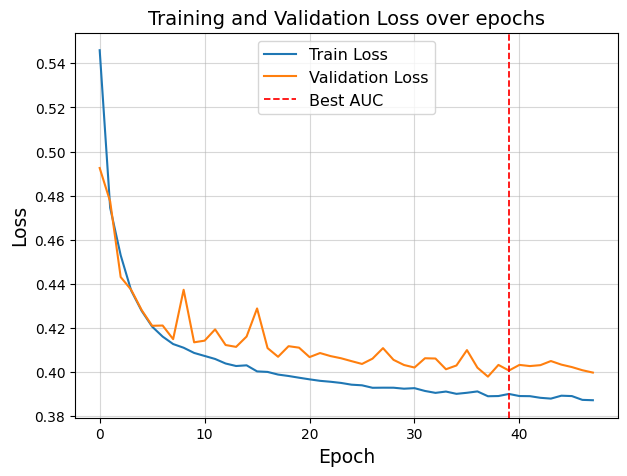

In [12]:
train_data = np.load("Vanilla_XLSTM_hidden_dim_grid_search/train_losses_best_model_final_VanillaXLSTM.npy")
val_data = np.load("Vanilla_XLSTM_hidden_dim_grid_search/val_losses_best_model_final_VanillaXLSTM.npy")

plt.figure(figsize=(7,5))
epochs= np.arange(len(train_data))
plt.plot(epochs,train_data, label="Train Loss")
plt.plot(epochs,val_data, label="Validation Loss")
plt.axvline(x=35,color='red', linestyle='--', linewidth=1.25,label="Best AUC")
plt.xlabel("Epoch",fontsize=13.5)
plt.ylabel("Loss",fontsize=13.5)
plt.title("Training and Validation Loss over epochs",fontsize=14)
plt.legend(fontsize=11.5)
plt.grid(True,alpha=0.7)
plt.savefig("best_mLSTM_block_gridsearch_losses.pdf", dpi=400, bbox_inches="tight")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:17<00:00, 15.37it/s]


Test set Loss: 0.34724733233451843, ROC AUC: 0.960750160024229


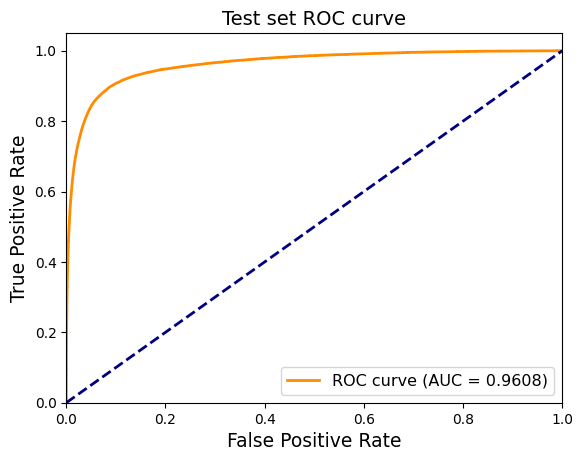

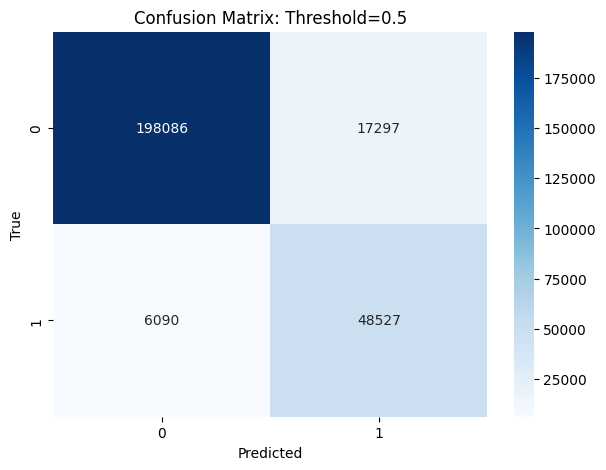

With threshold=0.5: Test set Accuracy: 0.9134, Precision: 0.7372, Recall: 0.8885, F1 score: 0.8058 



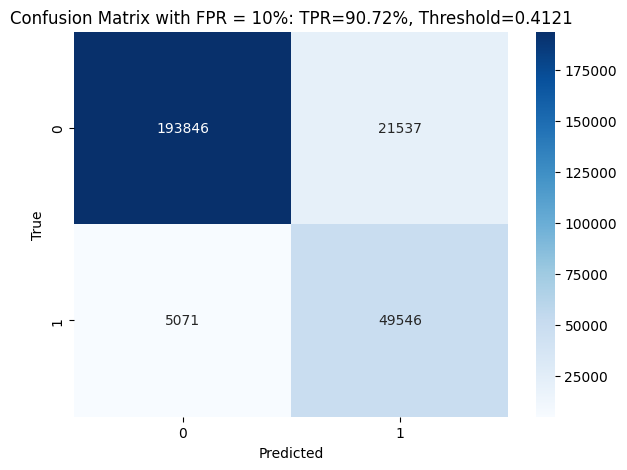

With threshold=0.4121: Test set Accuracy: 0.9015, Precision: 0.6970, Recall: 0.9072, F1 score: 0.7883 



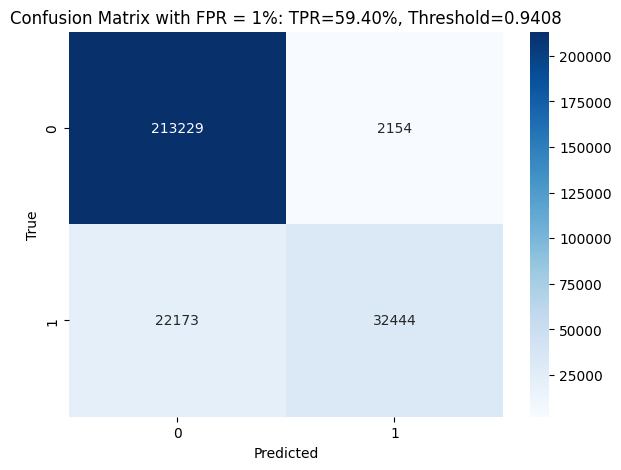

With threshold=0.9408: Test set Accuracy: 0.9099, Precision: 0.9377, Recall: 0.5940, F1 score: 0.7273 



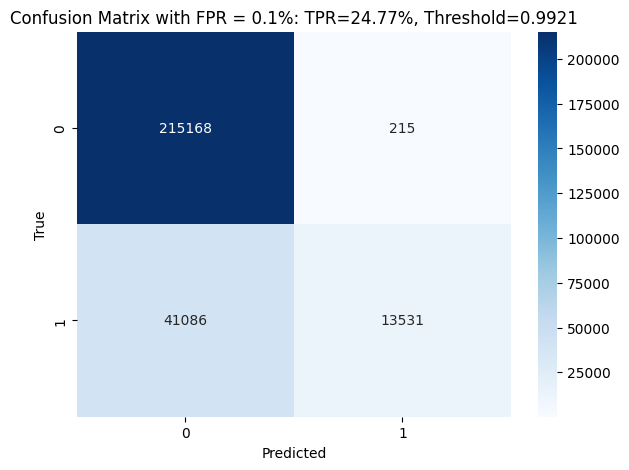

With threshold=0.9921: Test set Accuracy: 0.8470, Precision: 0.9844, Recall: 0.2477, F1 score: 0.3959 

Background rejection at TPR=30%: 1/FPR = 675.1818 (FPR=0.0015)
Background rejection at TPR=50%: 1/FPR = 173.1375 (FPR=0.0058)


In [14]:
# evaluate performance on the test set
device = "cuda" if torch.cuda.is_available() else "cpu"
best_vanilla_xlstm = JetTagger_vanilla_xLSTM(hidden_dim=45)
best_vanilla_xlstm.load_state_dict(torch.load("Vanilla_XLSTM_hidden_dim_grid_search/best_model_final_VanillaXLSTM.pt", map_location=device))
best_vanilla_xlstm.to(device)
pos_weight = torch.tensor([3.0173954931292917], device=device)
evaluate_network(test_dataloader,best_vanilla_xlstm,pos_weight,"Test set")

Let's try to test if we obtain significant improvements stacking more than 1 m-block. 

## General XLSTM model

Here we implement a general adaptable model where we can input a given sequence of blocks as a string. We adopt residual layers to improve gradient flow during training. After each block we introduce an attention layer, and we concatenate the attended outputs of each lyaer in the final classification layer. The idea is that in this way every block can learn a separate representation which doesn't get "washed away" by the other blocks (all blocks contribute to the final layer output). \
We implement a small grid search over some combinations of the blocks sequence  to find the best model. We stop at 6 blocks architectures due to the limited computational resources and to compare with LSTM # of trainable parameters.   

In [8]:
## general XLSTM model with a given sequence of mLSTM and SLSTM blocks

class JetTagger_XLSTM(nn.Module):
    def __init__(self, hidden_dim, input_dim=15,head_num=1, output_dim=1, block_sequence=None):
        """
        XLSTM with:
        - residual skip connections between blocks
        - attention layer after each block
        - concatenation of all blocks attention outputs to a final attention layer
        block_sequence: list of strings, e.g. ["M","M","S","M","M","M"]"""
        super().__init__()
        if block_sequence is None:
            block_sequence = ["M","S","M"]

        self.hidden_dim = hidden_dim
        self.blocks = nn.ModuleList()
        self.attention_layers = nn.ModuleList()  # one attention layer per block

        in_dim = input_dim
        for block_type in block_sequence:
            if block_type.upper() == "M":
                self.blocks.append(mLSTMBlock(hidden_dim,in_dim,head_num=head_num))
            elif block_type.upper() == "S":
                self.blocks.append(sLSTMBlock(hidden_dim, in_dim))
            else:
                raise ValueError(f"Unknown block type {block_type}")
            
            self.attention_layers.append(nn.Linear(hidden_dim, 1))  # attention for this block
            in_dim = hidden_dim  # subsequent blocks take hidden_dim as input

        # final dense layer takes concatenated representations of each block
        self.fc = nn.Linear(hidden_dim*len(block_sequence),output_dim)

    def forward(self, x):
        """
        x: [batch_size, seq_len, input_dim]
        """
        h = x
        pooled_blocks = []

        for block, att_layer in zip(self.blocks, self.attention_layers):

            h_new, _ = block(h)  # [B, seq_len, hidden_dim]
            if h_new.shape[-1] == h.shape[-1]: # use skip connection after the first layer, where dimesnions match
                h = h + h_new
            else:
                h = h_new
            
            # attention pooling for this block
            att_scores = att_layer(h)                 # [B, seq_len, 1]
            att_weights = torch.softmax(att_scores, dim=1)
            pooled = torch.sum(h*att_weights, dim=1)  # [B, hidden_dim]
            pooled_blocks.append(pooled)  # concatenate attended outputs from all blocks

        # concatenate attended outputs from all blocks in the final classification layer
        final_representation = torch.cat(pooled_blocks, dim=1)  # [B, hidden_dim*num_blocks]
        out = self.fc(final_representation)                     # [B, output_dim]
        return out


In [34]:
## grid search over different block sequences

import os
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from sklearn.metrics import roc_auc_score


def run_general_xlstm_grid_search(hidden_dim=45, epochs=70, patience=10):
    os.makedirs("XLSTM_sequences_grid_search", exist_ok=True)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    scaler = GradScaler()

    pos_weight = torch.tensor([3.0173954931292917], device=device)
    loss_fn = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight.to(device)) 

    results_file = "XLSTM_sequences_grid_search/results.txt"
    best_overall_file = "XLSTM_sequences_grid_search/best_overall_model.pt"

    completed_sequences = {}
    if os.path.exists(results_file):
        with open(results_file, "r") as f:
            for line in f:
                try:
                    sequence,val_loss,auc,acc = line.strip().split(",")
                    completed_sequences[sequence] = {
                        "val_loss": float(val_loss),
                        "val_auc": float(auc),
                        "val_acc": float(acc)}
                except:
                    continue

    # candidate block sequences to try
    candidates = [
        ["M","M"],
        ["M","S"],
        ["M","M","S"],
        ["M","S","M"],
        ["M","M","S","M"],
        ["M","M","M","S"],
        ["M","M","S","M","M"],
        ["M","M","S","M","M","M"],
        ["M","M","S","M","M","S"]]
    
    best_global_val = -np.inf
    best_global_seq = None

    for seq in candidates:
        seq_str = "-".join(seq)
        if seq_str in completed_sequences:
            print(f"Skipping model={seq_str}, already completed with best val AUC={completed_sequences[seq_str]['val_auc']:.4f}")
            if completed_sequences[seq_str]["val_auc"]>best_global_val:
                best_global_val = completed_sequences[seq_str]["val_auc"]
                best_global_seq = seq
            continue

        try:
            print(f"\n Training model={seq_str}")
            model = JetTagger_XLSTM(hidden_dim=hidden_dim, block_sequence=seq).to(device)
            opt = Adam(model.parameters(), lr=5e-3)
            
            best_val = -np.inf
            train_losses, val_losses = [], []
            epochs_no_improve = 0

            for epoch in range(epochs):
                model.train()
                epoch_train_losses = []
                iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}")

                for batch_x, batch_y in iterator:
                    batch_x = batch_x.to(device, non_blocking=True).float()
                    batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()

                    opt.zero_grad()
                    with autocast(device_type=device, enabled=False):
                        y_pred = model(batch_x)
                        loss = loss_fn(y_pred, batch_y)

                    scaler.scale(loss).backward()
                    scaler.unscale_(opt)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    scaler.step(opt)
                    scaler.update()

                    epoch_train_losses.append(loss.item())
                    iterator.set_postfix({"Train loss": f"{loss.item():.4f}"})
                
                train_losses.append(np.mean(epoch_train_losses))

                # Validation
                model.eval()
                predictions, true = [], []
                with torch.no_grad():
                    for batch_x, batch_y in valid_dataloader:
                        batch_x = batch_x.to(device, non_blocking=True).float()
                        batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()
                        logits = model(batch_x)
                        predictions.append(logits)
                        true.append(batch_y)

                predictions = torch.cat(predictions, dim=0)
                true = torch.cat(true, dim=0)

                val_loss = loss_fn(predictions, true).item()
                val_acc = (torch.sigmoid(predictions).round() == true).float().mean().item()
                val_auc = roc_auc_score(true.cpu().numpy(), predictions.cpu().numpy())
                val_losses.append(val_loss)

                print(f"Model={seq_str}, Epoch={epoch+1}, Val loss={val_loss:.4f}, AUC={val_auc:.4f}, Acc={val_acc:.4f}")

                if val_auc > best_val:
                    torch.save(model.state_dict(), f"XLSTM_sequences_grid_search/XLSTM_sequence_{seq_str}.pt")
                    best_val = val_auc
                    epochs_no_improve = 0
                    print(f"New best model for {seq_str} saved")
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print(f"Early stopping {seq_str} at epoch {epoch+1}, best AUC={best_val:.4f}")
                        break

            # save results
            with open(results_file, "a") as f:
                f.write(f"{seq_str},{val_losses[-1]},{best_val},{val_acc}\n")

            completed_sequences[seq_str] = {
                "val_loss": val_losses[-1],
                "val_auc": best_val,
                "val_acc": val_acc}

            # save losses per epoch for plotting
            np.save(f"XLSTM_sequences_grid_search/train_losses_{seq_str}.npy", np.array(train_losses))
            np.save(f"XLSTM_sequences_grid_search/val_losses_{seq_str}.npy", np.array(val_losses))

            if best_val > best_global_val:
                best_global_val = best_val
                best_global_seq = seq
                torch.save(model.state_dict(), best_overall_file)
                
        except KeyboardInterrupt:
            print("\n Training interrupted by user. Exiting...")
            break
        except Exception as e:
            print(f"\n Stopping due to error: {e}")
            break

    print("\n Grid Search Finished")
    if best_global_seq is not None:
        print(f"Best model = {best_global_seq} with val_auc={best_global_val:.4f}")
    else:
        print("No completed runs found")

                

In [35]:
run_general_xlstm_grid_search()

Skipping model=M-M, already completed with best val AUC=0.9638
Skipping model=M-S, already completed with best val AUC=0.9636
Skipping model=M-M-S, already completed with best val AUC=0.9638
Skipping model=M-S-M, already completed with best val AUC=0.9644
Skipping model=M-M-S-M, already completed with best val AUC=0.9643
Skipping model=M-M-M-S, already completed with best val AUC=0.9637
Skipping model=M-M-S-M-M, already completed with best val AUC=0.9641
Skipping model=M-M-S-M-M-M, already completed with best val AUC=0.9639
Skipping model=M-M-S-M-M-S, already completed with best val AUC=0.9639

 Grid Search Finished
Best model = ['M', 'S', 'M'] with val_auc=0.9644


In [11]:
run_general_xlstm_grid_search()


 Training model=M-M


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [05:42<00:00,  1.57it/s, Train loss=0.3316]


Model=M-M, Epoch=1, Val loss=0.4281, AUC=0.9411, Acc=0.9086
New best model for M-M saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [05:52<00:00,  1.52it/s, Train loss=0.3241]


Model=M-M, Epoch=2, Val loss=0.4011, AUC=0.9459, Acc=0.9158
New best model for M-M saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [05:58<00:00,  1.50it/s, Train loss=0.3275]


Model=M-M, Epoch=3, Val loss=0.3762, AUC=0.9532, Acc=0.9130
New best model for M-M saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [05:50<00:00,  1.53it/s, Train loss=0.3742]


Model=M-M, Epoch=4, Val loss=0.3649, AUC=0.9559, Acc=0.9133
New best model for M-M saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [05:53<00:00,  1.52it/s, Train loss=0.4193]


Model=M-M, Epoch=5, Val loss=0.3558, AUC=0.9581, Acc=0.9143
New best model for M-M saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [05:45<00:00,  1.55it/s, Train loss=0.3451]


Model=M-M, Epoch=6, Val loss=0.3553, AUC=0.9583, Acc=0.9157
New best model for M-M saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [05:50<00:00,  1.53it/s, Train loss=0.3201]


Model=M-M, Epoch=7, Val loss=0.3536, AUC=0.9587, Acc=0.9230
New best model for M-M saved


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [06:20<00:00,  1.41it/s, Train loss=0.2847]


Model=M-M, Epoch=8, Val loss=0.3483, AUC=0.9600, Acc=0.9189
New best model for M-M saved


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [06:03<00:00,  1.48it/s, Train loss=0.3505]


Model=M-M, Epoch=9, Val loss=0.3519, AUC=0.9591, Acc=0.9169


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [06:03<00:00,  1.48it/s, Train loss=0.2374]


Model=M-M, Epoch=10, Val loss=0.3453, AUC=0.9605, Acc=0.9199
New best model for M-M saved


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [05:41<00:00,  1.57it/s, Train loss=0.3996]


Model=M-M, Epoch=11, Val loss=0.3501, AUC=0.9600, Acc=0.9234


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [05:46<00:00,  1.55it/s, Train loss=0.2813]


Model=M-M, Epoch=12, Val loss=0.3492, AUC=0.9600, Acc=0.9180


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [06:00<00:00,  1.49it/s, Train loss=0.2039]


Model=M-M, Epoch=13, Val loss=0.3501, AUC=0.9598, Acc=0.9228


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [06:08<00:00,  1.46it/s, Train loss=0.3387]


Model=M-M, Epoch=14, Val loss=0.3419, AUC=0.9612, Acc=0.9207
New best model for M-M saved


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [05:41<00:00,  1.57it/s, Train loss=0.3261]


Model=M-M, Epoch=15, Val loss=0.3399, AUC=0.9618, Acc=0.9240
New best model for M-M saved


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [06:06<00:00,  1.46it/s, Train loss=0.2620]


Model=M-M, Epoch=16, Val loss=0.3431, AUC=0.9615, Acc=0.9249


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [06:04<00:00,  1.47it/s, Train loss=0.3493]


Model=M-M, Epoch=17, Val loss=0.3427, AUC=0.9617, Acc=0.9240


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [06:08<00:00,  1.46it/s, Train loss=0.4324]


Model=M-M, Epoch=18, Val loss=0.3447, AUC=0.9609, Acc=0.9240


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [05:58<00:00,  1.50it/s, Train loss=0.2577]


Model=M-M, Epoch=19, Val loss=0.3424, AUC=0.9615, Acc=0.9234


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [05:57<00:00,  1.50it/s, Train loss=0.2769]


Model=M-M, Epoch=20, Val loss=0.3454, AUC=0.9613, Acc=0.9261


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [05:55<00:00,  1.51it/s, Train loss=0.3578]


Model=M-M, Epoch=21, Val loss=0.3442, AUC=0.9609, Acc=0.9175


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [05:49<00:00,  1.54it/s, Train loss=0.2548]


Model=M-M, Epoch=22, Val loss=0.3421, AUC=0.9613, Acc=0.9172


Epoch 23: 100%|████████████████████████████████████████████████████| 537/537 [05:58<00:00,  1.50it/s, Train loss=0.2424]


Model=M-M, Epoch=23, Val loss=0.3435, AUC=0.9615, Acc=0.9251


Epoch 24: 100%|████████████████████████████████████████████████████| 537/537 [05:50<00:00,  1.53it/s, Train loss=0.3495]


Model=M-M, Epoch=24, Val loss=0.3371, AUC=0.9622, Acc=0.9234
New best model for M-M saved


Epoch 25: 100%|████████████████████████████████████████████████████| 537/537 [05:45<00:00,  1.55it/s, Train loss=0.2669]


Model=M-M, Epoch=25, Val loss=0.3406, AUC=0.9618, Acc=0.9176


Epoch 26: 100%|████████████████████████████████████████████████████| 537/537 [05:46<00:00,  1.55it/s, Train loss=0.2388]


Model=M-M, Epoch=26, Val loss=0.3395, AUC=0.9618, Acc=0.9250


Epoch 27: 100%|████████████████████████████████████████████████████| 537/537 [05:49<00:00,  1.54it/s, Train loss=0.5038]


Model=M-M, Epoch=27, Val loss=0.3387, AUC=0.9619, Acc=0.9197


Epoch 28: 100%|████████████████████████████████████████████████████| 537/537 [06:02<00:00,  1.48it/s, Train loss=0.2986]


Model=M-M, Epoch=28, Val loss=0.3404, AUC=0.9623, Acc=0.9188
New best model for M-M saved


Epoch 29: 100%|████████████████████████████████████████████████████| 537/537 [06:06<00:00,  1.46it/s, Train loss=0.3895]


Model=M-M, Epoch=29, Val loss=0.3371, AUC=0.9622, Acc=0.9193


Epoch 30: 100%|████████████████████████████████████████████████████| 537/537 [06:10<00:00,  1.45it/s, Train loss=0.3842]


Model=M-M, Epoch=30, Val loss=0.3356, AUC=0.9629, Acc=0.9221
New best model for M-M saved


Epoch 31: 100%|████████████████████████████████████████████████████| 537/537 [06:12<00:00,  1.44it/s, Train loss=0.3058]


Model=M-M, Epoch=31, Val loss=0.3378, AUC=0.9627, Acc=0.9243


Epoch 32: 100%|████████████████████████████████████████████████████| 537/537 [06:09<00:00,  1.45it/s, Train loss=0.5304]


Model=M-M, Epoch=32, Val loss=0.3429, AUC=0.9618, Acc=0.9143


Epoch 33: 100%|████████████████████████████████████████████████████| 537/537 [06:15<00:00,  1.43it/s, Train loss=0.2582]


Model=M-M, Epoch=33, Val loss=0.3372, AUC=0.9624, Acc=0.9199


Epoch 34: 100%|████████████████████████████████████████████████████| 537/537 [06:18<00:00,  1.42it/s, Train loss=0.2881]


Model=M-M, Epoch=34, Val loss=0.3363, AUC=0.9625, Acc=0.9216


Epoch 35: 100%|████████████████████████████████████████████████████| 537/537 [06:19<00:00,  1.41it/s, Train loss=0.5198]


Model=M-M, Epoch=35, Val loss=0.3370, AUC=0.9624, Acc=0.9189


Epoch 36: 100%|████████████████████████████████████████████████████| 537/537 [06:09<00:00,  1.45it/s, Train loss=0.2886]


Model=M-M, Epoch=36, Val loss=0.3370, AUC=0.9626, Acc=0.9198


Epoch 37: 100%|████████████████████████████████████████████████████| 537/537 [06:04<00:00,  1.48it/s, Train loss=0.3324]


Model=M-M, Epoch=37, Val loss=0.3394, AUC=0.9625, Acc=0.9260


Epoch 38: 100%|████████████████████████████████████████████████████| 537/537 [06:09<00:00,  1.45it/s, Train loss=0.2369]


Model=M-M, Epoch=38, Val loss=0.3399, AUC=0.9628, Acc=0.9274


Epoch 39: 100%|████████████████████████████████████████████████████| 537/537 [05:54<00:00,  1.51it/s, Train loss=0.6166]


Model=M-M, Epoch=39, Val loss=0.3357, AUC=0.9632, Acc=0.9264
New best model for M-M saved


Epoch 40: 100%|████████████████████████████████████████████████████| 537/537 [06:07<00:00,  1.46it/s, Train loss=0.2104]


Model=M-M, Epoch=40, Val loss=0.3437, AUC=0.9622, Acc=0.9271


Epoch 41: 100%|████████████████████████████████████████████████████| 537/537 [06:11<00:00,  1.44it/s, Train loss=0.3119]


Model=M-M, Epoch=41, Val loss=0.3359, AUC=0.9627, Acc=0.9236


Epoch 42: 100%|████████████████████████████████████████████████████| 537/537 [06:19<00:00,  1.42it/s, Train loss=0.2689]


Model=M-M, Epoch=42, Val loss=0.3346, AUC=0.9632, Acc=0.9249
New best model for M-M saved


Epoch 43: 100%|████████████████████████████████████████████████████| 537/537 [06:30<00:00,  1.37it/s, Train loss=0.2013]


Model=M-M, Epoch=43, Val loss=0.3380, AUC=0.9626, Acc=0.9225


Epoch 44: 100%|████████████████████████████████████████████████████| 537/537 [06:02<00:00,  1.48it/s, Train loss=0.2531]


Model=M-M, Epoch=44, Val loss=0.3359, AUC=0.9627, Acc=0.9222


Epoch 45: 100%|████████████████████████████████████████████████████| 537/537 [06:20<00:00,  1.41it/s, Train loss=0.2487]


Model=M-M, Epoch=45, Val loss=0.3358, AUC=0.9625, Acc=0.9222


Epoch 46: 100%|████████████████████████████████████████████████████| 537/537 [06:46<00:00,  1.32it/s, Train loss=0.4242]


Model=M-M, Epoch=46, Val loss=0.3364, AUC=0.9625, Acc=0.9249


Epoch 47: 100%|████████████████████████████████████████████████████| 537/537 [06:15<00:00,  1.43it/s, Train loss=0.3286]


Model=M-M, Epoch=47, Val loss=0.3395, AUC=0.9622, Acc=0.9197


Epoch 48: 100%|████████████████████████████████████████████████████| 537/537 [06:15<00:00,  1.43it/s, Train loss=0.4275]


Model=M-M, Epoch=48, Val loss=0.3360, AUC=0.9627, Acc=0.9225


Epoch 49: 100%|████████████████████████████████████████████████████| 537/537 [06:20<00:00,  1.41it/s, Train loss=0.3569]


Model=M-M, Epoch=49, Val loss=0.3361, AUC=0.9634, Acc=0.9160
New best model for M-M saved


Epoch 50: 100%|████████████████████████████████████████████████████| 537/537 [06:18<00:00,  1.42it/s, Train loss=0.2474]


Model=M-M, Epoch=50, Val loss=0.3376, AUC=0.9625, Acc=0.9245


Epoch 51: 100%|████████████████████████████████████████████████████| 537/537 [06:22<00:00,  1.40it/s, Train loss=0.4912]


Model=M-M, Epoch=51, Val loss=0.3352, AUC=0.9628, Acc=0.9198


Epoch 52: 100%|████████████████████████████████████████████████████| 537/537 [06:20<00:00,  1.41it/s, Train loss=0.3251]


Model=M-M, Epoch=52, Val loss=0.3341, AUC=0.9634, Acc=0.9181


Epoch 53: 100%|████████████████████████████████████████████████████| 537/537 [06:20<00:00,  1.41it/s, Train loss=0.2997]


Model=M-M, Epoch=53, Val loss=0.3402, AUC=0.9621, Acc=0.9152


Epoch 54: 100%|████████████████████████████████████████████████████| 537/537 [06:29<00:00,  1.38it/s, Train loss=0.2040]


Model=M-M, Epoch=54, Val loss=0.3454, AUC=0.9617, Acc=0.9294


Epoch 55: 100%|████████████████████████████████████████████████████| 537/537 [06:34<00:00,  1.36it/s, Train loss=0.3539]


Model=M-M, Epoch=55, Val loss=0.3418, AUC=0.9618, Acc=0.9234


Epoch 56: 100%|████████████████████████████████████████████████████| 537/537 [06:28<00:00,  1.38it/s, Train loss=0.3920]


Model=M-M, Epoch=56, Val loss=0.3407, AUC=0.9619, Acc=0.9194


Epoch 57: 100%|████████████████████████████████████████████████████| 537/537 [06:33<00:00,  1.37it/s, Train loss=0.3609]


Model=M-M, Epoch=57, Val loss=0.3339, AUC=0.9634, Acc=0.9184


Epoch 58: 100%|████████████████████████████████████████████████████| 537/537 [06:26<00:00,  1.39it/s, Train loss=0.2794]


Model=M-M, Epoch=58, Val loss=0.3347, AUC=0.9635, Acc=0.9223
New best model for M-M saved


Epoch 59: 100%|████████████████████████████████████████████████████| 537/537 [06:31<00:00,  1.37it/s, Train loss=0.3820]


Model=M-M, Epoch=59, Val loss=0.3403, AUC=0.9626, Acc=0.9271


Epoch 60: 100%|████████████████████████████████████████████████████| 537/537 [06:29<00:00,  1.38it/s, Train loss=0.2858]


Model=M-M, Epoch=60, Val loss=0.3401, AUC=0.9626, Acc=0.9250


Epoch 61: 100%|████████████████████████████████████████████████████| 537/537 [06:33<00:00,  1.36it/s, Train loss=0.2040]


Model=M-M, Epoch=61, Val loss=0.3336, AUC=0.9633, Acc=0.9251


Epoch 62: 100%|████████████████████████████████████████████████████| 537/537 [06:29<00:00,  1.38it/s, Train loss=0.3648]


Model=M-M, Epoch=62, Val loss=0.3355, AUC=0.9629, Acc=0.9224


Epoch 63: 100%|████████████████████████████████████████████████████| 537/537 [06:31<00:00,  1.37it/s, Train loss=0.3339]


Model=M-M, Epoch=63, Val loss=0.3335, AUC=0.9635, Acc=0.9206


Epoch 64: 100%|████████████████████████████████████████████████████| 537/537 [06:31<00:00,  1.37it/s, Train loss=0.4124]


Model=M-M, Epoch=64, Val loss=0.3348, AUC=0.9631, Acc=0.9206


Epoch 65: 100%|████████████████████████████████████████████████████| 537/537 [06:34<00:00,  1.36it/s, Train loss=0.1543]


Model=M-M, Epoch=65, Val loss=0.3318, AUC=0.9638, Acc=0.9213
New best model for M-M saved


Epoch 66: 100%|████████████████████████████████████████████████████| 537/537 [06:34<00:00,  1.36it/s, Train loss=0.4857]


Model=M-M, Epoch=66, Val loss=0.3340, AUC=0.9630, Acc=0.9217


Epoch 67: 100%|████████████████████████████████████████████████████| 537/537 [06:35<00:00,  1.36it/s, Train loss=0.3688]


Model=M-M, Epoch=67, Val loss=0.3346, AUC=0.9630, Acc=0.9201


Epoch 68: 100%|████████████████████████████████████████████████████| 537/537 [06:35<00:00,  1.36it/s, Train loss=0.3486]


Model=M-M, Epoch=68, Val loss=0.3322, AUC=0.9635, Acc=0.9207


Epoch 69: 100%|████████████████████████████████████████████████████| 537/537 [06:40<00:00,  1.34it/s, Train loss=0.3532]


Model=M-M, Epoch=69, Val loss=0.3405, AUC=0.9622, Acc=0.9262


Epoch 70: 100%|████████████████████████████████████████████████████| 537/537 [06:25<00:00,  1.39it/s, Train loss=0.2712]


Model=M-M, Epoch=70, Val loss=0.3426, AUC=0.9618, Acc=0.9131

 Training model=M-S


Epoch 1:   0%|                                                                                  | 0/537 [00:00<?, ?it/s]


 Stopping due to error: name 'n0' is not defined

 Grid Search Finished
Best model = ['M', 'M'] with val_auc=0.9638


In [ ]:
run_general_xlstm_grid_search()

Skipping model=M-M, already completed with best val AUC=0.9638
Skipping model=M-S, already completed with best val AUC=0.9636

 Training model=M-M-S


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [05:26<00:00,  1.65it/s, Train loss=0.2291]


Model=M-M-S, Epoch=1, Val loss=0.4018, AUC=0.9477, Acc=0.8971
New best model for M-M-S saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [05:35<00:00,  1.60it/s, Train loss=0.4014]


Model=M-M-S, Epoch=2, Val loss=0.3778, AUC=0.9544, Acc=0.9010
New best model for M-M-S saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [05:38<00:00,  1.59it/s, Train loss=0.3442]


Model=M-M-S, Epoch=3, Val loss=0.3596, AUC=0.9575, Acc=0.9170
New best model for M-M-S saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [05:34<00:00,  1.61it/s, Train loss=0.3113]


Model=M-M-S, Epoch=4, Val loss=0.3606, AUC=0.9566, Acc=0.9190


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [05:27<00:00,  1.64it/s, Train loss=0.3386]


Model=M-M-S, Epoch=5, Val loss=0.3570, AUC=0.9579, Acc=0.9142
New best model for M-M-S saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [05:25<00:00,  1.65it/s, Train loss=0.3814]


Model=M-M-S, Epoch=6, Val loss=0.3422, AUC=0.9617, Acc=0.9234
New best model for M-M-S saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [05:27<00:00,  1.64it/s, Train loss=0.5422]


Model=M-M-S, Epoch=7, Val loss=0.3463, AUC=0.9606, Acc=0.9226


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [05:40<00:00,  1.58it/s, Train loss=0.4521]


Model=M-M-S, Epoch=8, Val loss=0.3446, AUC=0.9611, Acc=0.9164


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [05:38<00:00,  1.59it/s, Train loss=0.3224]


Model=M-M-S, Epoch=9, Val loss=0.3381, AUC=0.9621, Acc=0.9197
New best model for M-M-S saved


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [05:30<00:00,  1.63it/s, Train loss=0.3572]


Model=M-M-S, Epoch=10, Val loss=0.3435, AUC=0.9618, Acc=0.9121


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [05:31<00:00,  1.62it/s, Train loss=0.2839]


Model=M-M-S, Epoch=11, Val loss=0.3348, AUC=0.9629, Acc=0.9244
New best model for M-M-S saved


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [05:35<00:00,  1.60it/s, Train loss=0.2059]


Model=M-M-S, Epoch=12, Val loss=0.3347, AUC=0.9631, Acc=0.9187
New best model for M-M-S saved


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [05:38<00:00,  1.58it/s, Train loss=0.3415]


Model=M-M-S, Epoch=13, Val loss=0.3369, AUC=0.9628, Acc=0.9232


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [05:50<00:00,  1.53it/s, Train loss=0.3112]


Model=M-M-S, Epoch=14, Val loss=0.3341, AUC=0.9631, Acc=0.9208


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [05:30<00:00,  1.62it/s, Train loss=0.1762]


Model=M-M-S, Epoch=15, Val loss=0.3459, AUC=0.9627, Acc=0.9268


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [05:28<00:00,  1.64it/s, Train loss=0.4336]


Model=M-M-S, Epoch=16, Val loss=0.3502, AUC=0.9607, Acc=0.9090


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [05:30<00:00,  1.62it/s, Train loss=0.2232]


Model=M-M-S, Epoch=17, Val loss=0.3375, AUC=0.9630, Acc=0.9255


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [05:44<00:00,  1.56it/s, Train loss=0.3197]


Model=M-M-S, Epoch=18, Val loss=0.3373, AUC=0.9625, Acc=0.9240


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [05:44<00:00,  1.56it/s, Train loss=0.2472]


Model=M-M-S, Epoch=19, Val loss=0.3404, AUC=0.9634, Acc=0.9295
New best model for M-M-S saved


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [05:38<00:00,  1.59it/s, Train loss=0.3512]


Model=M-M-S, Epoch=20, Val loss=0.3324, AUC=0.9638, Acc=0.9163
New best model for M-M-S saved


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [05:42<00:00,  1.57it/s, Train loss=0.3322]


Model=M-M-S, Epoch=21, Val loss=0.3387, AUC=0.9623, Acc=0.9147


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [05:40<00:00,  1.58it/s, Train loss=0.2679]


Model=M-M-S, Epoch=22, Val loss=0.3334, AUC=0.9635, Acc=0.9250


Epoch 23: 100%|████████████████████████████████████████████████████| 537/537 [05:45<00:00,  1.56it/s, Train loss=0.2891]


Model=M-M-S, Epoch=23, Val loss=0.3321, AUC=0.9635, Acc=0.9214


Epoch 24: 100%|████████████████████████████████████████████████████| 537/537 [05:48<00:00,  1.54it/s, Train loss=0.3938]


Model=M-M-S, Epoch=24, Val loss=0.3358, AUC=0.9630, Acc=0.9146


Epoch 25: 100%|████████████████████████████████████████████████████| 537/537 [05:43<00:00,  1.56it/s, Train loss=0.3442]


Model=M-M-S, Epoch=25, Val loss=0.3388, AUC=0.9627, Acc=0.9254


Epoch 26: 100%|████████████████████████████████████████████████████| 537/537 [05:36<00:00,  1.59it/s, Train loss=0.1848]


Model=M-M-S, Epoch=26, Val loss=0.3345, AUC=0.9632, Acc=0.9222


Epoch 27: 100%|████████████████████████████████████████████████████| 537/537 [05:36<00:00,  1.60it/s, Train loss=0.3615]


Model=M-M-S, Epoch=27, Val loss=0.3353, AUC=0.9628, Acc=0.9198


Epoch 28: 100%|████████████████████████████████████████████████████| 537/537 [05:40<00:00,  1.58it/s, Train loss=0.3969]


Model=M-M-S, Epoch=28, Val loss=0.3432, AUC=0.9621, Acc=0.9270


Epoch 29: 100%|████████████████████████████████████████████████████| 537/537 [05:37<00:00,  1.59it/s, Train loss=0.1816]


Model=M-M-S, Epoch=29, Val loss=0.3367, AUC=0.9629, Acc=0.9238


Epoch 30: 100%|████████████████████████████████████████████████████| 537/537 [05:37<00:00,  1.59it/s, Train loss=0.2980]


Model=M-M-S, Epoch=30, Val loss=0.3331, AUC=0.9635, Acc=0.9209
Early stopping M-M-S at epoch 30, best AUC=0.9638

 Training model=M-S-M


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [05:30<00:00,  1.63it/s, Train loss=0.6397]


Model=M-S-M, Epoch=1, Val loss=0.4022, AUC=0.9465, Acc=0.9066
New best model for M-S-M saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [05:34<00:00,  1.61it/s, Train loss=0.5155]


Model=M-S-M, Epoch=2, Val loss=0.3829, AUC=0.9536, Acc=0.8951
New best model for M-S-M saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [05:30<00:00,  1.63it/s, Train loss=0.4606]


Model=M-S-M, Epoch=3, Val loss=0.3569, AUC=0.9580, Acc=0.9222
New best model for M-S-M saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [05:27<00:00,  1.64it/s, Train loss=0.2861]


Model=M-S-M, Epoch=4, Val loss=0.3551, AUC=0.9588, Acc=0.9212
New best model for M-S-M saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [05:28<00:00,  1.64it/s, Train loss=0.3847]


Model=M-S-M, Epoch=5, Val loss=0.3563, AUC=0.9604, Acc=0.9013
New best model for M-S-M saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [05:29<00:00,  1.63it/s, Train loss=0.2776]


Model=M-S-M, Epoch=6, Val loss=0.3398, AUC=0.9618, Acc=0.9212
New best model for M-S-M saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [05:29<00:00,  1.63it/s, Train loss=0.2654]


Model=M-S-M, Epoch=7, Val loss=0.3366, AUC=0.9626, Acc=0.9212
New best model for M-S-M saved


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [05:24<00:00,  1.65it/s, Train loss=0.2349]


Model=M-S-M, Epoch=8, Val loss=0.3396, AUC=0.9621, Acc=0.9187


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [05:24<00:00,  1.65it/s, Train loss=0.2932]


Model=M-S-M, Epoch=9, Val loss=0.3348, AUC=0.9630, Acc=0.9231
New best model for M-S-M saved


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [05:31<00:00,  1.62it/s, Train loss=0.2131]


Model=M-S-M, Epoch=10, Val loss=0.3331, AUC=0.9636, Acc=0.9240
New best model for M-S-M saved


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [05:23<00:00,  1.66it/s, Train loss=0.2249]


Model=M-S-M, Epoch=11, Val loss=0.3344, AUC=0.9631, Acc=0.9239


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [05:23<00:00,  1.66it/s, Train loss=0.2192]


Model=M-S-M, Epoch=12, Val loss=0.3390, AUC=0.9622, Acc=0.9174


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [05:26<00:00,  1.64it/s, Train loss=0.2662]


Model=M-S-M, Epoch=13, Val loss=0.3351, AUC=0.9629, Acc=0.9196


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [05:28<00:00,  1.63it/s, Train loss=0.2075]


Model=M-S-M, Epoch=14, Val loss=0.3327, AUC=0.9638, Acc=0.9217
New best model for M-S-M saved


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [05:26<00:00,  1.64it/s, Train loss=0.2128]


Model=M-S-M, Epoch=15, Val loss=0.3343, AUC=0.9633, Acc=0.9276


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [05:27<00:00,  1.64it/s, Train loss=0.3202]


Model=M-S-M, Epoch=16, Val loss=0.3340, AUC=0.9633, Acc=0.9244


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [05:30<00:00,  1.63it/s, Train loss=0.1905]


Model=M-S-M, Epoch=17, Val loss=0.3385, AUC=0.9629, Acc=0.9266


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [05:23<00:00,  1.66it/s, Train loss=0.4294]


Model=M-S-M, Epoch=18, Val loss=0.3311, AUC=0.9639, Acc=0.9242
New best model for M-S-M saved


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [05:41<00:00,  1.57it/s, Train loss=0.3460]


Model=M-S-M, Epoch=19, Val loss=0.3284, AUC=0.9644, Acc=0.9245
New best model for M-S-M saved


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [05:44<00:00,  1.56it/s, Train loss=0.3059]


Model=M-S-M, Epoch=20, Val loss=0.3320, AUC=0.9640, Acc=0.9263


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [05:38<00:00,  1.59it/s, Train loss=0.2294]


Model=M-S-M, Epoch=21, Val loss=0.3347, AUC=0.9639, Acc=0.9281


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [05:22<00:00,  1.66it/s, Train loss=0.3941]


Model=M-S-M, Epoch=22, Val loss=0.3356, AUC=0.9627, Acc=0.9201


Epoch 23: 100%|████████████████████████████████████████████████████| 537/537 [05:19<00:00,  1.68it/s, Train loss=0.5387]


Model=M-S-M, Epoch=23, Val loss=0.3384, AUC=0.9630, Acc=0.9128


Epoch 24: 100%|████████████████████████████████████████████████████| 537/537 [05:22<00:00,  1.67it/s, Train loss=0.1929]


Model=M-S-M, Epoch=24, Val loss=0.3343, AUC=0.9631, Acc=0.9192


Epoch 25: 100%|████████████████████████████████████████████████████| 537/537 [05:24<00:00,  1.65it/s, Train loss=0.2292]


Model=M-S-M, Epoch=25, Val loss=0.3320, AUC=0.9637, Acc=0.9214


Epoch 26: 100%|████████████████████████████████████████████████████| 537/537 [05:30<00:00,  1.63it/s, Train loss=0.3230]


Model=M-S-M, Epoch=26, Val loss=0.3350, AUC=0.9634, Acc=0.9255


Epoch 27: 100%|████████████████████████████████████████████████████| 537/537 [05:27<00:00,  1.64it/s, Train loss=0.3868]


Model=M-S-M, Epoch=27, Val loss=0.3400, AUC=0.9629, Acc=0.9276


Epoch 28: 100%|████████████████████████████████████████████████████| 537/537 [05:31<00:00,  1.62it/s, Train loss=0.1516]


Model=M-S-M, Epoch=28, Val loss=0.3410, AUC=0.9631, Acc=0.9258


Epoch 29: 100%|████████████████████████████████████████████████████| 537/537 [05:27<00:00,  1.64it/s, Train loss=0.3567]


Model=M-S-M, Epoch=29, Val loss=0.3313, AUC=0.9637, Acc=0.9239
Early stopping M-S-M at epoch 29, best AUC=0.9644

 Training model=M-M-S-M


Epoch 1:   0%|                                                       | 1/537 [00:00<08:21,  1.07it/s, Train loss=0.9939]

In [ ]:
run_general_xlstm_grid_search()

Skipping model=M-M, already completed with best val AUC=0.9638
Skipping model=M-S, already completed with best val AUC=0.9636
Skipping model=M-M-S, already completed with best val AUC=0.9638
Skipping model=M-S-M, already completed with best val AUC=0.9644

 Training model=M-M-S-M


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [10:15<00:00,  1.15s/it, Train loss=0.4676]


Model=M-M-S-M, Epoch=1, Val loss=0.3956, AUC=0.9481, Acc=0.9153
New best model for M-M-S-M saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [10:09<00:00,  1.13s/it, Train loss=0.2770]


Model=M-M-S-M, Epoch=2, Val loss=0.3694, AUC=0.9553, Acc=0.9226
New best model for M-M-S-M saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [10:09<00:00,  1.14s/it, Train loss=0.2033]


Model=M-M-S-M, Epoch=3, Val loss=0.3587, AUC=0.9579, Acc=0.9225
New best model for M-M-S-M saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [10:14<00:00,  1.14s/it, Train loss=0.3358]


Model=M-M-S-M, Epoch=4, Val loss=0.3487, AUC=0.9595, Acc=0.9211
New best model for M-M-S-M saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [09:56<00:00,  1.11s/it, Train loss=0.2684]


Model=M-M-S-M, Epoch=5, Val loss=0.3490, AUC=0.9602, Acc=0.9220
New best model for M-M-S-M saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [09:58<00:00,  1.11s/it, Train loss=0.2946]


Model=M-M-S-M, Epoch=6, Val loss=0.3458, AUC=0.9611, Acc=0.9146
New best model for M-M-S-M saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [10:16<00:00,  1.15s/it, Train loss=0.2301]


Model=M-M-S-M, Epoch=7, Val loss=0.3481, AUC=0.9598, Acc=0.9172


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [10:08<00:00,  1.13s/it, Train loss=0.2980]


Model=M-M-S-M, Epoch=8, Val loss=0.3626, AUC=0.9581, Acc=0.9016


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [10:27<00:00,  1.17s/it, Train loss=0.3574]


Model=M-M-S-M, Epoch=9, Val loss=0.3373, AUC=0.9626, Acc=0.9176
New best model for M-M-S-M saved


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [10:17<00:00,  1.15s/it, Train loss=0.3355]


Model=M-M-S-M, Epoch=10, Val loss=0.3372, AUC=0.9624, Acc=0.9166


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [10:34<00:00,  1.18s/it, Train loss=0.3862]


Model=M-M-S-M, Epoch=11, Val loss=0.3432, AUC=0.9624, Acc=0.9277


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [10:38<00:00,  1.19s/it, Train loss=0.2919]


Model=M-M-S-M, Epoch=12, Val loss=0.3392, AUC=0.9628, Acc=0.9129
New best model for M-M-S-M saved


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [10:22<00:00,  1.16s/it, Train loss=0.3424]


Model=M-M-S-M, Epoch=13, Val loss=0.3302, AUC=0.9643, Acc=0.9181
New best model for M-M-S-M saved


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [10:23<00:00,  1.16s/it, Train loss=0.3421]


Model=M-M-S-M, Epoch=14, Val loss=0.3334, AUC=0.9636, Acc=0.9200


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [09:58<00:00,  1.11s/it, Train loss=0.3645]


Model=M-M-S-M, Epoch=15, Val loss=0.3415, AUC=0.9630, Acc=0.9282


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [10:05<00:00,  1.13s/it, Train loss=0.3896]


Model=M-M-S-M, Epoch=16, Val loss=0.3381, AUC=0.9625, Acc=0.9143


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [09:57<00:00,  1.11s/it, Train loss=0.2180]


Model=M-M-S-M, Epoch=17, Val loss=0.3338, AUC=0.9635, Acc=0.9240


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [10:30<00:00,  1.17s/it, Train loss=0.2003]


Model=M-M-S-M, Epoch=18, Val loss=0.3342, AUC=0.9635, Acc=0.9240


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [10:26<00:00,  1.17s/it, Train loss=0.3903]


Model=M-M-S-M, Epoch=19, Val loss=0.3322, AUC=0.9639, Acc=0.9249


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [10:28<00:00,  1.17s/it, Train loss=0.4489]


Model=M-M-S-M, Epoch=20, Val loss=0.3337, AUC=0.9639, Acc=0.9274


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [10:18<00:00,  1.15s/it, Train loss=0.2179]


Model=M-M-S-M, Epoch=21, Val loss=0.3425, AUC=0.9626, Acc=0.9231


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [10:26<00:00,  1.17s/it, Train loss=0.2521]


Model=M-M-S-M, Epoch=22, Val loss=0.3321, AUC=0.9637, Acc=0.9243


Epoch 23: 100%|████████████████████████████████████████████████████| 537/537 [10:31<00:00,  1.18s/it, Train loss=0.3798]


Model=M-M-S-M, Epoch=23, Val loss=0.3320, AUC=0.9637, Acc=0.9203
Early stopping M-M-S-M at epoch 23, best AUC=0.9643
Skipping model=M-M-M-S, already completed with best val AUC=0.9637

 Training model=M-M-S-M-M


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [13:19<00:00,  1.49s/it, Train loss=0.4456]


Model=M-M-S-M-M, Epoch=1, Val loss=0.3996, AUC=0.9475, Acc=0.9100
New best model for M-M-S-M-M saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [13:38<00:00,  1.52s/it, Train loss=0.4600]


Model=M-M-S-M-M, Epoch=2, Val loss=0.3592, AUC=0.9575, Acc=0.9207
New best model for M-M-S-M-M saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [13:21<00:00,  1.49s/it, Train loss=0.4106]


Model=M-M-S-M-M, Epoch=3, Val loss=0.3563, AUC=0.9578, Acc=0.9161
New best model for M-M-S-M-M saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [13:00<00:00,  1.45s/it, Train loss=0.5127]


Model=M-M-S-M-M, Epoch=4, Val loss=0.3552, AUC=0.9590, Acc=0.9125
New best model for M-M-S-M-M saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [13:13<00:00,  1.48s/it, Train loss=0.2261]


Model=M-M-S-M-M, Epoch=5, Val loss=0.3499, AUC=0.9593, Acc=0.9189
New best model for M-M-S-M-M saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [12:39<00:00,  1.41s/it, Train loss=0.3449]


Model=M-M-S-M-M, Epoch=6, Val loss=0.3482, AUC=0.9607, Acc=0.9240
New best model for M-M-S-M-M saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [13:19<00:00,  1.49s/it, Train loss=0.3036]


Model=M-M-S-M-M, Epoch=7, Val loss=0.3454, AUC=0.9613, Acc=0.9147
New best model for M-M-S-M-M saved


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [12:41<00:00,  1.42s/it, Train loss=0.2181]


Model=M-M-S-M-M, Epoch=8, Val loss=0.3527, AUC=0.9592, Acc=0.9283


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [12:59<00:00,  1.45s/it, Train loss=0.3464]


Model=M-M-S-M-M, Epoch=9, Val loss=0.3356, AUC=0.9624, Acc=0.9229
New best model for M-M-S-M-M saved


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [12:53<00:00,  1.44s/it, Train loss=0.6380]


Model=M-M-S-M-M, Epoch=10, Val loss=0.3435, AUC=0.9621, Acc=0.9269


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [13:10<00:00,  1.47s/it, Train loss=0.4099]


Model=M-M-S-M-M, Epoch=11, Val loss=0.3341, AUC=0.9630, Acc=0.9190
New best model for M-M-S-M-M saved


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [12:47<00:00,  1.43s/it, Train loss=0.3174]


Model=M-M-S-M-M, Epoch=12, Val loss=0.3387, AUC=0.9626, Acc=0.9142


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [13:21<00:00,  1.49s/it, Train loss=0.2223]


Model=M-M-S-M-M, Epoch=13, Val loss=0.3380, AUC=0.9621, Acc=0.9252


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [13:17<00:00,  1.49s/it, Train loss=0.3847]


Model=M-M-S-M-M, Epoch=14, Val loss=0.3322, AUC=0.9635, Acc=0.9225
New best model for M-M-S-M-M saved


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [12:54<00:00,  1.44s/it, Train loss=0.3962]


Model=M-M-S-M-M, Epoch=15, Val loss=0.3365, AUC=0.9627, Acc=0.9271


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [12:45<00:00,  1.43s/it, Train loss=0.3940]


Model=M-M-S-M-M, Epoch=16, Val loss=0.3326, AUC=0.9635, Acc=0.9168
New best model for M-M-S-M-M saved


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [13:24<00:00,  1.50s/it, Train loss=0.2925]


Model=M-M-S-M-M, Epoch=17, Val loss=0.3379, AUC=0.9620, Acc=0.9216


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [13:31<00:00,  1.51s/it, Train loss=0.3506]


Model=M-M-S-M-M, Epoch=18, Val loss=0.3380, AUC=0.9625, Acc=0.9156


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [13:31<00:00,  1.51s/it, Train loss=0.5096]


Model=M-M-S-M-M, Epoch=19, Val loss=0.3348, AUC=0.9631, Acc=0.9263


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [12:33<00:00,  1.40s/it, Train loss=0.2466]


Model=M-M-S-M-M, Epoch=20, Val loss=0.3390, AUC=0.9633, Acc=0.9275


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [13:23<00:00,  1.50s/it, Train loss=0.4004]


Model=M-M-S-M-M, Epoch=21, Val loss=0.3388, AUC=0.9628, Acc=0.9126


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [14:17<00:00,  1.60s/it, Train loss=0.3887]


Model=M-M-S-M-M, Epoch=22, Val loss=0.3319, AUC=0.9641, Acc=0.9193
New best model for M-M-S-M-M saved


Epoch 23: 100%|████████████████████████████████████████████████████| 537/537 [14:05<00:00,  1.57s/it, Train loss=0.5534]


Model=M-M-S-M-M, Epoch=23, Val loss=0.3459, AUC=0.9607, Acc=0.9152


Epoch 24: 100%|████████████████████████████████████████████████████| 537/537 [14:18<00:00,  1.60s/it, Train loss=0.4334]


Model=M-M-S-M-M, Epoch=24, Val loss=0.3352, AUC=0.9631, Acc=0.9181


Epoch 25:  19%|██████████                                          | 104/537 [02:46<11:22,  1.58s/it, Train loss=0.2662]

In [ ]:
run_general_xlstm_grid_search()

Skipping model=M-M-S, already completed with best val AUC=0.9637
Skipping model=M-S-M, already completed with best val AUC=0.9635
Skipping model=M-M-S-M, already completed with best val AUC=0.9636
Skipping model=M-M-M-S, already completed with best val AUC=0.9637

 Training model=M-M-S-M-M


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [10:45<00:00,  1.20s/it, Train loss=0.5124]


Model=M-M-S-M-M, Epoch=1, Val loss=0.3980, AUC=0.9471, Acc=0.9080
New best model for M-M-S-M-M saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [10:35<00:00,  1.18s/it, Train loss=0.2304]


Model=M-M-S-M-M, Epoch=2, Val loss=0.3747, AUC=0.9535, Acc=0.9198
New best model for M-M-S-M-M saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [09:34<00:00,  1.07s/it, Train loss=0.3805]


Model=M-M-S-M-M, Epoch=3, Val loss=0.3601, AUC=0.9569, Acc=0.9143
New best model for M-M-S-M-M saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [09:44<00:00,  1.09s/it, Train loss=0.2533]


Model=M-M-S-M-M, Epoch=4, Val loss=0.3549, AUC=0.9586, Acc=0.9165
New best model for M-M-S-M-M saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [10:12<00:00,  1.14s/it, Train loss=0.2369]


Model=M-M-S-M-M, Epoch=5, Val loss=0.3530, AUC=0.9592, Acc=0.9137
New best model for M-M-S-M-M saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [10:13<00:00,  1.14s/it, Train loss=0.3083]


Model=M-M-S-M-M, Epoch=6, Val loss=0.3604, AUC=0.9593, Acc=0.9248
New best model for M-M-S-M-M saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [10:53<00:00,  1.22s/it, Train loss=0.3252]


Model=M-M-S-M-M, Epoch=7, Val loss=0.3477, AUC=0.9600, Acc=0.9179
New best model for M-M-S-M-M saved


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [10:07<00:00,  1.13s/it, Train loss=0.2301]


Model=M-M-S-M-M, Epoch=8, Val loss=0.3454, AUC=0.9607, Acc=0.9207
New best model for M-M-S-M-M saved


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [10:11<00:00,  1.14s/it, Train loss=0.3441]


Model=M-M-S-M-M, Epoch=9, Val loss=0.3434, AUC=0.9609, Acc=0.9189
New best model for M-M-S-M-M saved


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [09:43<00:00,  1.09s/it, Train loss=0.3125]


Model=M-M-S-M-M, Epoch=10, Val loss=0.3419, AUC=0.9613, Acc=0.9177
New best model for M-M-S-M-M saved


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [10:14<00:00,  1.15s/it, Train loss=0.1954]


Model=M-M-S-M-M, Epoch=11, Val loss=0.3512, AUC=0.9596, Acc=0.9250


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [10:44<00:00,  1.20s/it, Train loss=0.2798]


Model=M-M-S-M-M, Epoch=12, Val loss=0.3434, AUC=0.9620, Acc=0.9267
New best model for M-M-S-M-M saved


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [09:48<00:00,  1.10s/it, Train loss=0.3726]


Model=M-M-S-M-M, Epoch=13, Val loss=0.3529, AUC=0.9609, Acc=0.9263


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [09:44<00:00,  1.09s/it, Train loss=0.2898]


Model=M-M-S-M-M, Epoch=14, Val loss=0.3488, AUC=0.9612, Acc=0.9273


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [09:58<00:00,  1.11s/it, Train loss=0.2526]


Model=M-M-S-M-M, Epoch=15, Val loss=0.3405, AUC=0.9620, Acc=0.9244


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [10:27<00:00,  1.17s/it, Train loss=0.2717]


Model=M-M-S-M-M, Epoch=16, Val loss=0.3361, AUC=0.9626, Acc=0.9220
New best model for M-M-S-M-M saved


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [10:38<00:00,  1.19s/it, Train loss=0.2698]


Model=M-M-S-M-M, Epoch=17, Val loss=0.3412, AUC=0.9627, Acc=0.9223
New best model for M-M-S-M-M saved


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [10:18<00:00,  1.15s/it, Train loss=0.3366]


Model=M-M-S-M-M, Epoch=18, Val loss=0.3381, AUC=0.9621, Acc=0.9212


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [10:05<00:00,  1.13s/it, Train loss=0.3293]


Model=M-M-S-M-M, Epoch=19, Val loss=0.3390, AUC=0.9623, Acc=0.9225


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [10:33<00:00,  1.18s/it, Train loss=0.3925]


Model=M-M-S-M-M, Epoch=20, Val loss=0.3364, AUC=0.9627, Acc=0.9196


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [10:23<00:00,  1.16s/it, Train loss=0.3631]


Model=M-M-S-M-M, Epoch=21, Val loss=0.3396, AUC=0.9623, Acc=0.9152


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [10:38<00:00,  1.19s/it, Train loss=0.2226]


Model=M-M-S-M-M, Epoch=22, Val loss=0.3415, AUC=0.9627, Acc=0.9264
New best model for M-M-S-M-M saved


Epoch 23: 100%|████████████████████████████████████████████████████| 537/537 [10:35<00:00,  1.18s/it, Train loss=0.3716]


Model=M-M-S-M-M, Epoch=23, Val loss=0.3376, AUC=0.9628, Acc=0.9149
New best model for M-M-S-M-M saved


Epoch 24: 100%|████████████████████████████████████████████████████| 537/537 [10:07<00:00,  1.13s/it, Train loss=0.2004]


Model=M-M-S-M-M, Epoch=24, Val loss=0.3337, AUC=0.9632, Acc=0.9220
New best model for M-M-S-M-M saved


Epoch 25: 100%|████████████████████████████████████████████████████| 537/537 [10:23<00:00,  1.16s/it, Train loss=0.4162]


Model=M-M-S-M-M, Epoch=25, Val loss=0.3364, AUC=0.9628, Acc=0.9253


Epoch 26: 100%|████████████████████████████████████████████████████| 537/537 [12:05<00:00,  1.35s/it, Train loss=0.3496]


Model=M-M-S-M-M, Epoch=26, Val loss=0.3357, AUC=0.9628, Acc=0.9237


Epoch 27: 100%|████████████████████████████████████████████████████| 537/537 [11:01<00:00,  1.23s/it, Train loss=0.3201]


Model=M-M-S-M-M, Epoch=27, Val loss=0.3424, AUC=0.9622, Acc=0.9119


Epoch 28: 100%|████████████████████████████████████████████████████| 537/537 [10:46<00:00,  1.20s/it, Train loss=0.1873]


Model=M-M-S-M-M, Epoch=28, Val loss=0.3389, AUC=0.9623, Acc=0.9175


Epoch 29: 100%|████████████████████████████████████████████████████| 537/537 [10:55<00:00,  1.22s/it, Train loss=0.4759]


Model=M-M-S-M-M, Epoch=29, Val loss=0.3452, AUC=0.9613, Acc=0.9280


Epoch 30: 100%|████████████████████████████████████████████████████| 537/537 [11:04<00:00,  1.24s/it, Train loss=0.3578]


Model=M-M-S-M-M, Epoch=30, Val loss=0.3373, AUC=0.9630, Acc=0.9194


Epoch 31: 100%|████████████████████████████████████████████████████| 537/537 [10:37<00:00,  1.19s/it, Train loss=0.2544]


Model=M-M-S-M-M, Epoch=31, Val loss=0.3427, AUC=0.9615, Acc=0.9131


Epoch 32: 100%|████████████████████████████████████████████████████| 537/537 [10:36<00:00,  1.19s/it, Train loss=0.2905]


Model=M-M-S-M-M, Epoch=32, Val loss=0.3334, AUC=0.9634, Acc=0.9242
New best model for M-M-S-M-M saved


Epoch 33: 100%|████████████████████████████████████████████████████| 537/537 [10:23<00:00,  1.16s/it, Train loss=0.2017]


Model=M-M-S-M-M, Epoch=33, Val loss=0.3361, AUC=0.9632, Acc=0.9264


Epoch 34: 100%|████████████████████████████████████████████████████| 537/537 [10:53<00:00,  1.22s/it, Train loss=0.3550]


Model=M-M-S-M-M, Epoch=34, Val loss=0.3369, AUC=0.9626, Acc=0.9261


Epoch 35: 100%|████████████████████████████████████████████████████| 537/537 [10:41<00:00,  1.19s/it, Train loss=0.3814]


Model=M-M-S-M-M, Epoch=35, Val loss=0.3361, AUC=0.9628, Acc=0.9220


Epoch 36: 100%|████████████████████████████████████████████████████| 537/537 [10:42<00:00,  1.20s/it, Train loss=0.3142]


Model=M-M-S-M-M, Epoch=36, Val loss=0.3368, AUC=0.9630, Acc=0.9219


Epoch 37: 100%|████████████████████████████████████████████████████| 537/537 [10:44<00:00,  1.20s/it, Train loss=0.2403]


Model=M-M-S-M-M, Epoch=37, Val loss=0.3347, AUC=0.9631, Acc=0.9206


Epoch 38: 100%|████████████████████████████████████████████████████| 537/537 [10:38<00:00,  1.19s/it, Train loss=0.2302]


Model=M-M-S-M-M, Epoch=38, Val loss=0.3380, AUC=0.9625, Acc=0.9159


Epoch 39: 100%|████████████████████████████████████████████████████| 537/537 [10:00<00:00,  1.12s/it, Train loss=0.2861]


Model=M-M-S-M-M, Epoch=39, Val loss=0.3352, AUC=0.9627, Acc=0.9233


Epoch 40: 100%|████████████████████████████████████████████████████| 537/537 [10:33<00:00,  1.18s/it, Train loss=0.2731]


Model=M-M-S-M-M, Epoch=40, Val loss=0.3376, AUC=0.9627, Acc=0.9160


Epoch 41: 100%|████████████████████████████████████████████████████| 537/537 [10:12<00:00,  1.14s/it, Train loss=0.2560]


Model=M-M-S-M-M, Epoch=41, Val loss=0.3415, AUC=0.9626, Acc=0.9261


Epoch 42: 100%|████████████████████████████████████████████████████| 537/537 [10:08<00:00,  1.13s/it, Train loss=0.3711]


Model=M-M-S-M-M, Epoch=42, Val loss=0.3378, AUC=0.9622, Acc=0.9176
Early stopping M-M-S-M-M at epoch 42, best AUC=0.9634

 Training model=M-M-S-M-M-M


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [12:03<00:00,  1.35s/it, Train loss=0.3247]


Model=M-M-S-M-M-M, Epoch=1, Val loss=0.4295, AUC=0.9400, Acc=0.9089
New best model for M-M-S-M-M-M saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [11:49<00:00,  1.32s/it, Train loss=0.2595]


Model=M-M-S-M-M-M, Epoch=2, Val loss=0.3874, AUC=0.9523, Acc=0.9190
New best model for M-M-S-M-M-M saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [11:12<00:00,  1.25s/it, Train loss=0.2916]


Model=M-M-S-M-M-M, Epoch=3, Val loss=0.3640, AUC=0.9560, Acc=0.9142
New best model for M-M-S-M-M-M saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [11:04<00:00,  1.24s/it, Train loss=0.2551]


Model=M-M-S-M-M-M, Epoch=4, Val loss=0.3728, AUC=0.9565, Acc=0.9253
New best model for M-M-S-M-M-M saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [11:57<00:00,  1.34s/it, Train loss=0.2102]


Model=M-M-S-M-M-M, Epoch=5, Val loss=0.3496, AUC=0.9596, Acc=0.9192
New best model for M-M-S-M-M-M saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [12:12<00:00,  1.36s/it, Train loss=0.4600]


Model=M-M-S-M-M-M, Epoch=6, Val loss=0.3528, AUC=0.9598, Acc=0.9083
New best model for M-M-S-M-M-M saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [12:19<00:00,  1.38s/it, Train loss=0.4835]


Model=M-M-S-M-M-M, Epoch=7, Val loss=0.3561, AUC=0.9594, Acc=0.9061


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [12:37<00:00,  1.41s/it, Train loss=0.3542]


Model=M-M-S-M-M-M, Epoch=8, Val loss=0.3452, AUC=0.9615, Acc=0.9251
New best model for M-M-S-M-M-M saved


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [12:43<00:00,  1.42s/it, Train loss=0.3582]


Model=M-M-S-M-M-M, Epoch=9, Val loss=0.3431, AUC=0.9610, Acc=0.9233


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [12:27<00:00,  1.39s/it, Train loss=0.3696]


Model=M-M-S-M-M-M, Epoch=10, Val loss=0.3445, AUC=0.9618, Acc=0.9105
New best model for M-M-S-M-M-M saved


Epoch 11:   2%|█▏                                                   | 12/537 [00:15<11:07,  1.27s/it, Train loss=0.3043]

In [10]:
run_general_xlstm_grid_search()

Skipping model=M-M, already completed with best val AUC=0.9638

 Training model=M-S


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [04:16<00:00,  2.10it/s, Train loss=0.2804]


Model=M-S, Epoch=1, Val loss=0.3922, AUC=0.9493, Acc=0.9034
New best model for M-S saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [04:08<00:00,  2.16it/s, Train loss=0.5052]


Model=M-S, Epoch=2, Val loss=0.3680, AUC=0.9552, Acc=0.9167
New best model for M-S saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [04:07<00:00,  2.17it/s, Train loss=0.3044]


Model=M-S, Epoch=3, Val loss=0.3535, AUC=0.9589, Acc=0.9205
New best model for M-S saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [04:15<00:00,  2.10it/s, Train loss=0.2476]


Model=M-S, Epoch=4, Val loss=0.3486, AUC=0.9601, Acc=0.9230
New best model for M-S saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [04:16<00:00,  2.09it/s, Train loss=0.3358]


Model=M-S, Epoch=5, Val loss=0.3453, AUC=0.9608, Acc=0.9241
New best model for M-S saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [04:17<00:00,  2.09it/s, Train loss=0.2252]


Model=M-S, Epoch=6, Val loss=0.3628, AUC=0.9605, Acc=0.9305


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [04:02<00:00,  2.21it/s, Train loss=0.2985]


Model=M-S, Epoch=7, Val loss=0.3439, AUC=0.9615, Acc=0.9254
New best model for M-S saved


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [03:57<00:00,  2.26it/s, Train loss=0.4078]


Model=M-S, Epoch=8, Val loss=0.3379, AUC=0.9624, Acc=0.9229
New best model for M-S saved


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [03:58<00:00,  2.26it/s, Train loss=0.4497]


Model=M-S, Epoch=9, Val loss=0.3398, AUC=0.9618, Acc=0.9216


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [03:57<00:00,  2.27it/s, Train loss=0.3053]


Model=M-S, Epoch=10, Val loss=0.3353, AUC=0.9630, Acc=0.9211
New best model for M-S saved


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [03:59<00:00,  2.24it/s, Train loss=0.3105]


Model=M-S, Epoch=11, Val loss=0.3378, AUC=0.9624, Acc=0.9201


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [03:58<00:00,  2.25it/s, Train loss=0.2399]


Model=M-S, Epoch=12, Val loss=0.3319, AUC=0.9636, Acc=0.9230
New best model for M-S saved


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [04:02<00:00,  2.22it/s, Train loss=0.2748]


Model=M-S, Epoch=13, Val loss=0.3363, AUC=0.9630, Acc=0.9259


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [04:00<00:00,  2.24it/s, Train loss=0.2631]


Model=M-S, Epoch=14, Val loss=0.3340, AUC=0.9636, Acc=0.9263


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [04:17<00:00,  2.09it/s, Train loss=0.1984]


Model=M-S, Epoch=15, Val loss=0.3388, AUC=0.9621, Acc=0.9245


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [04:16<00:00,  2.10it/s, Train loss=0.3464]


Model=M-S, Epoch=16, Val loss=0.3345, AUC=0.9632, Acc=0.9207


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [04:22<00:00,  2.05it/s, Train loss=0.3649]


Model=M-S, Epoch=17, Val loss=0.3341, AUC=0.9635, Acc=0.9159


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [04:20<00:00,  2.06it/s, Train loss=0.4439]


Model=M-S, Epoch=18, Val loss=0.3401, AUC=0.9623, Acc=0.9144


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [04:22<00:00,  2.05it/s, Train loss=0.3987]


Model=M-S, Epoch=19, Val loss=0.3340, AUC=0.9634, Acc=0.9194


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [04:21<00:00,  2.06it/s, Train loss=0.3454]


Model=M-S, Epoch=20, Val loss=0.3349, AUC=0.9634, Acc=0.9231


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [04:27<00:00,  2.01it/s, Train loss=0.1478]


Model=M-S, Epoch=21, Val loss=0.3385, AUC=0.9634, Acc=0.9258


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [04:13<00:00,  2.12it/s, Train loss=0.3602]


Model=M-S, Epoch=22, Val loss=0.3387, AUC=0.9626, Acc=0.9140
Early stopping M-S at epoch 22, best AUC=0.9636
Skipping model=M-M-S, already completed with best val AUC=0.9637
Skipping model=M-S-M, already completed with best val AUC=0.9635
Skipping model=M-M-S-M, already completed with best val AUC=0.9636
Skipping model=M-M-M-S, already completed with best val AUC=0.9637
Skipping model=M-M-S-M-M, already completed with best val AUC=0.9634
Skipping model=M-M-S-M-M-M, already completed with best val AUC=0.9639

 Training model=M-M-S-M-M-S


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [13:28<00:00,  1.50s/it, Train loss=0.2737]


Model=M-M-S-M-M-S, Epoch=1, Val loss=0.4255, AUC=0.9444, Acc=0.8766
New best model for M-M-S-M-M-S saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [13:37<00:00,  1.52s/it, Train loss=0.2840]


Model=M-M-S-M-M-S, Epoch=2, Val loss=0.3625, AUC=0.9573, Acc=0.9121
New best model for M-M-S-M-M-S saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [14:11<00:00,  1.59s/it, Train loss=0.2732]


Model=M-M-S-M-M-S, Epoch=3, Val loss=0.3512, AUC=0.9590, Acc=0.9183
New best model for M-M-S-M-M-S saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [13:27<00:00,  1.50s/it, Train loss=0.4368]


Model=M-M-S-M-M-S, Epoch=4, Val loss=0.3433, AUC=0.9610, Acc=0.9191
New best model for M-M-S-M-M-S saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [13:37<00:00,  1.52s/it, Train loss=0.3758]


Model=M-M-S-M-M-S, Epoch=5, Val loss=0.3496, AUC=0.9600, Acc=0.9139


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [13:52<00:00,  1.55s/it, Train loss=0.3522]


Model=M-M-S-M-M-S, Epoch=6, Val loss=0.3394, AUC=0.9618, Acc=0.9183
New best model for M-M-S-M-M-S saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [13:40<00:00,  1.53s/it, Train loss=0.2106]


Model=M-M-S-M-M-S, Epoch=7, Val loss=0.3456, AUC=0.9615, Acc=0.9233


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [14:42<00:00,  1.64s/it, Train loss=0.2934]


Model=M-M-S-M-M-S, Epoch=8, Val loss=0.3508, AUC=0.9597, Acc=0.9170


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [14:29<00:00,  1.62s/it, Train loss=0.9254]


Model=M-M-S-M-M-S, Epoch=9, Val loss=0.3424, AUC=0.9622, Acc=0.9259
New best model for M-M-S-M-M-S saved


Epoch 10: 100%|████████████████████████████████████████████████████| 537/537 [13:54<00:00,  1.55s/it, Train loss=0.4051]


Model=M-M-S-M-M-S, Epoch=10, Val loss=0.3425, AUC=0.9623, Acc=0.9084
New best model for M-M-S-M-M-S saved


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [14:43<00:00,  1.65s/it, Train loss=0.4824]


Model=M-M-S-M-M-S, Epoch=11, Val loss=0.3476, AUC=0.9620, Acc=0.9286


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [14:38<00:00,  1.64s/it, Train loss=0.2652]


Model=M-M-S-M-M-S, Epoch=12, Val loss=0.3396, AUC=0.9624, Acc=0.9170
New best model for M-M-S-M-M-S saved


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [14:19<00:00,  1.60s/it, Train loss=0.2758]


Model=M-M-S-M-M-S, Epoch=13, Val loss=0.3332, AUC=0.9632, Acc=0.9252
New best model for M-M-S-M-M-S saved


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [14:22<00:00,  1.61s/it, Train loss=0.2211]


Model=M-M-S-M-M-S, Epoch=14, Val loss=0.3342, AUC=0.9631, Acc=0.9193


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [14:33<00:00,  1.63s/it, Train loss=0.4036]


Model=M-M-S-M-M-S, Epoch=15, Val loss=0.3307, AUC=0.9639, Acc=0.9205
New best model for M-M-S-M-M-S saved


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [14:26<00:00,  1.61s/it, Train loss=0.4849]


Model=M-M-S-M-M-S, Epoch=16, Val loss=0.3371, AUC=0.9631, Acc=0.9268


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [14:36<00:00,  1.63s/it, Train loss=0.3053]


Model=M-M-S-M-M-S, Epoch=17, Val loss=0.3379, AUC=0.9631, Acc=0.9135


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [14:11<00:00,  1.58s/it, Train loss=0.3023]


Model=M-M-S-M-M-S, Epoch=18, Val loss=0.3351, AUC=0.9632, Acc=0.9164


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [14:35<00:00,  1.63s/it, Train loss=0.2040]


Model=M-M-S-M-M-S, Epoch=19, Val loss=0.3355, AUC=0.9628, Acc=0.9255


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [14:58<00:00,  1.67s/it, Train loss=0.2457]


Model=M-M-S-M-M-S, Epoch=20, Val loss=0.3397, AUC=0.9631, Acc=0.9081


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [14:04<00:00,  1.57s/it, Train loss=0.5065]


Model=M-M-S-M-M-S, Epoch=21, Val loss=0.3335, AUC=0.9630, Acc=0.9236


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [15:10<00:00,  1.69s/it, Train loss=0.4340]


Model=M-M-S-M-M-S, Epoch=22, Val loss=0.3333, AUC=0.9631, Acc=0.9222


Epoch 23: 100%|████████████████████████████████████████████████████| 537/537 [15:32<00:00,  1.74s/it, Train loss=0.2817]


Model=M-M-S-M-M-S, Epoch=23, Val loss=0.3372, AUC=0.9628, Acc=0.9223


Epoch 24: 100%|████████████████████████████████████████████████████| 537/537 [14:59<00:00,  1.67s/it, Train loss=0.5190]


Model=M-M-S-M-M-S, Epoch=24, Val loss=0.3333, AUC=0.9635, Acc=0.9182


Epoch 25: 100%|████████████████████████████████████████████████████| 537/537 [15:05<00:00,  1.69s/it, Train loss=0.2902]


Model=M-M-S-M-M-S, Epoch=25, Val loss=0.3393, AUC=0.9627, Acc=0.9254
Early stopping M-M-S-M-M-S at epoch 25, best AUC=0.9639

 Grid Search Finished
Best model = ['M', 'M', 'S', 'M', 'M', 'M'] with val_auc=0.9639


In [ ]:
run_general_xlstm_grid_search()

Skipping model=M-M-S, already completed with best val AUC=0.9637
Skipping model=M-S-M, already completed with best val AUC=0.9635
Skipping model=M-M-S-M, already completed with best val AUC=0.9636
Skipping model=M-M-M-S, already completed with best val AUC=0.9637
Skipping model=M-M-S-M-M, already completed with best val AUC=0.9634

 Training model=M-M-S-M-M-M


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [12:14<00:00,  1.37s/it, Train loss=0.3101]


Model=M-M-S-M-M-M, Epoch=1, Val loss=0.4356, AUC=0.9375, Acc=0.9078
New best model for M-M-S-M-M-M saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [12:14<00:00,  1.37s/it, Train loss=0.3885]


Model=M-M-S-M-M-M, Epoch=2, Val loss=0.3919, AUC=0.9491, Acc=0.9162
New best model for M-M-S-M-M-M saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [12:11<00:00,  1.36s/it, Train loss=0.3299]


Model=M-M-S-M-M-M, Epoch=3, Val loss=0.3745, AUC=0.9545, Acc=0.9215
New best model for M-M-S-M-M-M saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [12:07<00:00,  1.36s/it, Train loss=0.2465]


Model=M-M-S-M-M-M, Epoch=4, Val loss=0.3602, AUC=0.9572, Acc=0.9135
New best model for M-M-S-M-M-M saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [12:17<00:00,  1.37s/it, Train loss=0.3619]


Model=M-M-S-M-M-M, Epoch=5, Val loss=0.3566, AUC=0.9580, Acc=0.9190
New best model for M-M-S-M-M-M saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [12:16<00:00,  1.37s/it, Train loss=0.3860]


Model=M-M-S-M-M-M, Epoch=6, Val loss=0.3482, AUC=0.9599, Acc=0.9192
New best model for M-M-S-M-M-M saved


Epoch 7: 100%|█████████████████████████████████████████████████████| 537/537 [12:18<00:00,  1.37s/it, Train loss=0.5343]


Model=M-M-S-M-M-M, Epoch=7, Val loss=0.3469, AUC=0.9605, Acc=0.9218
New best model for M-M-S-M-M-M saved


Epoch 8: 100%|█████████████████████████████████████████████████████| 537/537 [12:03<00:00,  1.35s/it, Train loss=0.3548]


Model=M-M-S-M-M-M, Epoch=8, Val loss=0.3438, AUC=0.9610, Acc=0.9179
New best model for M-M-S-M-M-M saved


Epoch 9: 100%|█████████████████████████████████████████████████████| 537/537 [12:41<00:00,  1.42s/it, Train loss=0.3311]


Model=M-M-S-M-M-M, Epoch=9, Val loss=0.3479, AUC=0.9596, Acc=0.9235


Epoch 11: 100%|████████████████████████████████████████████████████| 537/537 [12:33<00:00,  1.40s/it, Train loss=0.4334]


Model=M-M-S-M-M-M, Epoch=11, Val loss=0.3400, AUC=0.9618, Acc=0.9185
New best model for M-M-S-M-M-M saved


Epoch 12: 100%|████████████████████████████████████████████████████| 537/537 [12:36<00:00,  1.41s/it, Train loss=0.3345]


Model=M-M-S-M-M-M, Epoch=12, Val loss=0.3418, AUC=0.9615, Acc=0.9252


Epoch 13: 100%|████████████████████████████████████████████████████| 537/537 [12:22<00:00,  1.38s/it, Train loss=0.3283]


Model=M-M-S-M-M-M, Epoch=13, Val loss=0.3379, AUC=0.9623, Acc=0.9185
New best model for M-M-S-M-M-M saved


Epoch 14: 100%|████████████████████████████████████████████████████| 537/537 [12:13<00:00,  1.37s/it, Train loss=0.4135]


Model=M-M-S-M-M-M, Epoch=14, Val loss=0.3531, AUC=0.9599, Acc=0.9078


Epoch 15: 100%|████████████████████████████████████████████████████| 537/537 [11:31<00:00,  1.29s/it, Train loss=0.3001]


Model=M-M-S-M-M-M, Epoch=15, Val loss=0.3338, AUC=0.9631, Acc=0.9233
New best model for M-M-S-M-M-M saved


Epoch 16: 100%|████████████████████████████████████████████████████| 537/537 [12:09<00:00,  1.36s/it, Train loss=0.2383]


Model=M-M-S-M-M-M, Epoch=16, Val loss=0.3376, AUC=0.9631, Acc=0.9166
New best model for M-M-S-M-M-M saved


Epoch 17: 100%|████████████████████████████████████████████████████| 537/537 [11:56<00:00,  1.33s/it, Train loss=0.3153]


Model=M-M-S-M-M-M, Epoch=17, Val loss=0.3341, AUC=0.9631, Acc=0.9192
New best model for M-M-S-M-M-M saved


Epoch 18: 100%|████████████████████████████████████████████████████| 537/537 [11:50<00:00,  1.32s/it, Train loss=0.3594]


Model=M-M-S-M-M-M, Epoch=18, Val loss=0.3392, AUC=0.9624, Acc=0.9152


Epoch 19: 100%|████████████████████████████████████████████████████| 537/537 [11:26<00:00,  1.28s/it, Train loss=0.2077]


Model=M-M-S-M-M-M, Epoch=19, Val loss=0.3322, AUC=0.9637, Acc=0.9227
New best model for M-M-S-M-M-M saved


Epoch 20: 100%|████████████████████████████████████████████████████| 537/537 [12:17<00:00,  1.37s/it, Train loss=0.3853]


Model=M-M-S-M-M-M, Epoch=20, Val loss=0.3366, AUC=0.9629, Acc=0.9251


Epoch 21: 100%|████████████████████████████████████████████████████| 537/537 [12:31<00:00,  1.40s/it, Train loss=0.4955]


Model=M-M-S-M-M-M, Epoch=21, Val loss=0.3339, AUC=0.9635, Acc=0.9250


Epoch 22: 100%|████████████████████████████████████████████████████| 537/537 [12:22<00:00,  1.38s/it, Train loss=0.2573]


Model=M-M-S-M-M-M, Epoch=22, Val loss=0.3417, AUC=0.9631, Acc=0.9089


Epoch 23: 100%|████████████████████████████████████████████████████| 537/537 [12:00<00:00,  1.34s/it, Train loss=0.2536]


Model=M-M-S-M-M-M, Epoch=23, Val loss=0.3373, AUC=0.9622, Acc=0.9239


Epoch 24: 100%|████████████████████████████████████████████████████| 537/537 [11:28<00:00,  1.28s/it, Train loss=0.2850]


Model=M-M-S-M-M-M, Epoch=24, Val loss=0.3364, AUC=0.9630, Acc=0.9225


Epoch 25: 100%|████████████████████████████████████████████████████| 537/537 [11:19<00:00,  1.27s/it, Train loss=0.2574]


Model=M-M-S-M-M-M, Epoch=25, Val loss=0.3316, AUC=0.9639, Acc=0.9205
New best model for M-M-S-M-M-M saved


Epoch 26: 100%|████████████████████████████████████████████████████| 537/537 [12:17<00:00,  1.37s/it, Train loss=0.3058]


Model=M-M-S-M-M-M, Epoch=26, Val loss=0.3413, AUC=0.9616, Acc=0.9182


Epoch 27: 100%|████████████████████████████████████████████████████| 537/537 [11:45<00:00,  1.31s/it, Train loss=0.5400]


Model=M-M-S-M-M-M, Epoch=27, Val loss=0.4100, AUC=0.9547, Acc=0.9194


Epoch 28: 100%|████████████████████████████████████████████████████| 537/537 [11:48<00:00,  1.32s/it, Train loss=0.4011]


Model=M-M-S-M-M-M, Epoch=28, Val loss=0.3453, AUC=0.9612, Acc=0.9109


Epoch 29: 100%|████████████████████████████████████████████████████| 537/537 [11:29<00:00,  1.28s/it, Train loss=0.3305]


Model=M-M-S-M-M-M, Epoch=29, Val loss=0.3388, AUC=0.9634, Acc=0.9274


Epoch 30: 100%|████████████████████████████████████████████████████| 537/537 [11:46<00:00,  1.31s/it, Train loss=0.4116]


Model=M-M-S-M-M-M, Epoch=30, Val loss=0.3344, AUC=0.9633, Acc=0.9229


Epoch 31: 100%|████████████████████████████████████████████████████| 537/537 [12:52<00:00,  1.44s/it, Train loss=0.1941]


Model=M-M-S-M-M-M, Epoch=31, Val loss=0.3352, AUC=0.9637, Acc=0.9258


Epoch 32: 100%|████████████████████████████████████████████████████| 537/537 [12:34<00:00,  1.40s/it, Train loss=0.2728]


Model=M-M-S-M-M-M, Epoch=32, Val loss=0.3337, AUC=0.9639, Acc=0.9265


Epoch 33: 100%|████████████████████████████████████████████████████| 537/537 [12:32<00:00,  1.40s/it, Train loss=0.4508]


Model=M-M-S-M-M-M, Epoch=33, Val loss=0.3313, AUC=0.9639, Acc=0.9191


Epoch 34: 100%|████████████████████████████████████████████████████| 537/537 [12:49<00:00,  1.43s/it, Train loss=0.3299]


Model=M-M-S-M-M-M, Epoch=34, Val loss=0.3382, AUC=0.9630, Acc=0.9268


Epoch 35: 100%|████████████████████████████████████████████████████| 537/537 [12:57<00:00,  1.45s/it, Train loss=0.3419]


Model=M-M-S-M-M-M, Epoch=35, Val loss=0.3471, AUC=0.9625, Acc=0.9283
Early stopping M-M-S-M-M-M at epoch 35, best AUC=0.9639

 Training model=M-M-S-M-M-S


Epoch 1: 100%|█████████████████████████████████████████████████████| 537/537 [10:56<00:00,  1.22s/it, Train loss=0.4906]


Model=M-M-S-M-M-S, Epoch=1, Val loss=0.3955, AUC=0.9480, Acc=0.9095
New best model for M-M-S-M-M-S saved


Epoch 2: 100%|█████████████████████████████████████████████████████| 537/537 [10:49<00:00,  1.21s/it, Train loss=0.3409]


Model=M-M-S-M-M-S, Epoch=2, Val loss=0.3746, AUC=0.9537, Acc=0.9176
New best model for M-M-S-M-M-S saved


Epoch 3: 100%|█████████████████████████████████████████████████████| 537/537 [10:08<00:00,  1.13s/it, Train loss=0.3589]


Model=M-M-S-M-M-S, Epoch=3, Val loss=0.3576, AUC=0.9575, Acc=0.9164
New best model for M-M-S-M-M-S saved


Epoch 4: 100%|█████████████████████████████████████████████████████| 537/537 [10:49<00:00,  1.21s/it, Train loss=0.2993]


Model=M-M-S-M-M-S, Epoch=4, Val loss=0.3578, AUC=0.9579, Acc=0.9142
New best model for M-M-S-M-M-S saved


Epoch 5: 100%|█████████████████████████████████████████████████████| 537/537 [11:08<00:00,  1.24s/it, Train loss=0.3229]


Model=M-M-S-M-M-S, Epoch=5, Val loss=0.3510, AUC=0.9598, Acc=0.9220
New best model for M-M-S-M-M-S saved


Epoch 6: 100%|█████████████████████████████████████████████████████| 537/537 [11:03<00:00,  1.24s/it, Train loss=0.3065]


Model=M-M-S-M-M-S, Epoch=6, Val loss=0.3568, AUC=0.9584, Acc=0.9193


Epoch 7:  12%|██████▍                                               | 64/537 [01:19<10:15,  1.30s/it, Train loss=0.3543]

## Evaluation of all xLSTM models on the test set

In [15]:
# params count
device='cpu'
candidates = [["M"],["M","S"], ["M","M"],["M","M","S"],
        ["M","S","M"],
        ["M","M","S","M"],
        ["M","M","M","S"],
        ["M","M","S","M","M"],
        ["M","M","S","M","M","M"],
        ["M","M","S","M","M","S"],]
    
for seq in candidates:
    model = JetTagger_XLSTM(hidden_dim=45, block_sequence=seq).to(device)
    print(f"Params number of model {seq}:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Params number of model ['M']: 4442
Params number of model ['M', 'S']: 20913
Params number of model ['M', 'M']: 17043
Params number of model ['M', 'M', 'S']: 33514
Params number of model ['M', 'S', 'M']: 33514
Params number of model ['M', 'M', 'S', 'M']: 46115
Params number of model ['M', 'M', 'M', 'S']: 46115
Params number of model ['M', 'M', 'S', 'M', 'M']: 58716
Params number of model ['M', 'M', 'S', 'M', 'M', 'M']: 71317
Params number of model ['M', 'M', 'S', 'M', 'M', 'S']: 75187


#### Best xLSTM JetTagger

The M-S-M architecture achieves the best validation AUC and is therefore chosen as the best xLSTM model according to our metric. We avaluate its performance on the test set.

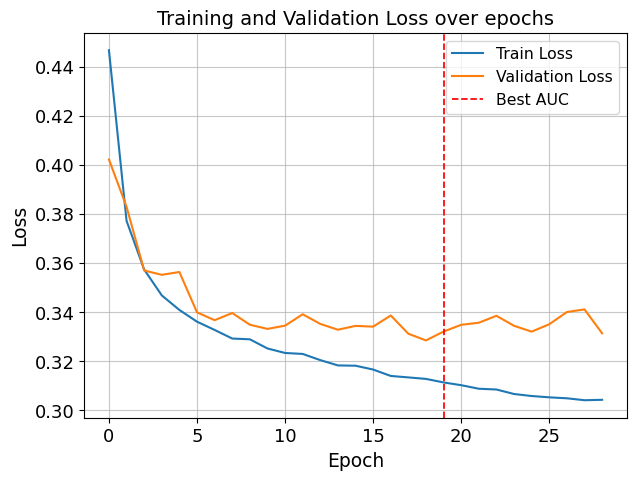

In [39]:
train_data = np.load("XLSTM_sequences_grid_search/train_losses_M-S-M.npy")
val_data = np.load("XLSTM_sequences_grid_search/val_losses_M-S-M.npy")

plt.figure(figsize=(7,5))
epochs= np.arange(len(train_data))
plt.plot(epochs,train_data, label="Train Loss")
plt.plot(epochs,val_data, label="Validation Loss")
plt.axvline(x=19,color='red', linestyle='--', linewidth=1.25,label="Best AUC")
plt.xlabel("Epoch",fontsize=13.5)
plt.ylabel("Loss",fontsize=13.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title("Training and Validation Loss over epochs",fontsize=14)
plt.legend(fontsize=11.28,loc='best')
plt.grid(True,alpha=0.7)
plt.savefig("best_xLSTM_sequence_gridsearch_losses.pdf", dpi=400, bbox_inches="tight")
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:47<00:00,  5.50it/s]


Test set Loss: 0.3302798569202423, ROC AUC: 0.9641340064072645


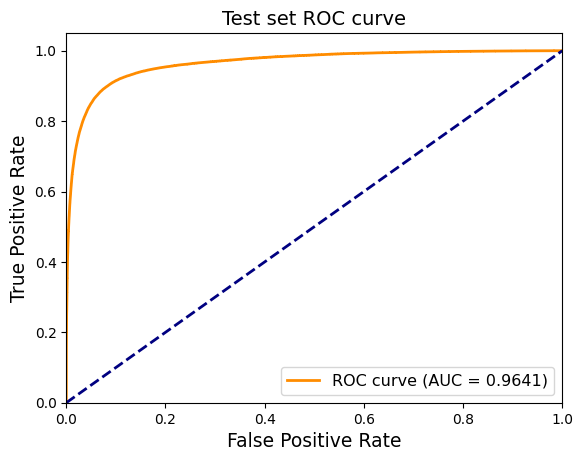

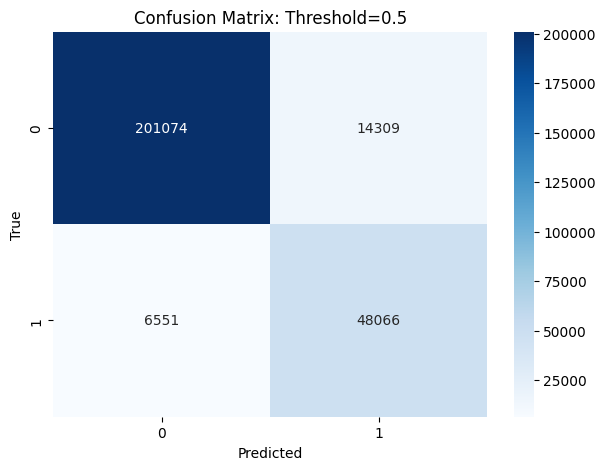

With threshold=0.5: Test set Accuracy: 0.9227, Precision: 0.7706, Recall: 0.8801, F1 score: 0.8217 



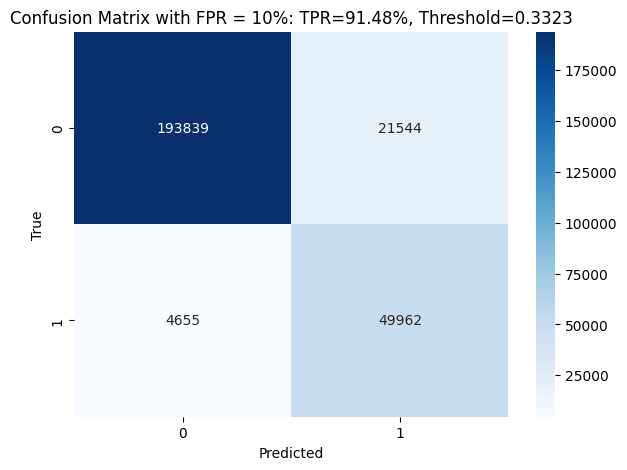

With threshold=0.3323: Test set Accuracy: 0.9030, Precision: 0.6987, Recall: 0.9148, F1 score: 0.7923 



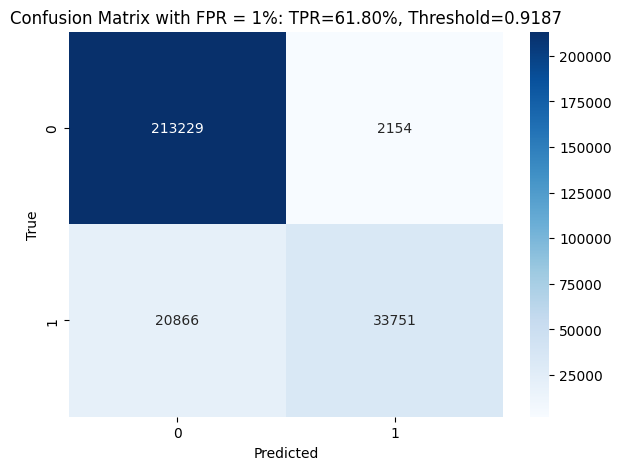

With threshold=0.9187: Test set Accuracy: 0.9147, Precision: 0.9400, Recall: 0.6180, F1 score: 0.7457 



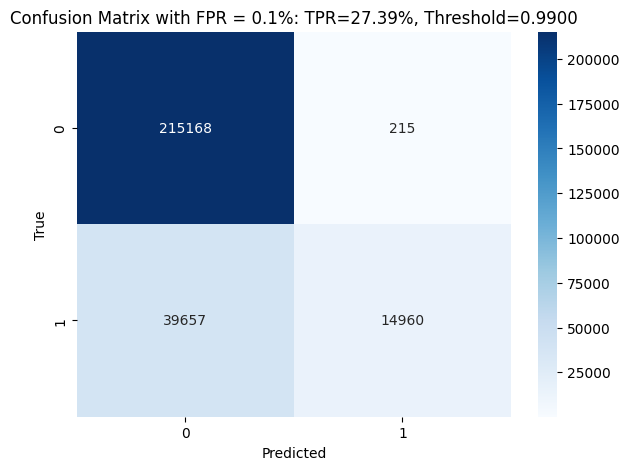

With threshold=0.9900: Test set Accuracy: 0.8523, Precision: 0.9858, Recall: 0.2739, F1 score: 0.4287 

Background rejection at TPR=30%: 1/FPR = 791.8493 (FPR=0.0013)
Background rejection at TPR=50%: 1/FPR = 209.5165 (FPR=0.0048)


In [26]:
# evaluate performance of the best model on the test set

device = "cuda" if torch.cuda.is_available() else "cpu"
best_xlstm = JetTagger_XLSTM(hidden_dim=45,block_sequence=['M','S', 'M'])
best_xlstm.load_state_dict(torch.load("XLSTM_sequences_grid_search/XLSTM_sequence_M-S-M.pt", map_location=device))
best_xlstm.to(device)
pos_weight = torch.tensor([3.0173954931292917], device=device)
evaluate_network(test_dataloader,best_xlstm,pos_weight,"Test set")

#### Other xLSTM models

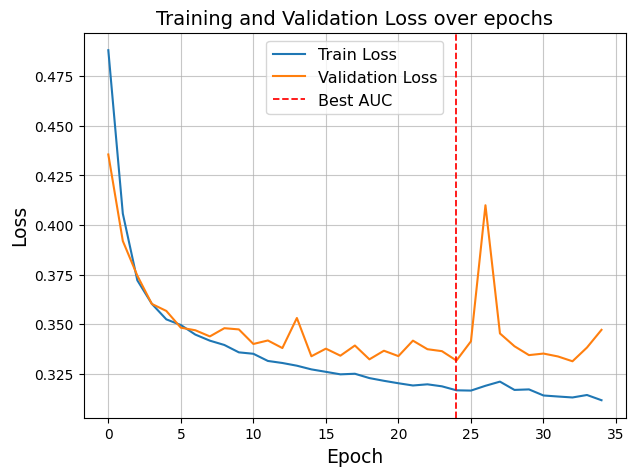

In [14]:
train_data = np.load("XLSTM_sequences_grid_search/train_losses_M-M-S-M-M-M.npy")
val_data = np.load("XLSTM_sequences_grid_search/val_losses_M-M-S-M-M-M.npy")

plt.figure(figsize=(7,5))
epochs= np.arange(len(train_data))
plt.plot(epochs,train_data, label="Train Loss")
plt.plot(epochs,val_data, label="Validation Loss")
plt.axvline(x=24,color='red', linestyle='--', linewidth=1.25,label="Best AUC")
plt.xlabel("Epoch",fontsize=13.5)
plt.ylabel("Loss",fontsize=13.5)
plt.title("Training and Validation Loss over epochs",fontsize=14)
plt.legend(fontsize=11.5)
plt.grid(True,alpha=0.7)
plt.savefig("best_xLSTM_sequence_gridsearch_losses.pdf", dpi=400, bbox_inches="tight")
plt.show()

Here we notice a weird spike in validation loss. It appears that the loss landascape of the model can make minimization challenging.

100%|███████████████████████████████████████████████████████████████████████| 264/264 [01:13<00:00,  3.60it/s]


Test set Loss: 0.33141928911209106, ROC AUC: 0.9638862948979329


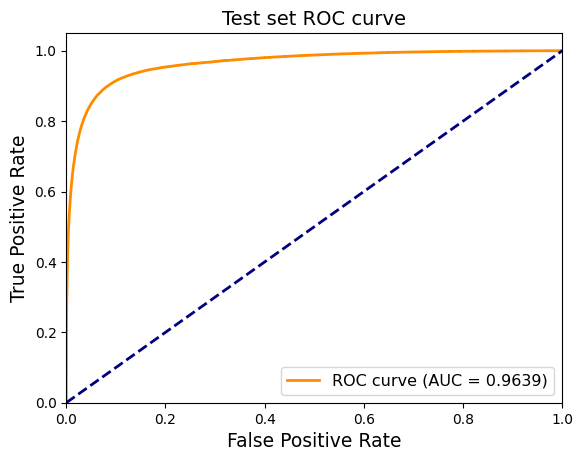

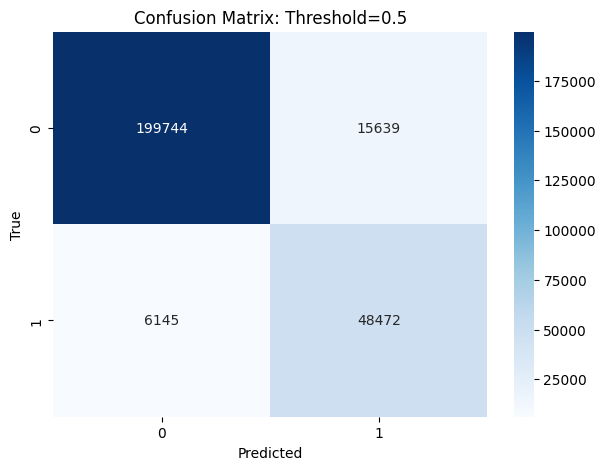

With threshold=0.5: Test set Accuracy: 0.9193, Precision: 0.7561, Recall: 0.8875, F1 score: 0.8165 



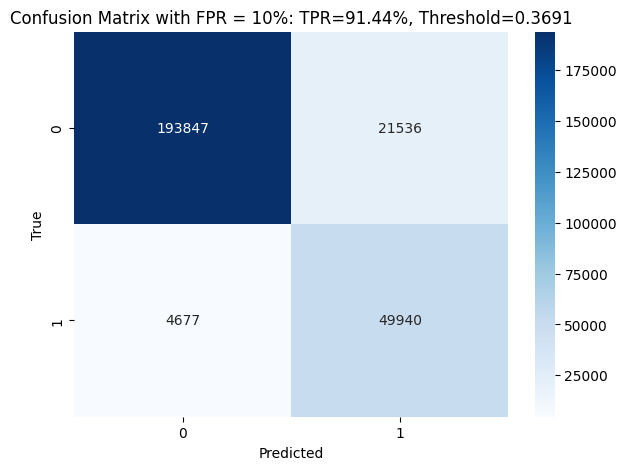

With threshold=0.3691: Test set Accuracy: 0.9029, Precision: 0.6987, Recall: 0.9144, F1 score: 0.7921 



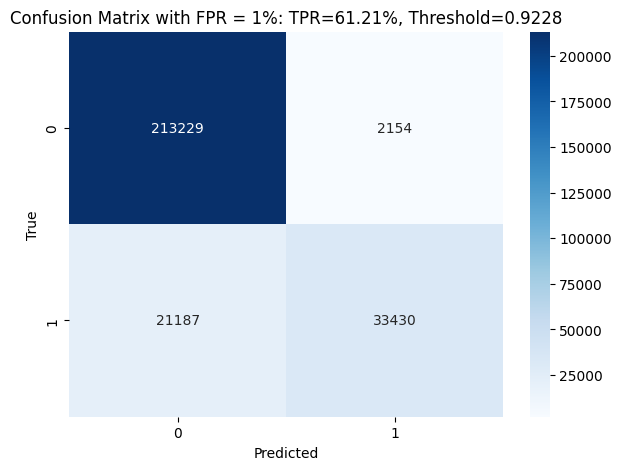

With threshold=0.9228: Test set Accuracy: 0.9136, Precision: 0.9395, Recall: 0.6121, F1 score: 0.7412 



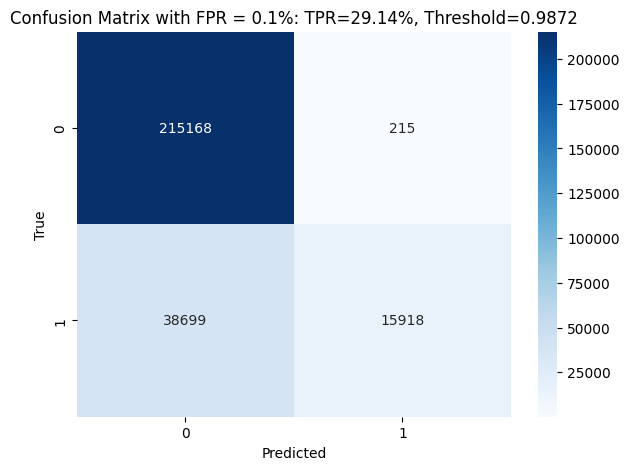

With threshold=0.9872: Test set Accuracy: 0.8559, Precision: 0.9867, Recall: 0.2914, F1 score: 0.4500 

Background rejection at TPR=30%: 1/FPR = 924.3906 (FPR=0.0011)
Background rejection at TPR=50%: 1/FPR = 209.1097 (FPR=0.0048)


In [22]:
# evaluate performance on the test set

device = "cuda" if torch.cuda.is_available() else "cpu"
best_xlstm = JetTagger_XLSTM(hidden_dim=45,block_sequence=['M', 'M', 'S', 'M', 'M', 'M'])
best_xlstm.load_state_dict(torch.load("XLSTM_sequences_grid_search/XLSTM_sequence_M-M-S-M-M-M.pt", map_location=device))
best_xlstm.to(device)
pos_weight = torch.tensor([3.0173954931292917], device=device)
evaluate_network(test_dataloader,best_xlstm,pos_weight,"Test set")

Model: M-M


100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:40<00:00,  6.52it/s]


Test set Loss: 0.3334803283214569, ROC AUC: 0.963365122177883


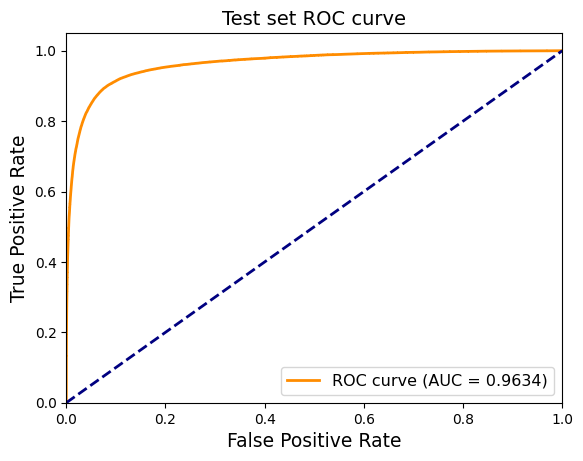

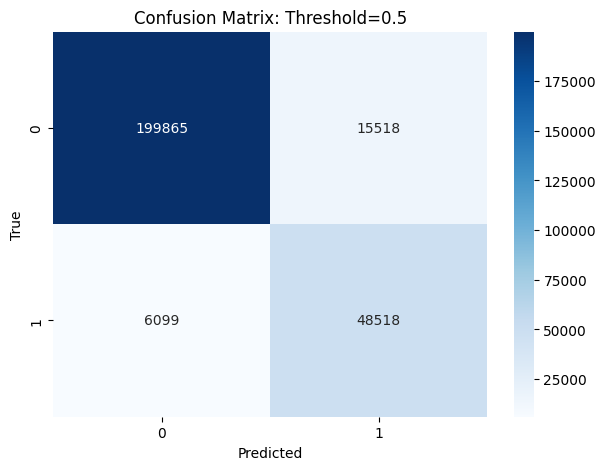

With threshold=0.5: Test set Accuracy: 0.9199, Precision: 0.7577, Recall: 0.8883, F1 score: 0.8178 



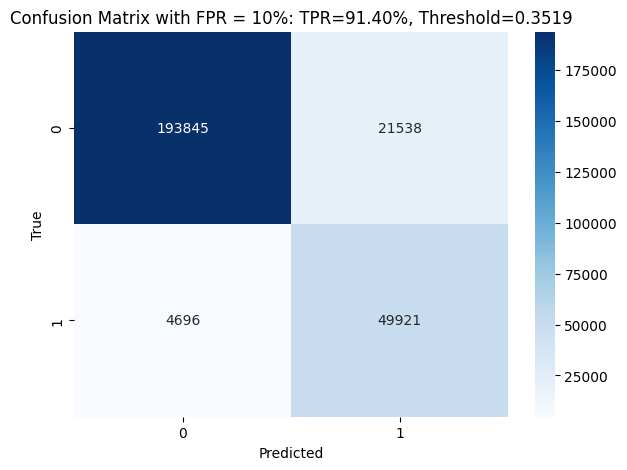

With threshold=0.3519: Test set Accuracy: 0.9028, Precision: 0.6986, Recall: 0.9140, F1 score: 0.7919 



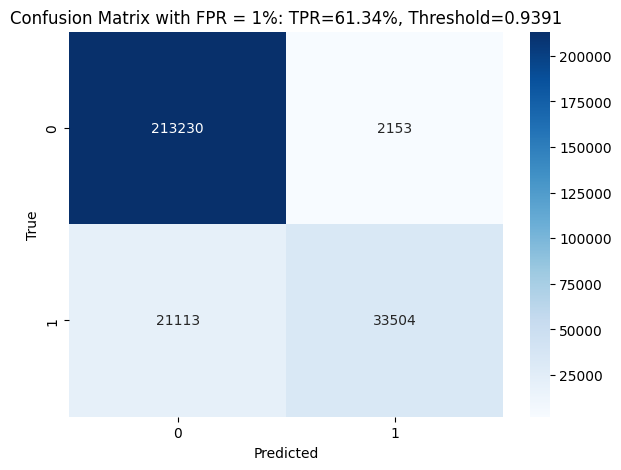

With threshold=0.9391: Test set Accuracy: 0.9138, Precision: 0.9396, Recall: 0.6134, F1 score: 0.7423 



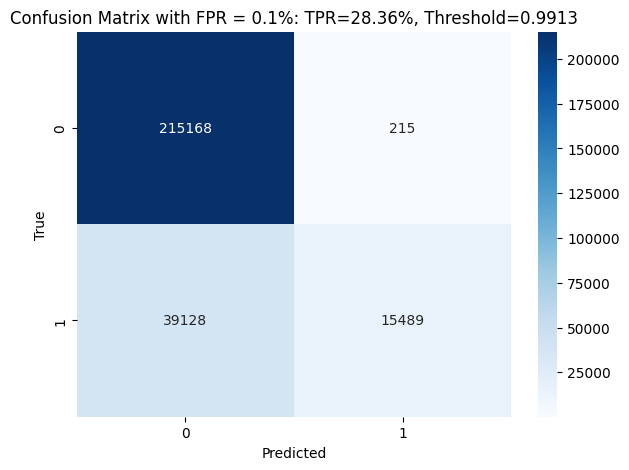

With threshold=0.9913: Test set Accuracy: 0.8543, Precision: 0.9863, Recall: 0.2836, F1 score: 0.4405 

Background rejection at TPR=30%: 1/FPR = 861.5320 (FPR=0.0012)
Background rejection at TPR=50%: 1/FPR = 204.9315 (FPR=0.0049)


Model: M-S


100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:29<00:00,  8.96it/s]


Test set Loss: 0.33200469613075256, ROC AUC: 0.9636579253856279


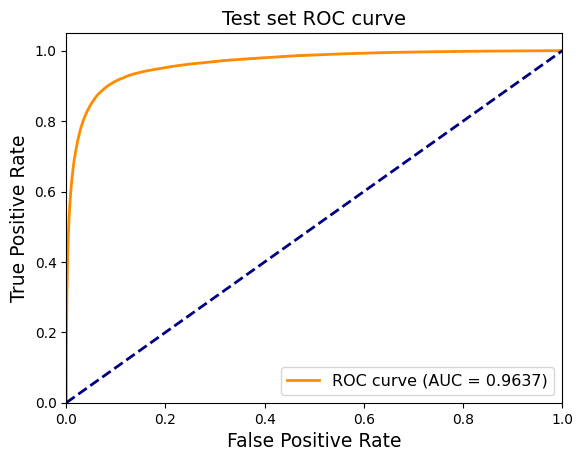

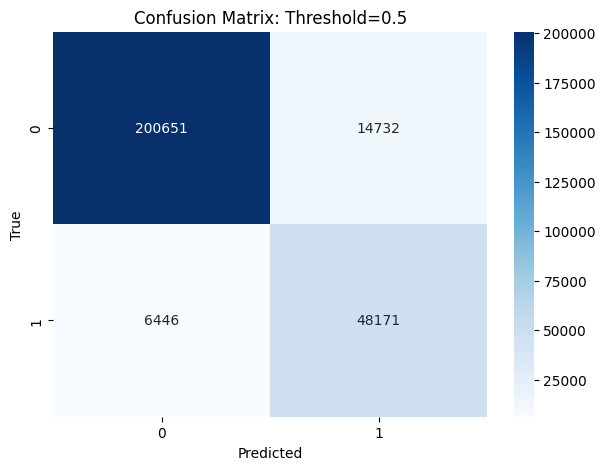

With threshold=0.5: Test set Accuracy: 0.9216, Precision: 0.7658, Recall: 0.8820, F1 score: 0.8198 



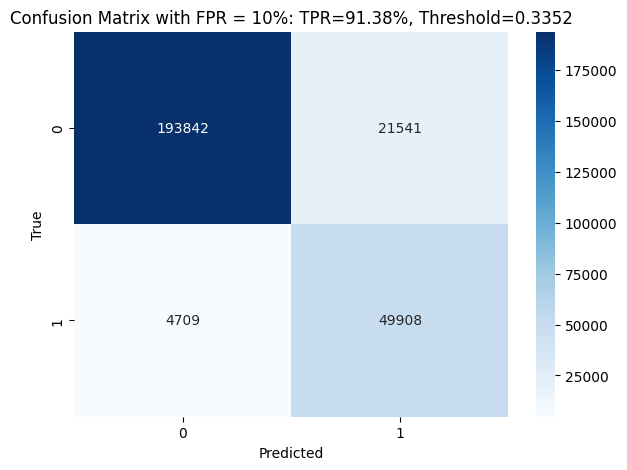

With threshold=0.3352: Test set Accuracy: 0.9028, Precision: 0.6985, Recall: 0.9138, F1 score: 0.7918 



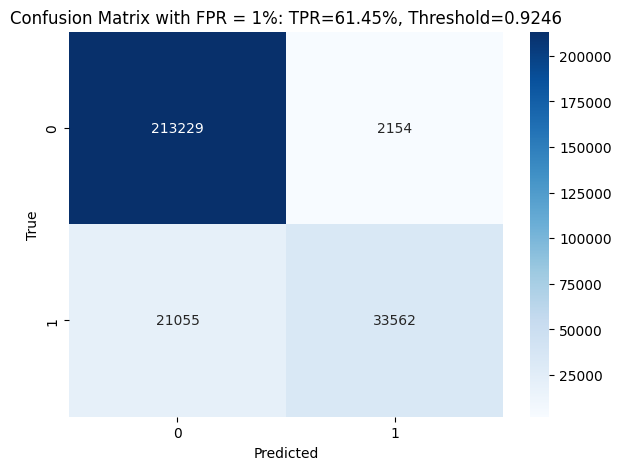

With threshold=0.9246: Test set Accuracy: 0.9140, Precision: 0.9397, Recall: 0.6145, F1 score: 0.7431 



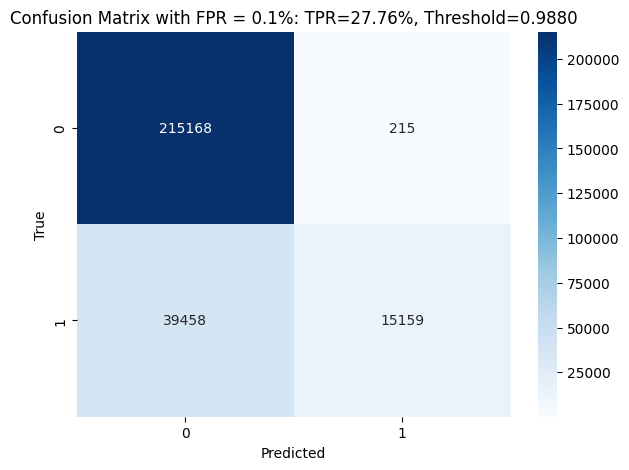

With threshold=0.9880: Test set Accuracy: 0.8531, Precision: 0.9860, Recall: 0.2776, F1 score: 0.4332 

Background rejection at TPR=30%: 1/FPR = 834.8178 (FPR=0.0012)
Background rejection at TPR=50%: 1/FPR = 205.5181 (FPR=0.0049)


Model: M-M-S


100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:44<00:00,  5.91it/s]


Test set Loss: 0.33188432455062866, ROC AUC: 0.9637941702117216


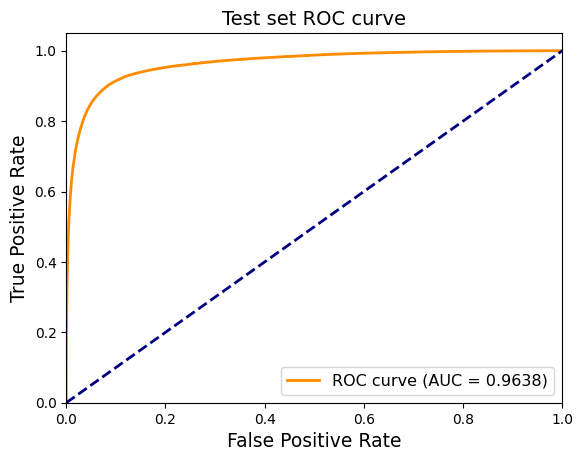

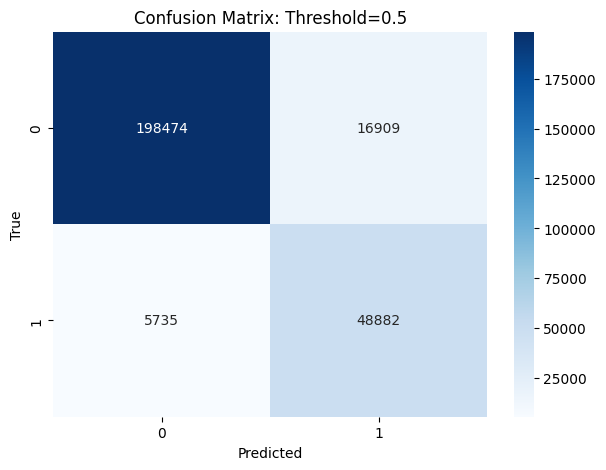

With threshold=0.5: Test set Accuracy: 0.9161, Precision: 0.7430, Recall: 0.8950, F1 score: 0.8119 



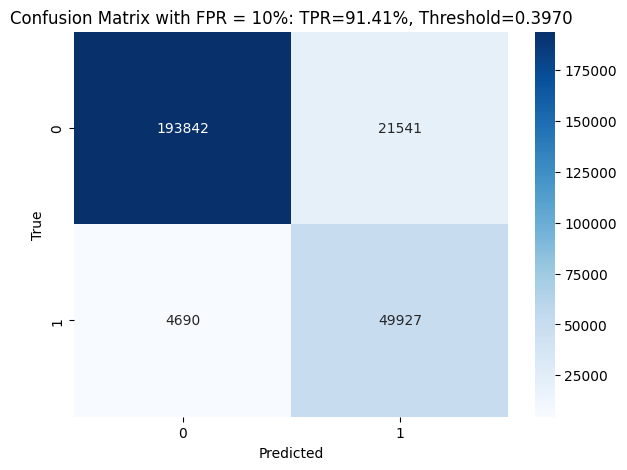

With threshold=0.3970: Test set Accuracy: 0.9028, Precision: 0.6986, Recall: 0.9141, F1 score: 0.7920 



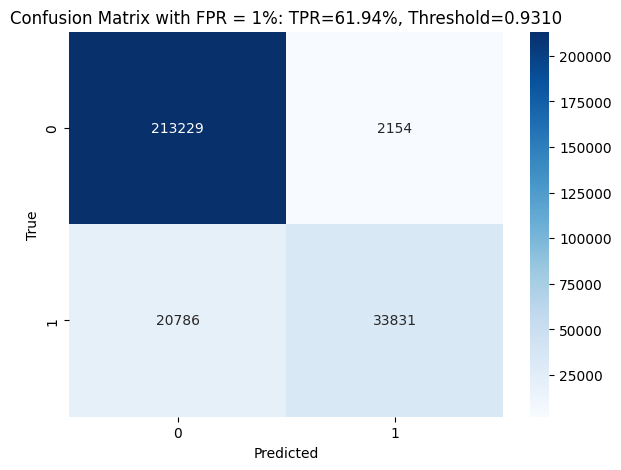

With threshold=0.9310: Test set Accuracy: 0.9150, Precision: 0.9401, Recall: 0.6194, F1 score: 0.7468 



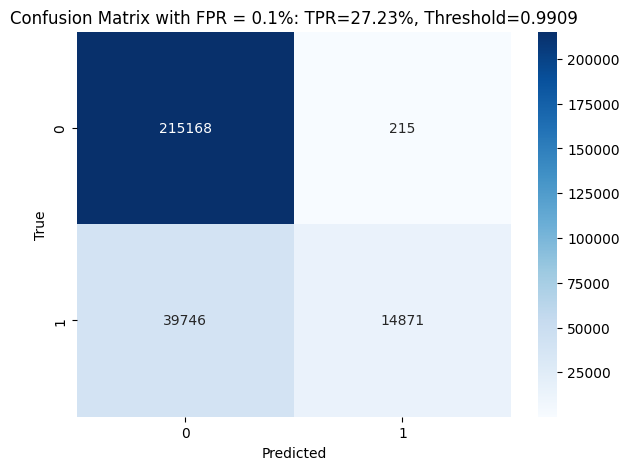

With threshold=0.9909: Test set Accuracy: 0.8520, Precision: 0.9857, Recall: 0.2723, F1 score: 0.4267 

Background rejection at TPR=30%: 1/FPR = 791.8493 (FPR=0.0013)
Background rejection at TPR=50%: 1/FPR = 210.5406 (FPR=0.0047)


Model: M-M-S-M


100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [00:59<00:00,  4.44it/s]


Test set Loss: 0.32972419261932373, ROC AUC: 0.9643590851677738


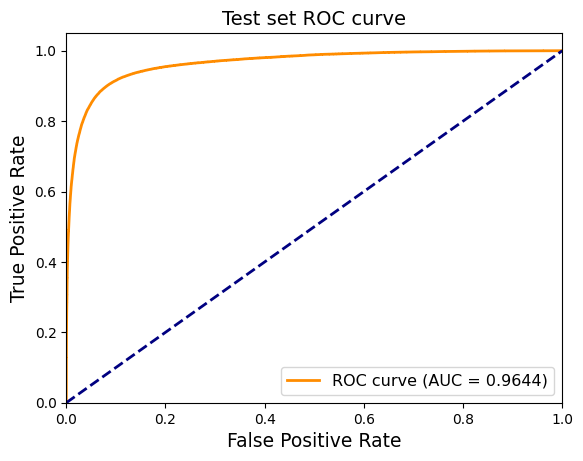

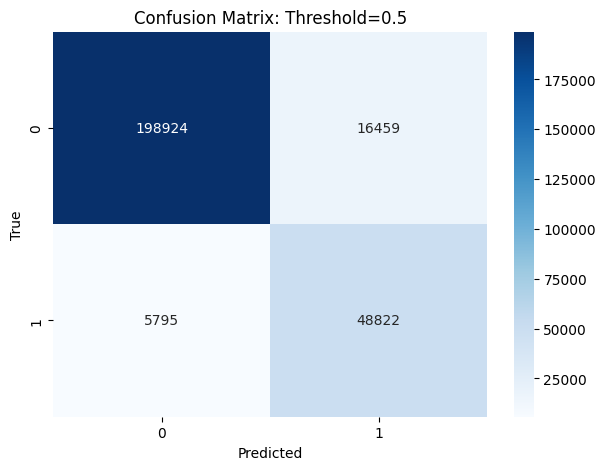

With threshold=0.5: Test set Accuracy: 0.9176, Precision: 0.7479, Recall: 0.8939, F1 score: 0.8144 



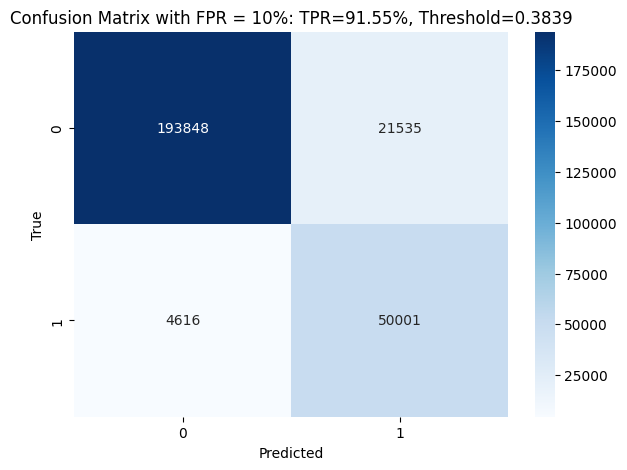

With threshold=0.3839: Test set Accuracy: 0.9031, Precision: 0.6990, Recall: 0.9155, F1 score: 0.7927 



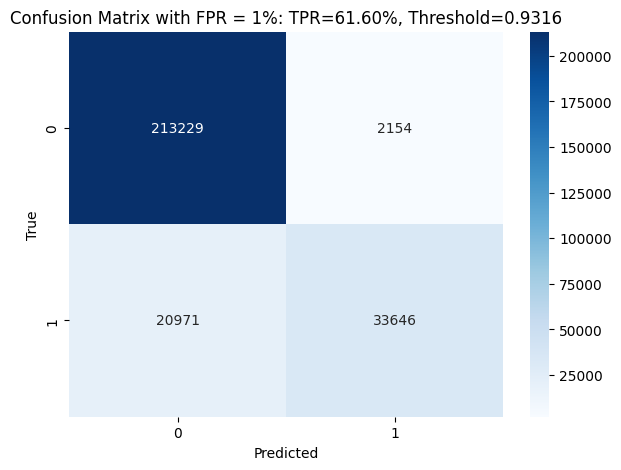

With threshold=0.9316: Test set Accuracy: 0.9144, Precision: 0.9398, Recall: 0.6160, F1 score: 0.7442 



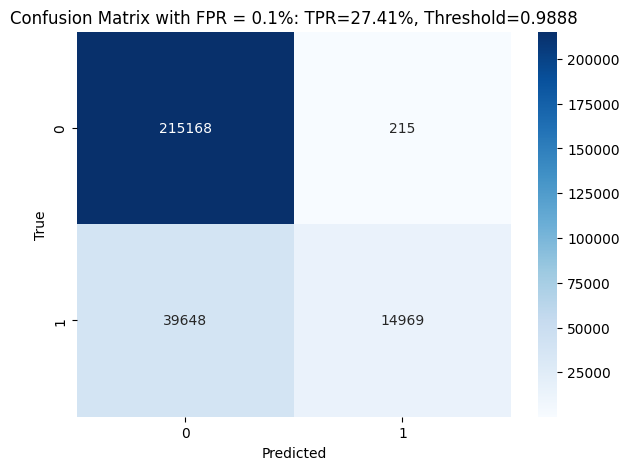

With threshold=0.9888: Test set Accuracy: 0.8524, Precision: 0.9858, Recall: 0.2741, F1 score: 0.4289 

Background rejection at TPR=30%: 1/FPR = 800.6803 (FPR=0.0012)
Background rejection at TPR=50%: 1/FPR = 200.9170 (FPR=0.0050)


Model: M-M-S-M-M


100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [01:15<00:00,  3.49it/s]


Test set Loss: 0.33234551548957825, ROC AUC: 0.9643213213873087


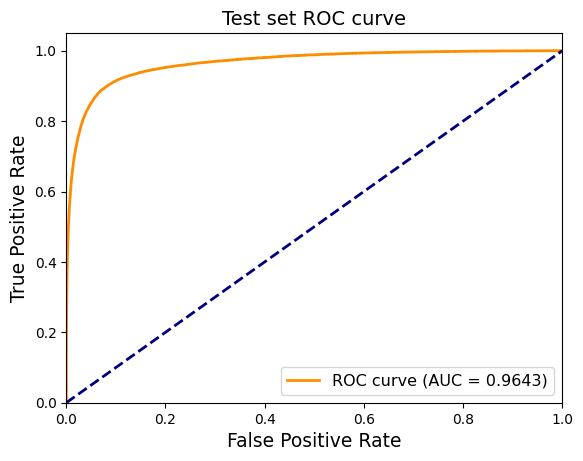

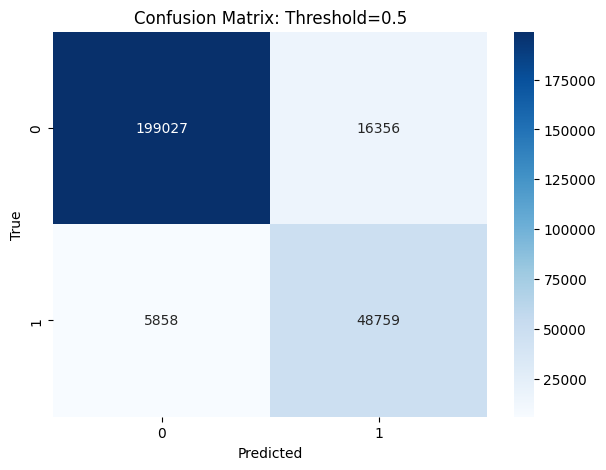

With threshold=0.5: Test set Accuracy: 0.9177, Precision: 0.7488, Recall: 0.8927, F1 score: 0.8145 



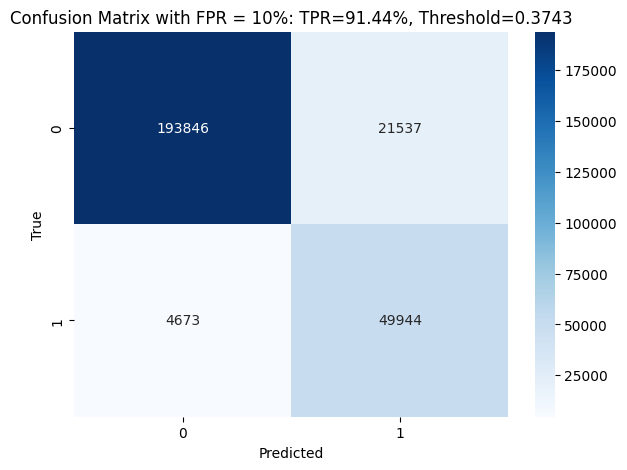

With threshold=0.3743: Test set Accuracy: 0.9029, Precision: 0.6987, Recall: 0.9144, F1 score: 0.7921 



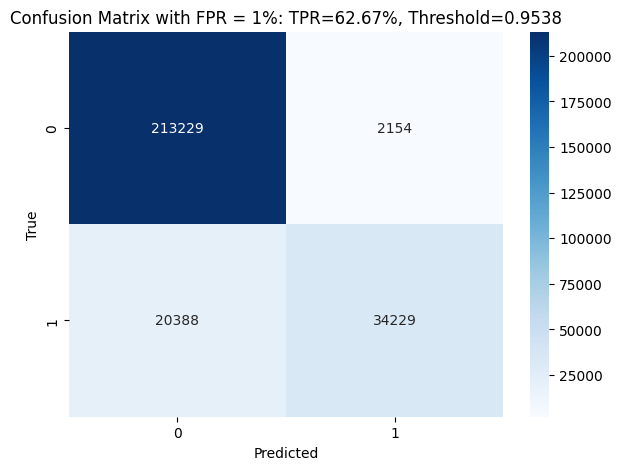

With threshold=0.9538: Test set Accuracy: 0.9165, Precision: 0.9408, Recall: 0.6267, F1 score: 0.7523 



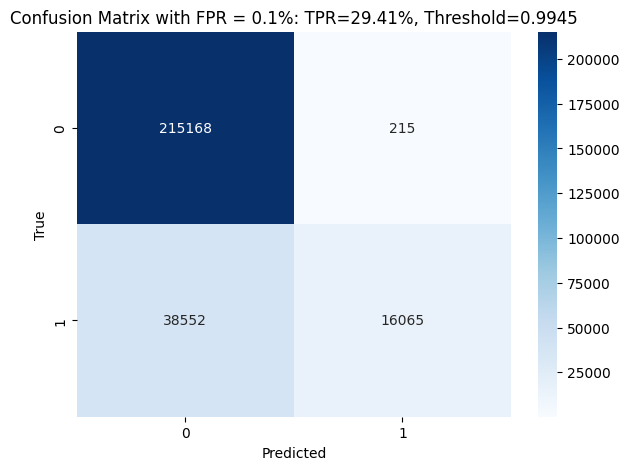

With threshold=0.9945: Test set Accuracy: 0.8564, Precision: 0.9868, Recall: 0.2941, F1 score: 0.4532 

Background rejection at TPR=30%: 1/FPR = 961.5312 (FPR=0.0010)
Background rejection at TPR=50%: 1/FPR = 229.8645 (FPR=0.0044)


Model: M-M-S-M-M-S


100%|█████████████████████████████████████████████████████████████████████████████████| 264/264 [01:25<00:00,  3.10it/s]


Test set Loss: 0.3297708332538605, ROC AUC: 0.9643950418867755


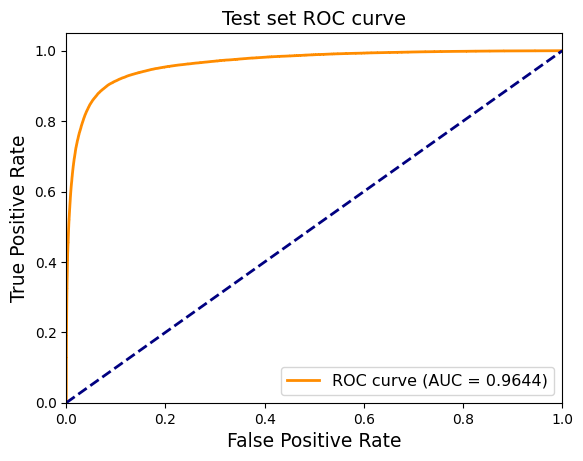

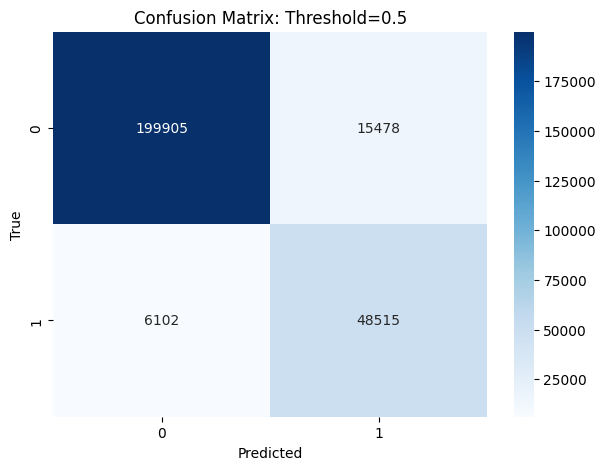

With threshold=0.5: Test set Accuracy: 0.9201, Precision: 0.7581, Recall: 0.8883, F1 score: 0.8181 



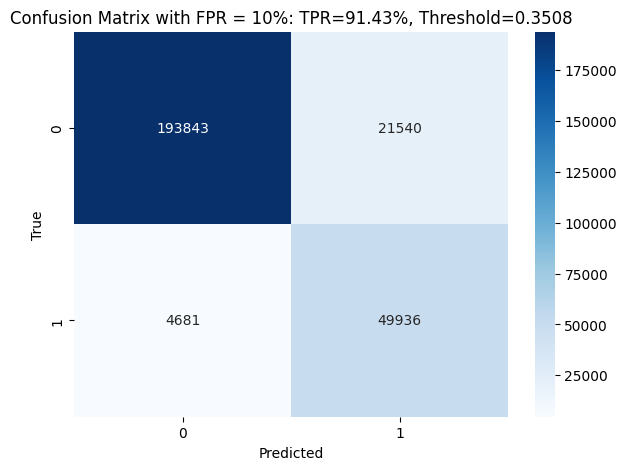

With threshold=0.3508: Test set Accuracy: 0.9029, Precision: 0.6986, Recall: 0.9143, F1 score: 0.7921 



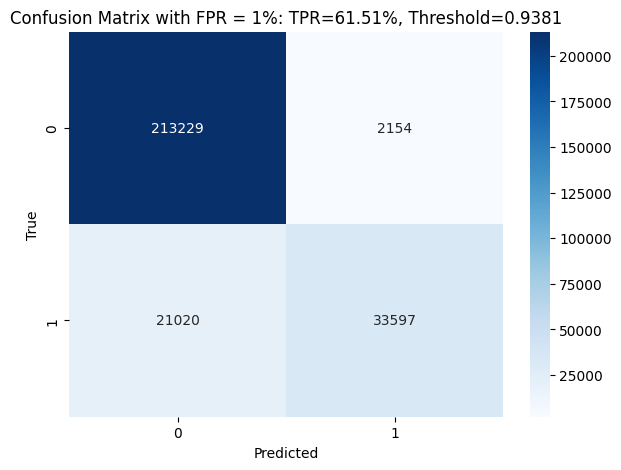

With threshold=0.9381: Test set Accuracy: 0.9142, Precision: 0.9397, Recall: 0.6151, F1 score: 0.7436 



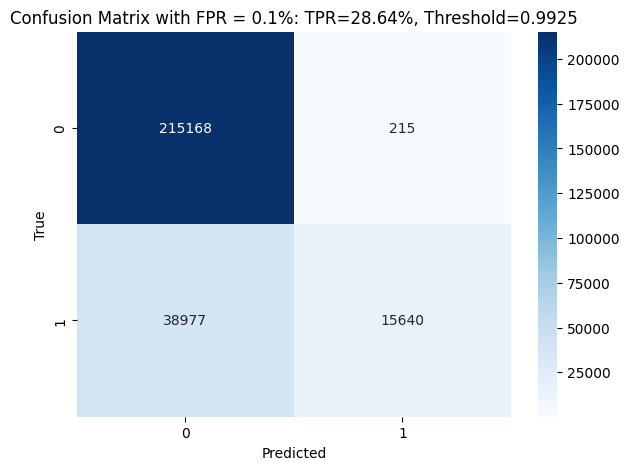

With threshold=0.9925: Test set Accuracy: 0.8548, Precision: 0.9864, Recall: 0.2864, F1 score: 0.4439 

Background rejection at TPR=30%: 1/FPR = 924.3906 (FPR=0.0011)
Background rejection at TPR=50%: 1/FPR = 204.3482 (FPR=0.0049)




In [31]:
# evaluate performance on the test set
device = "cuda" if torch.cuda.is_available() else "cpu"

candidates = [
        ["M","M"],
        ["M","S"],
        ["M","M","S"],
        ["M","M","S","M"],
        ["M","M","S","M","M"],
        ["M","M","S","M","M","S"]]

for seq in candidates:
    seq_str = "-".join(seq)
    xlstm = JetTagger_XLSTM(hidden_dim=45,block_sequence=seq)
    xlstm.load_state_dict(torch.load(f"XLSTM_sequences_grid_search/XLSTM_sequence_{seq_str}.pt", map_location=device))
    xlstm.to(device)
    pos_weight = torch.tensor([3.0173954931292917], device=device)
    print(f"Model: {seq_str}")
    evaluate_network(test_dataloader,xlstm,pos_weight,"Test set")
    print("\n")
